In [14]:
suppressMessages(library(rwwa))
png_res <- 240

# Exploratory analysis - HDWI

In [28]:
df <- merge(merge(merge(read.table("ts-obs/gmst-smoothed.dat", col.names = c("year", "gmst")),
                        load_ts("ts-obs/sam-fires_nino34det-ndj.dat", col.names = c("year", "nino34"))),
                  load_ts("ts-obs/sam-fires_sam-dec.dat", col.names = c("year", "sam"))),
            merge(load_ts(paste0("ts-obs/sam-fires_hdwi_chile2026_era5land.dat"), col.names = c("year", "hdwi_ch")),
                  load_ts(paste0("ts-obs/sam-fires_hdwi_patagonia_era5land.dat"), col.names = c("year", "hdwi_ar"))))

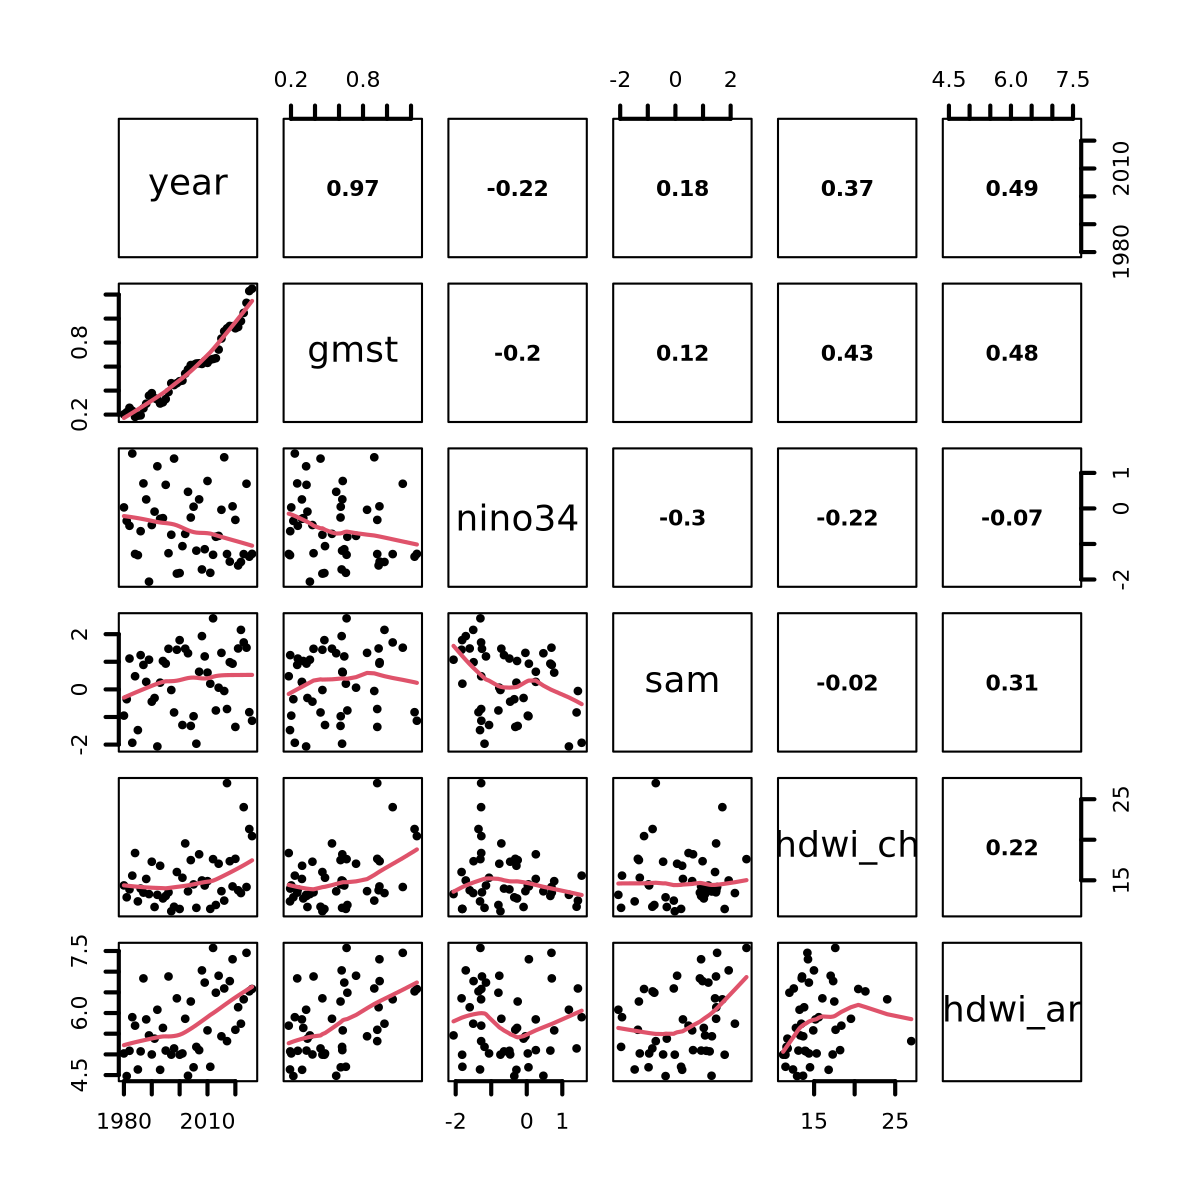

In [87]:
prep_window(h = 6, w = 6)
pairs(df, upper.panel = panel.cor, lower.panel = panel.smooth, lwd = 2)

## Check distributions

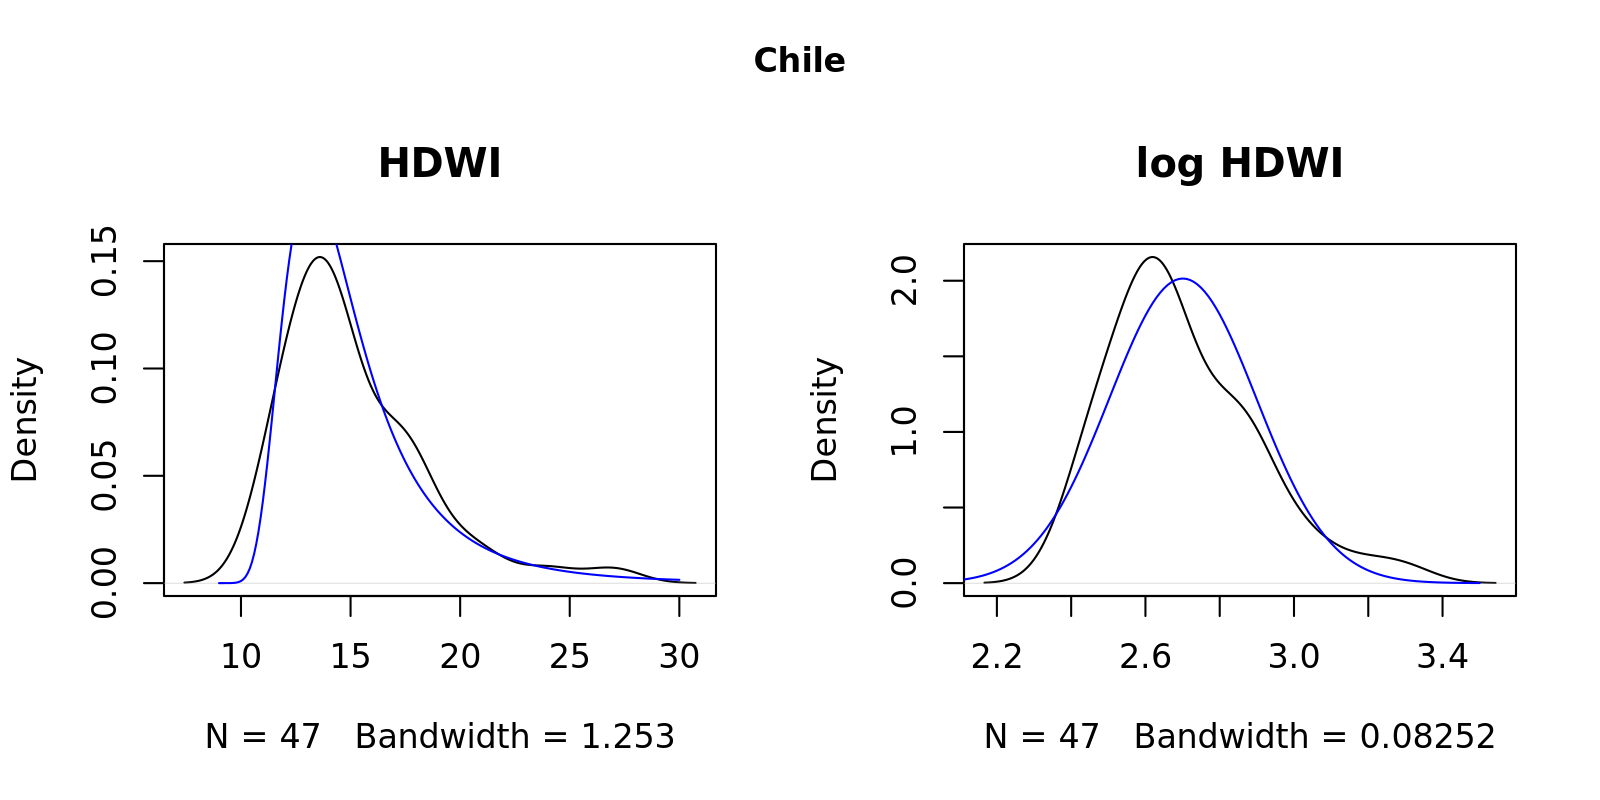

In [ ]:
prep_window(c(1,2), oma = c(0,0,2,0))

plot(density(df$hdwi_ch), main = "HDWI")
lines(x <- seq(9,30,0.1), do.call(devd, append(setNames(as.list(fevd(df$hdwi_ch, df)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "blue")

plot(density(log(df$hdwi_ch)), main = "log HDWI")
lines(x <- seq(2,3.5,0.01), dnorm(x, mean(log(df$hdwi_ch)), sd(log(df$hdwi_ch))), col = "blue")

mtext("Chile", side = 3, outer = T, font = 2)

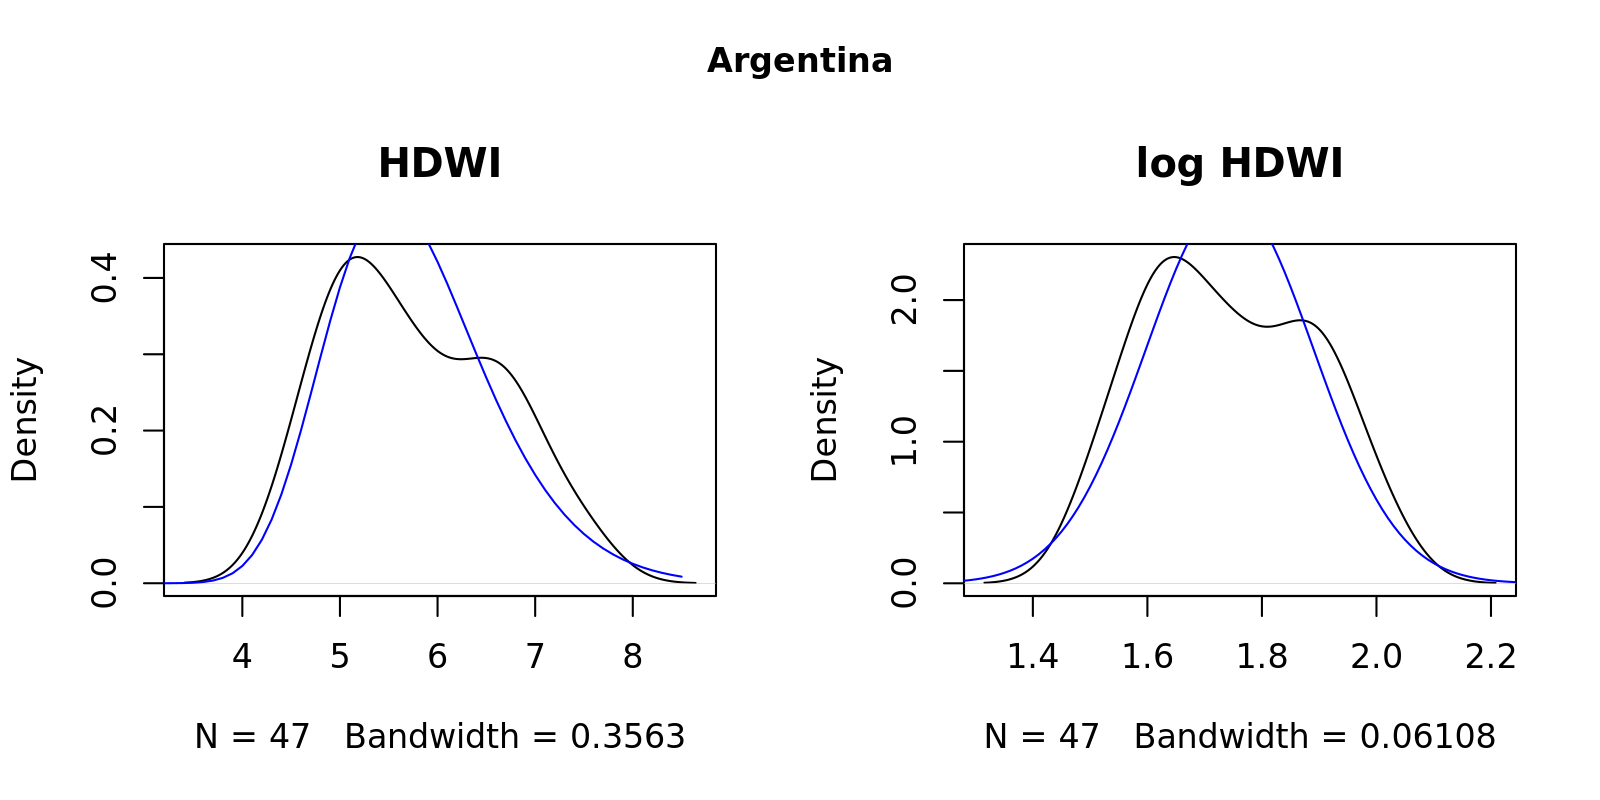

In [92]:
prep_window(c(1,2), oma = c(0,0,2,0))

plot(density(df$hdwi_ar), main = "HDWI")
lines(x <- seq(3,8.5,0.1), do.call(devd, append(setNames(as.list(fevd(df$hdwi_ar, df)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "blue")

plot(density(log(df$hdwi_ar)), main = "log HDWI")
lines(x <- seq(1,2.5,0.01), dnorm(x, mean(log(df$hdwi_ar)), sd(log(df$hdwi_ar))), col = "blue")

mtext("Argentina", side = 3, outer = T, font = 2)

## Model selection

### Chile

In [123]:
covar_list <- list("GMST only" = "gmst", "Nino only" = "nino34", "SAM only" = "sam",
                   "GMST + Nino" = c("gmst", "nino34"), "GMST + SAM" = c("gmst", "sam"), "GMST + Nino + SAM" = c("gmst", "nino34", "sam"))

# fit all model variants
args_chile <- list(dist = "gev", varnm = "hdwi_ch", data = df, lower = F)
models_chile_shift <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shift"))), simplify = F)
models_chile_fixeddisp <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "fixeddisp"))), simplify = F)
models_chile_shiftscale <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale"))), simplify = F)
models_chile_shiftscalelinear <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale_linear", method = "Nelder-Mead"))), simplify = F)

args_arg <- list(dist = "gev", varnm = "hdwi_ar", data = df, lower = F)
models_arg_shift <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_arg, list(covnm = covs, type = "shift"))), simplify = F)
models_arg_shiftscale <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_arg, list(covnm = covs, type = "shiftscale"))), simplify = F)

In [131]:
round(rbind("chile - shift" = sapply(models_chile_shift, aic),
      "chile - fixed dispersion" = sapply(models_chile_fixeddisp, aic),
      "chile - shift + scale" = sapply(models_chile_shiftscale, aic), 
      "chile - shift + scale (linear)" = sapply(models_chile_shiftscalelinear, aic)#, 
      # "argentina - shift" = sapply(models_arg_shift, aic),
      # "argentina - shift + scale" = sapply(models_arg_shiftscale, aic)
     ), 2)

GMST only Nino only SAM only GMST + Nino
chile - shift                  231.73    233.68    232.77   233.67     
chile - fixed dispersion       230.25    233.79    232.97   232.21     
chile - shift + scale          228.79    229.98    234.35   230.45     
chile - shift + scale (linear) 228.51    230.71    234.35   235.38     
                               GMST + SAM GMST + Nino + SAM
chile - shift                  233.25     234.84           
chile - fixed dispersion       232.18     234.18           
chile - shift + scale          231.83     230.12           
chile - shift + scale (linear) 231.70     224.76

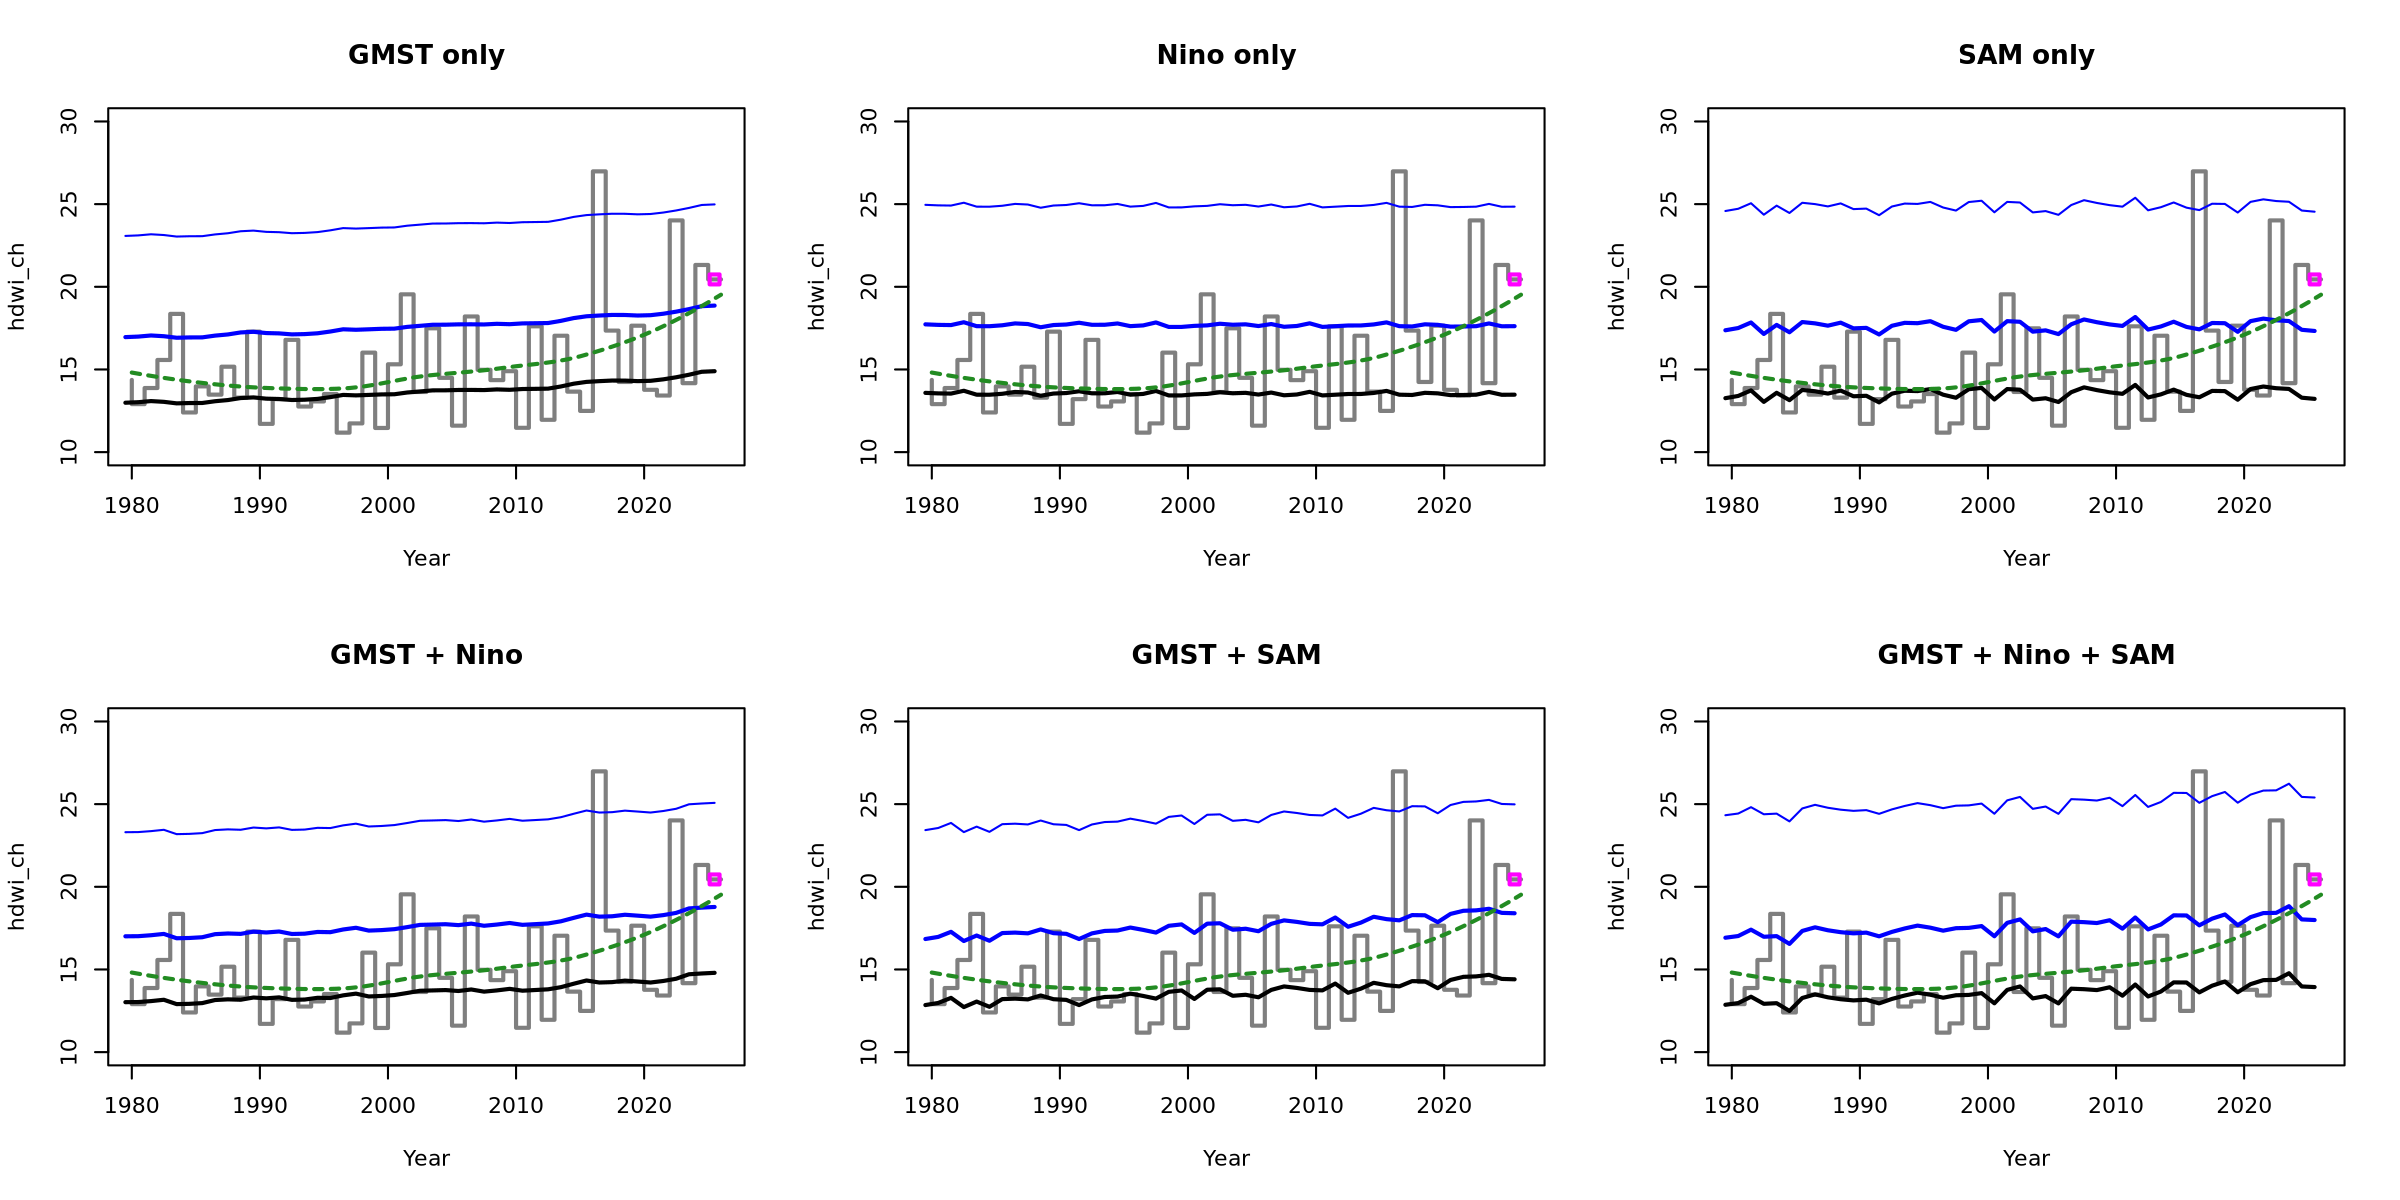

In [128]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_chile_shift)) {
    plot_trend(models_chile_shift[[m]], main = m, legend_pos = NA)
}

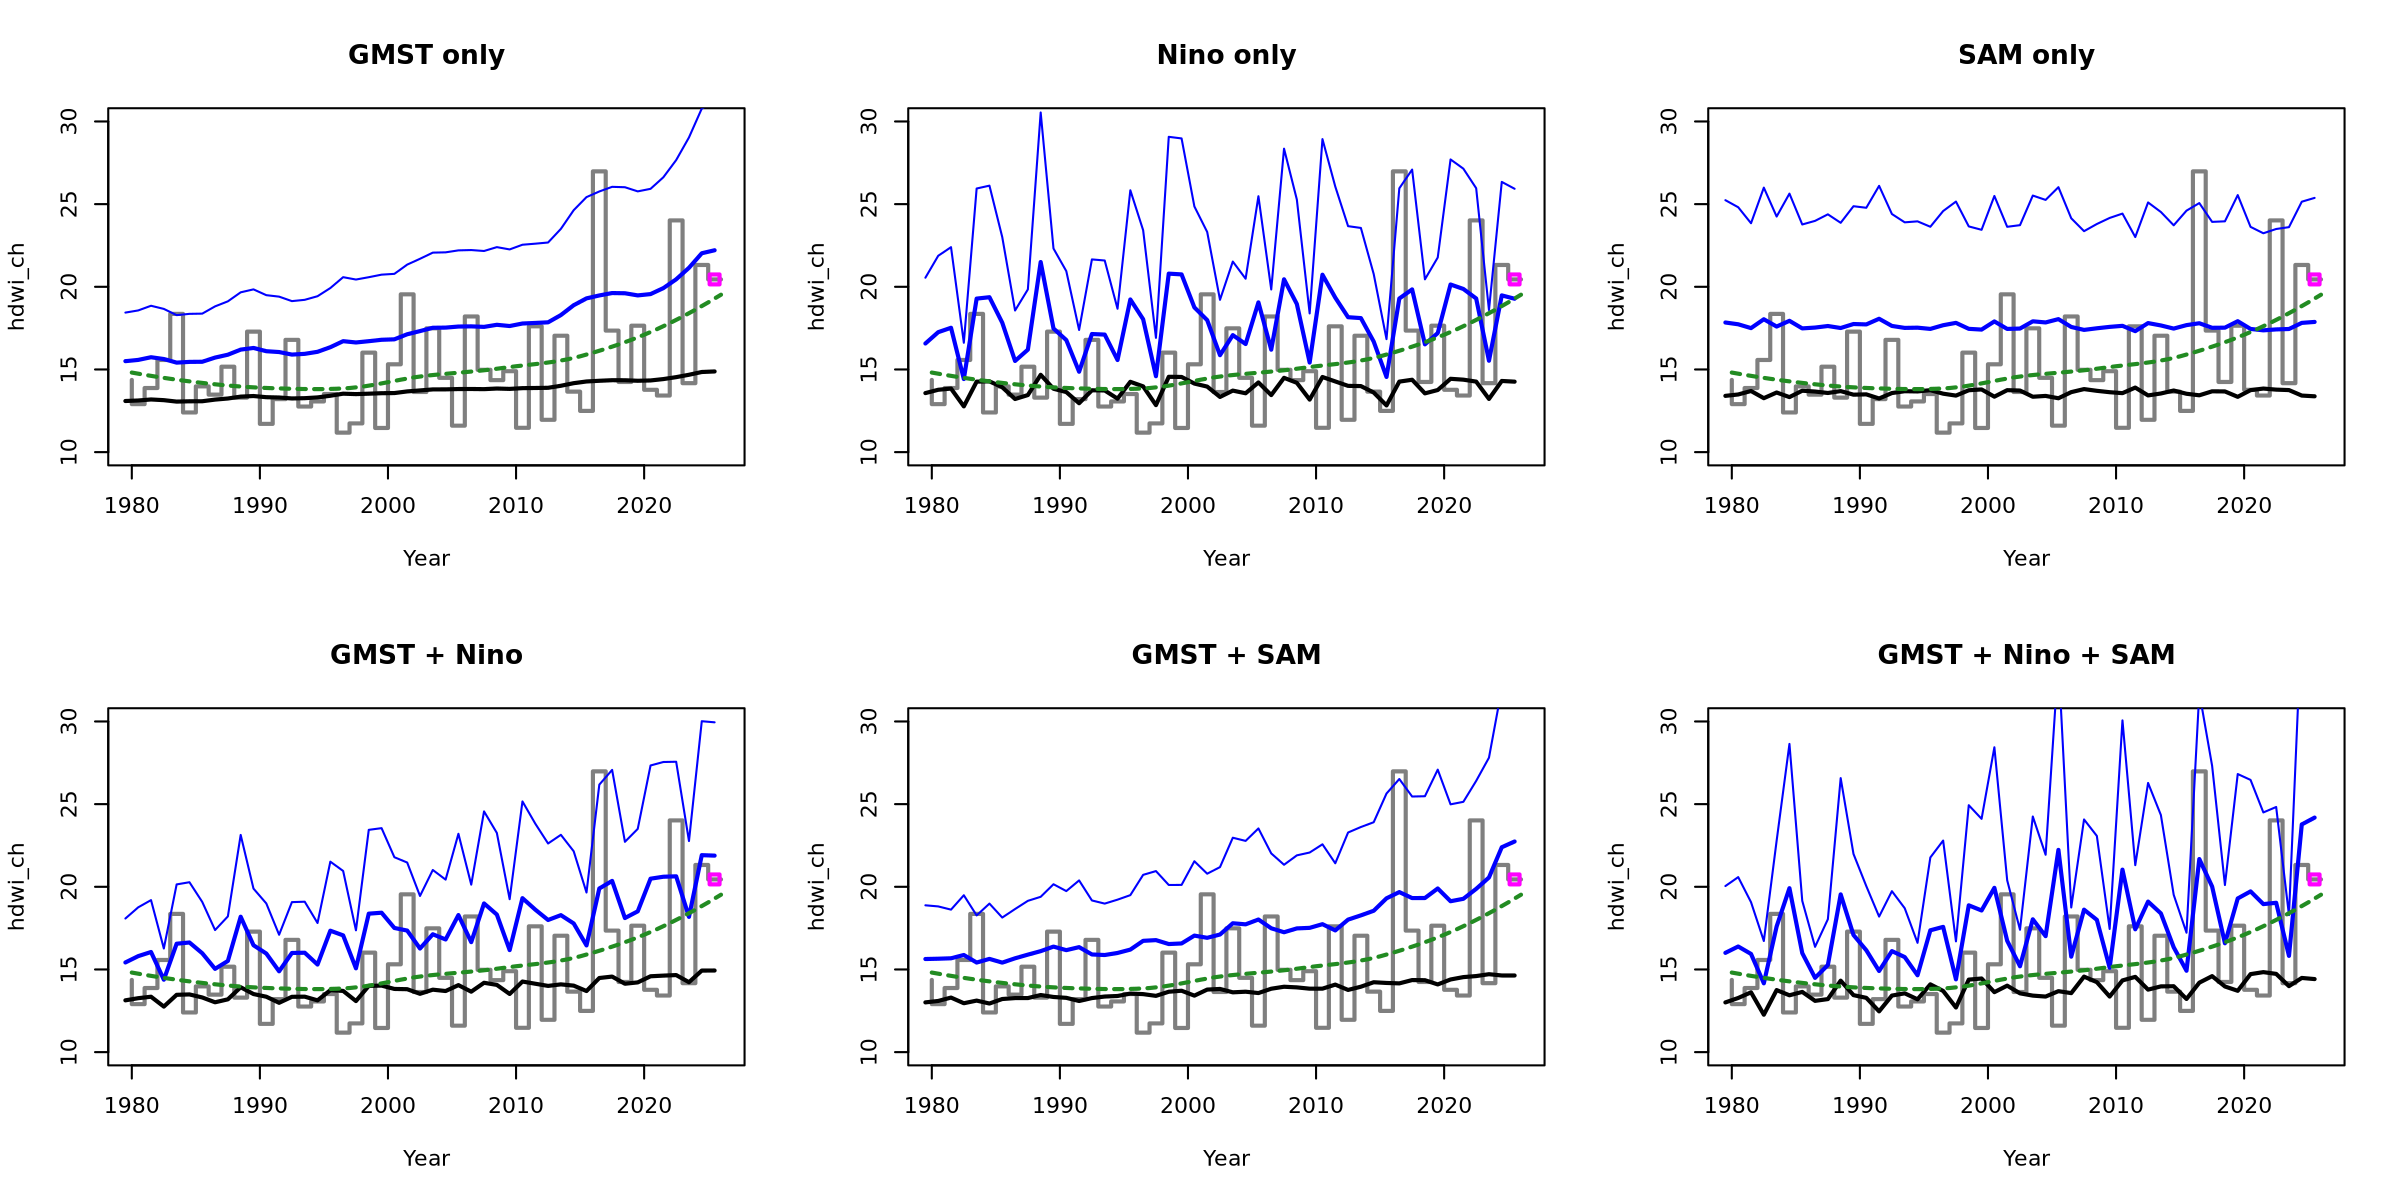

In [132]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_chile_shiftscale)) {
    plot_trend(models_chile_shiftscale[[m]], main = m, legend_pos = NA)
}

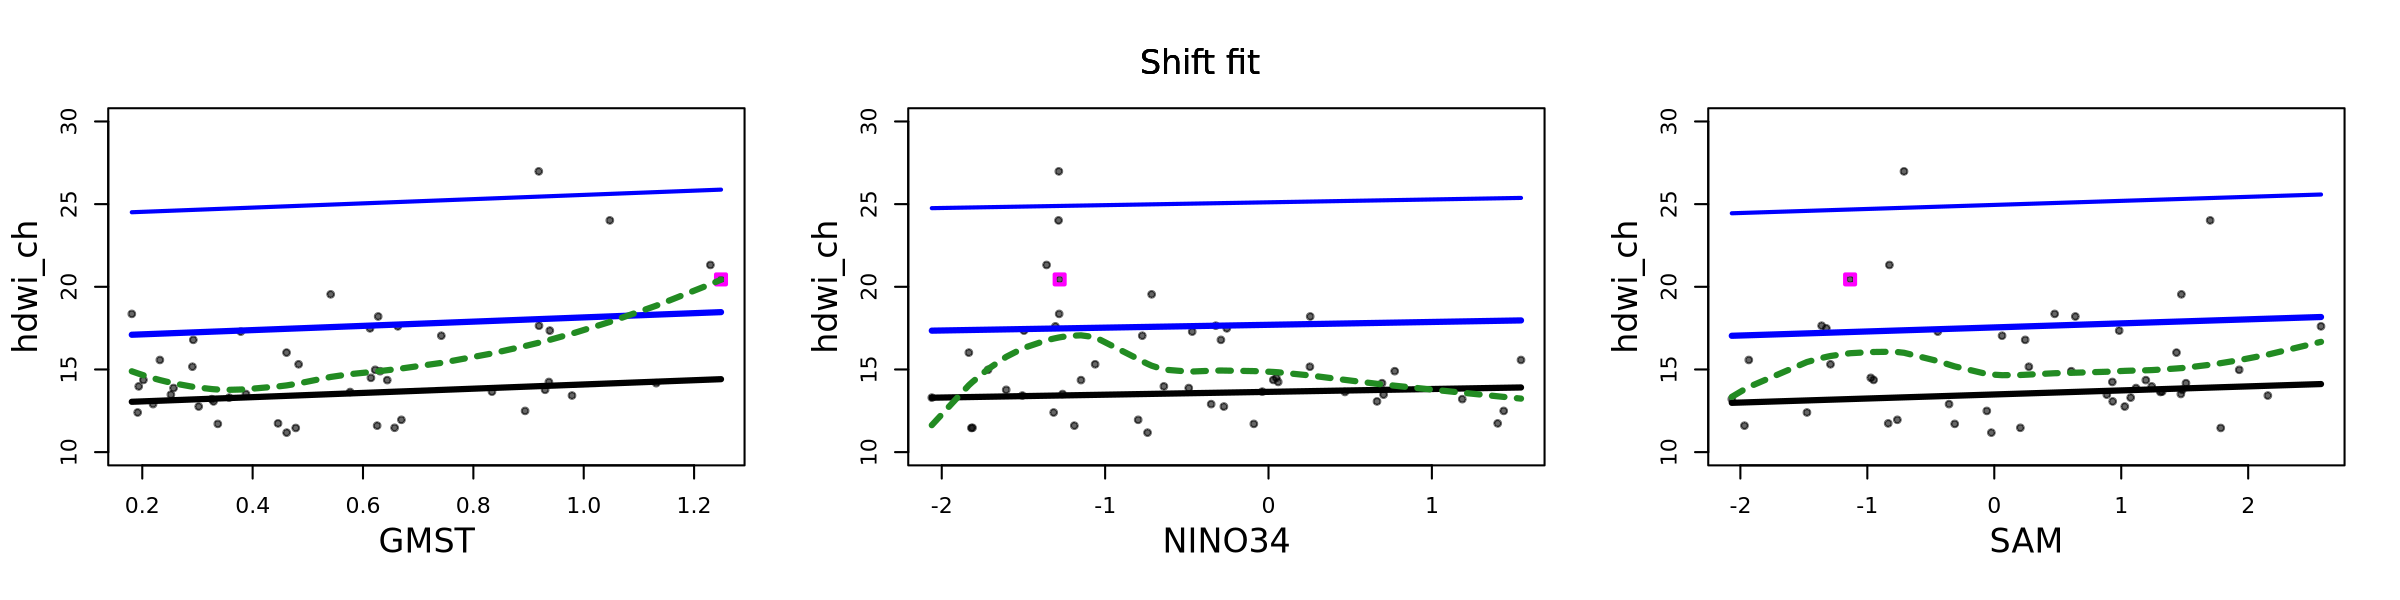

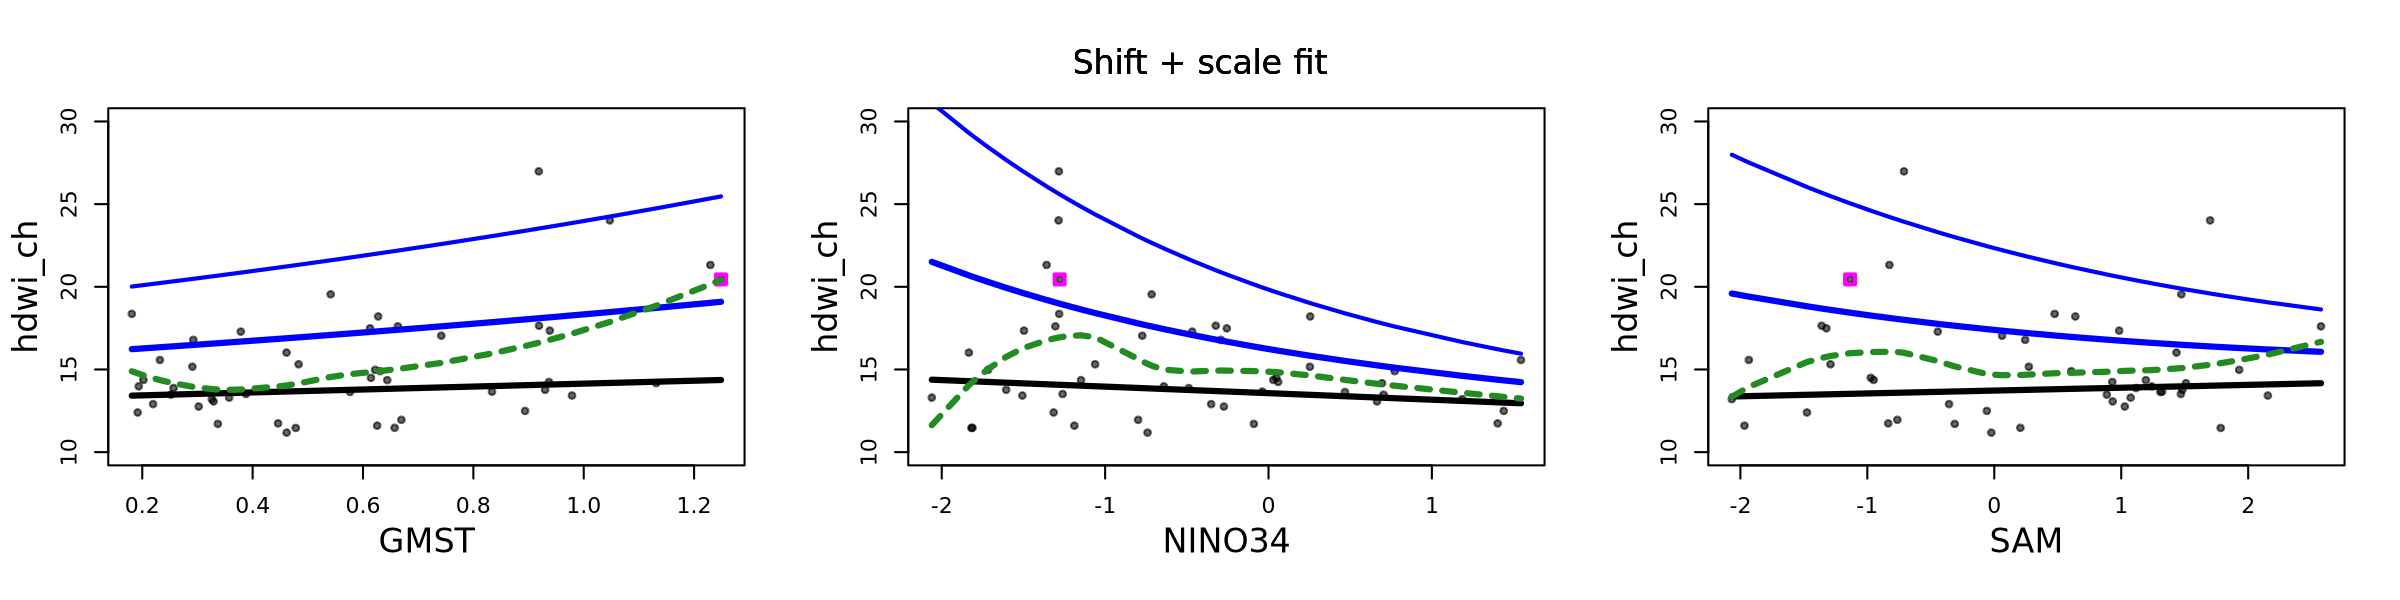

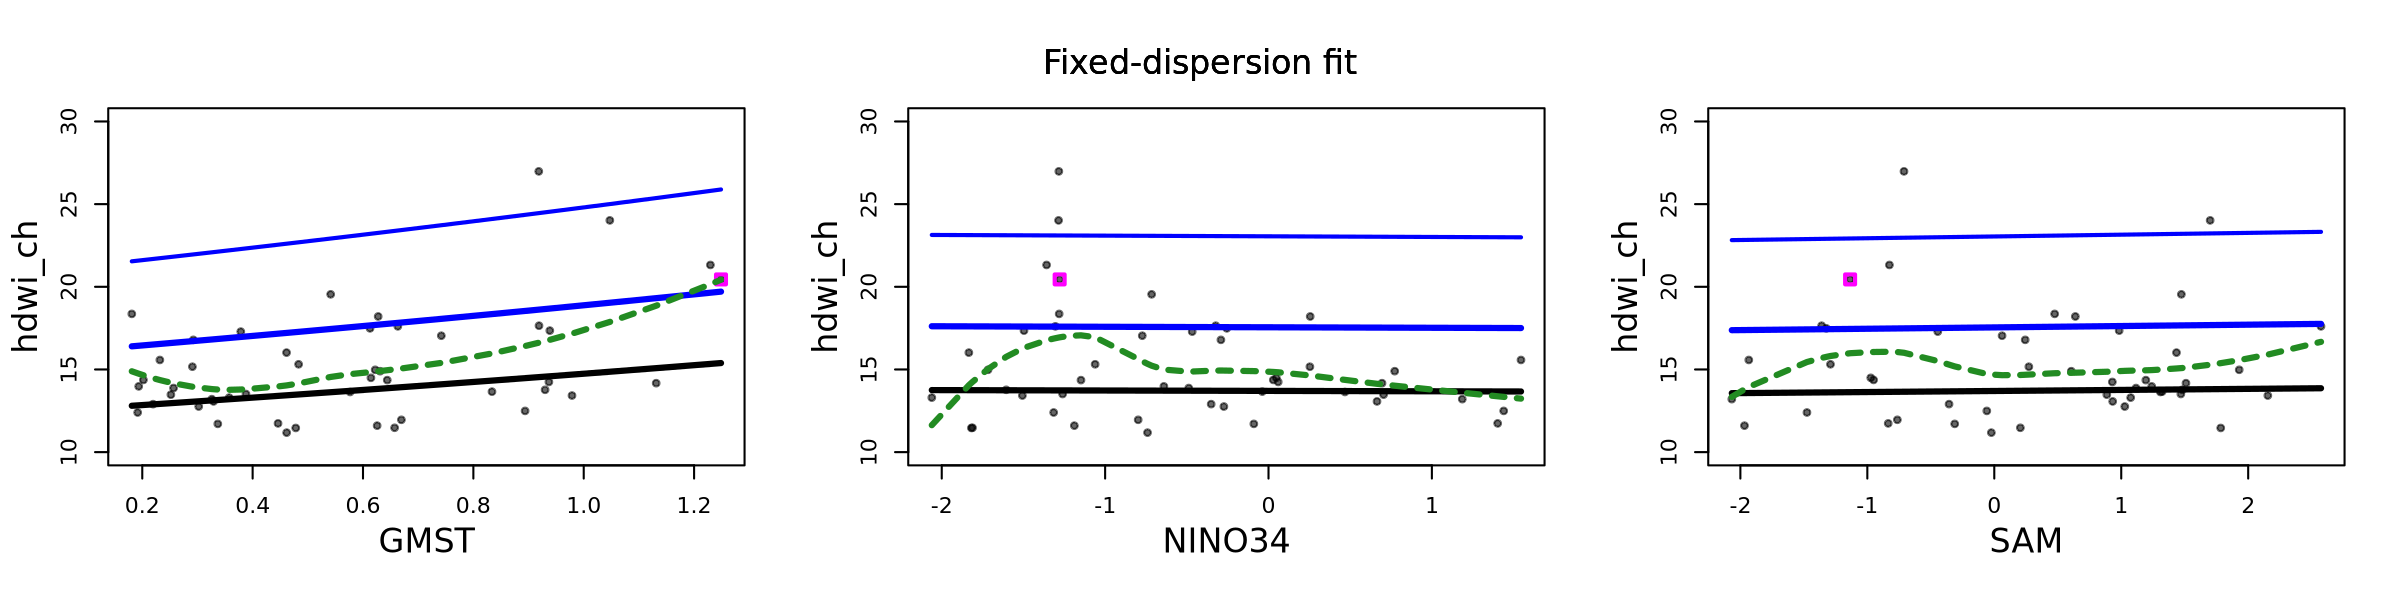

In [142]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shift[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift fit", side = 3, outer = T, line = -3)
}

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shiftscale[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift + scale fit", side = 3, outer = T, line = -3)
}

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_fixeddisp[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Fixed-dispersion fit", side = 3, outer = T, line = -3)
}

### Argentina

In [143]:
covar_list <- list("GMST only" = "gmst", "Nino only" = "nino34", "SAM only" = "sam",
                   "GMST + Nino" = c("gmst", "nino34"), "GMST + SAM" = c("gmst", "sam"), "GMST + Nino + SAM" = c("gmst", "nino34", "sam"))

# # fit all model variants
# args_chile <- list(dist = "gev", varnm = "hdwi_ch", data = df, lower = F)
# models_chile_shift <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shift"))), simplify = F)
# models_chile_fixeddisp <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "fixeddisp"))), simplify = F)
# models_chile_shiftscale <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale"))), simplify = F)
# models_chile_shiftscalelinear <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale_linear", method = "Nelder-Mead"))), simplify = F)

args_arg <- list(dist = "gev", varnm = "hdwi_ar", data = df, lower = F)
models_arg_shift <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_arg, list(covnm = covs, type = "shift"))), simplify = F)
models_arg_shiftscale <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_arg, list(covnm = covs, type = "shiftscale"))), simplify = F)

In [144]:
round(rbind(#"chile - shift" = sapply(models_chile_shift, aic),
      # "chile - fixed dispersion" = sapply(models_chile_fixeddisp, aic),
      # "chile - shift + scale" = sapply(models_chile_shiftscale, aic), 
      # "chile - shift + scale (linear)" = sapply(models_chile_shiftscalelinear, aic)#, 
      "argentina - shift" = sapply(models_arg_shift, aic),
      "argentina - shift + scale" = sapply(models_arg_shiftscale, aic)
     ), 2)

GMST only Nino only SAM only GMST + Nino GMST + SAM
argentina - shift         110.47    122.82    119.05   112.41      109.50    
argentina - shift + scale 112.44    124.80    119.84   116.38      111.46    
                          GMST + Nino + SAM
argentina - shift         110.60           
argentina - shift + scale 111.83

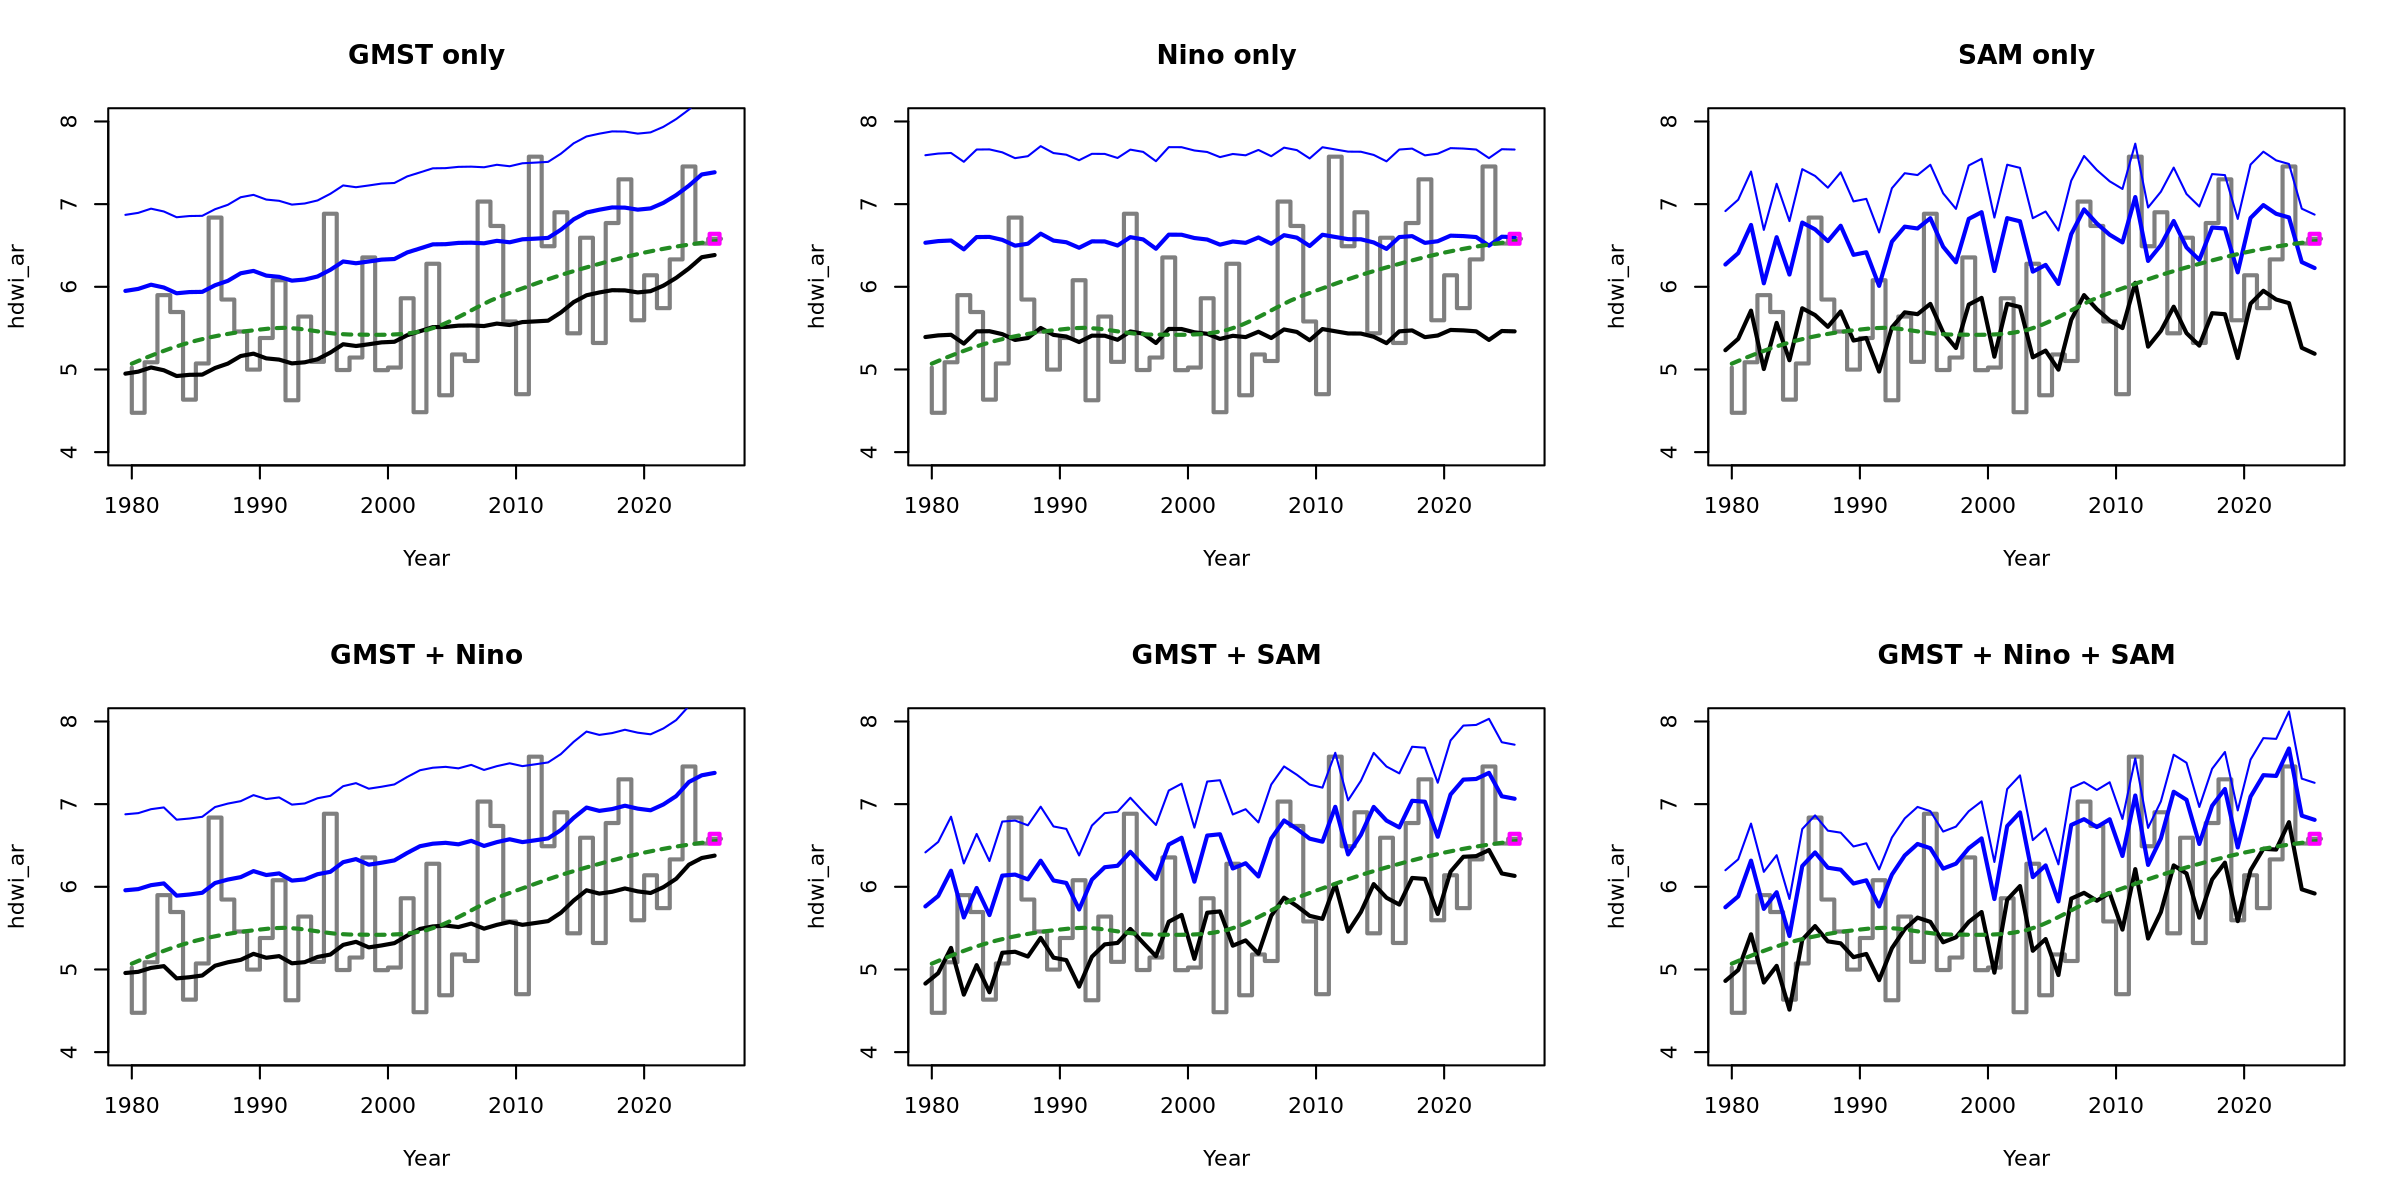

In [145]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_arg_shift)) {
    plot_trend(models_arg_shift[[m]], main = m, legend_pos = NA)
}

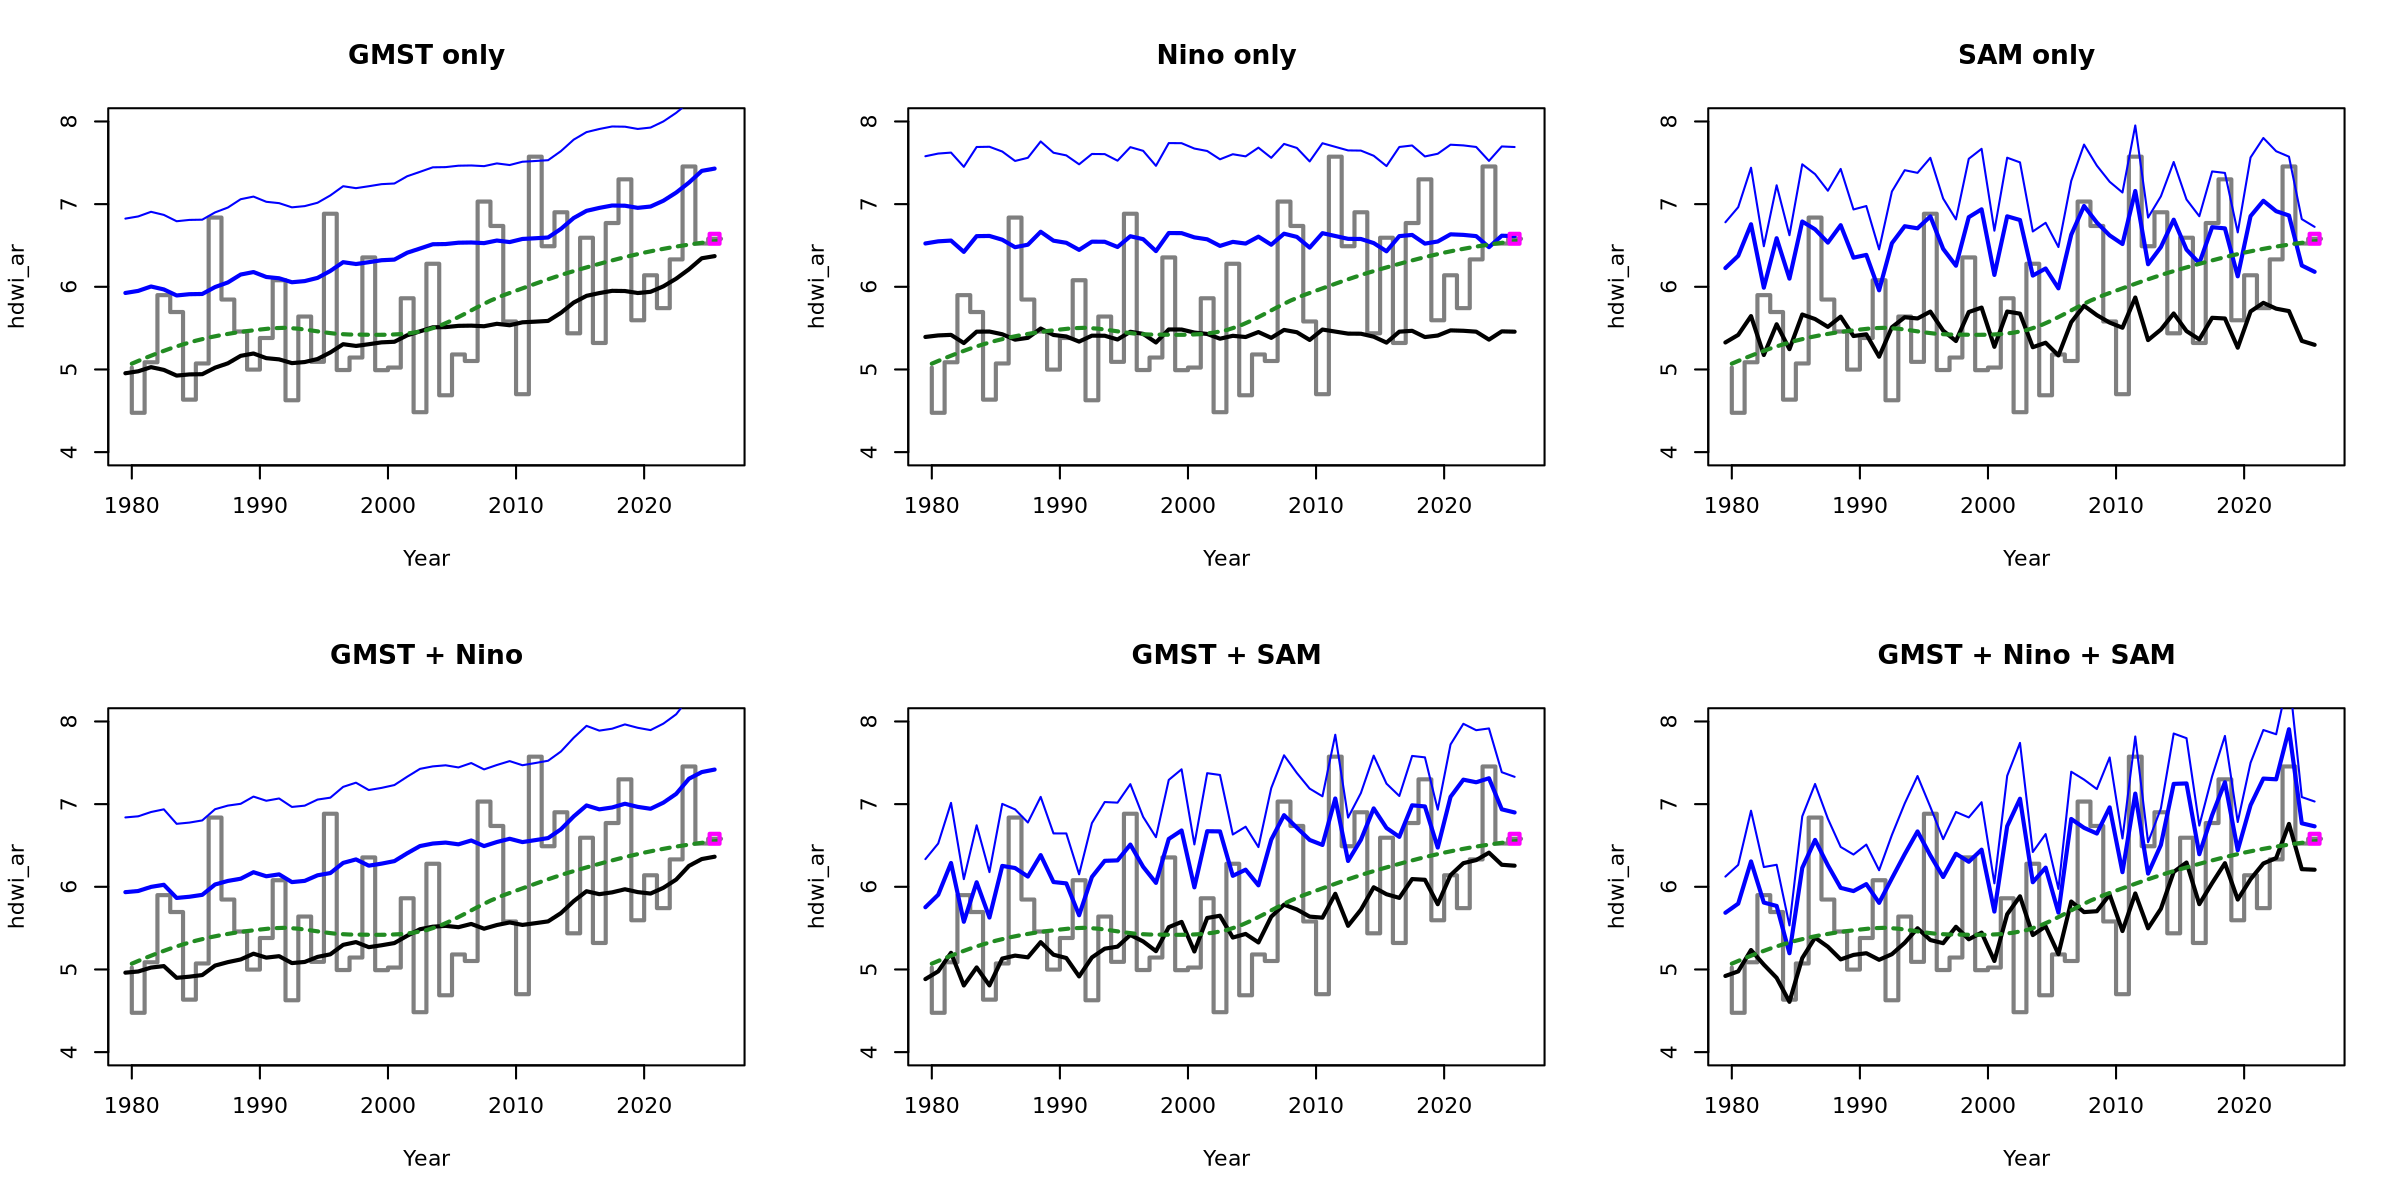

In [175]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_arg_shiftscale)) {
    plot_trend(models_arg_shiftscale[[m]], main = m, legend_pos = NA)
}

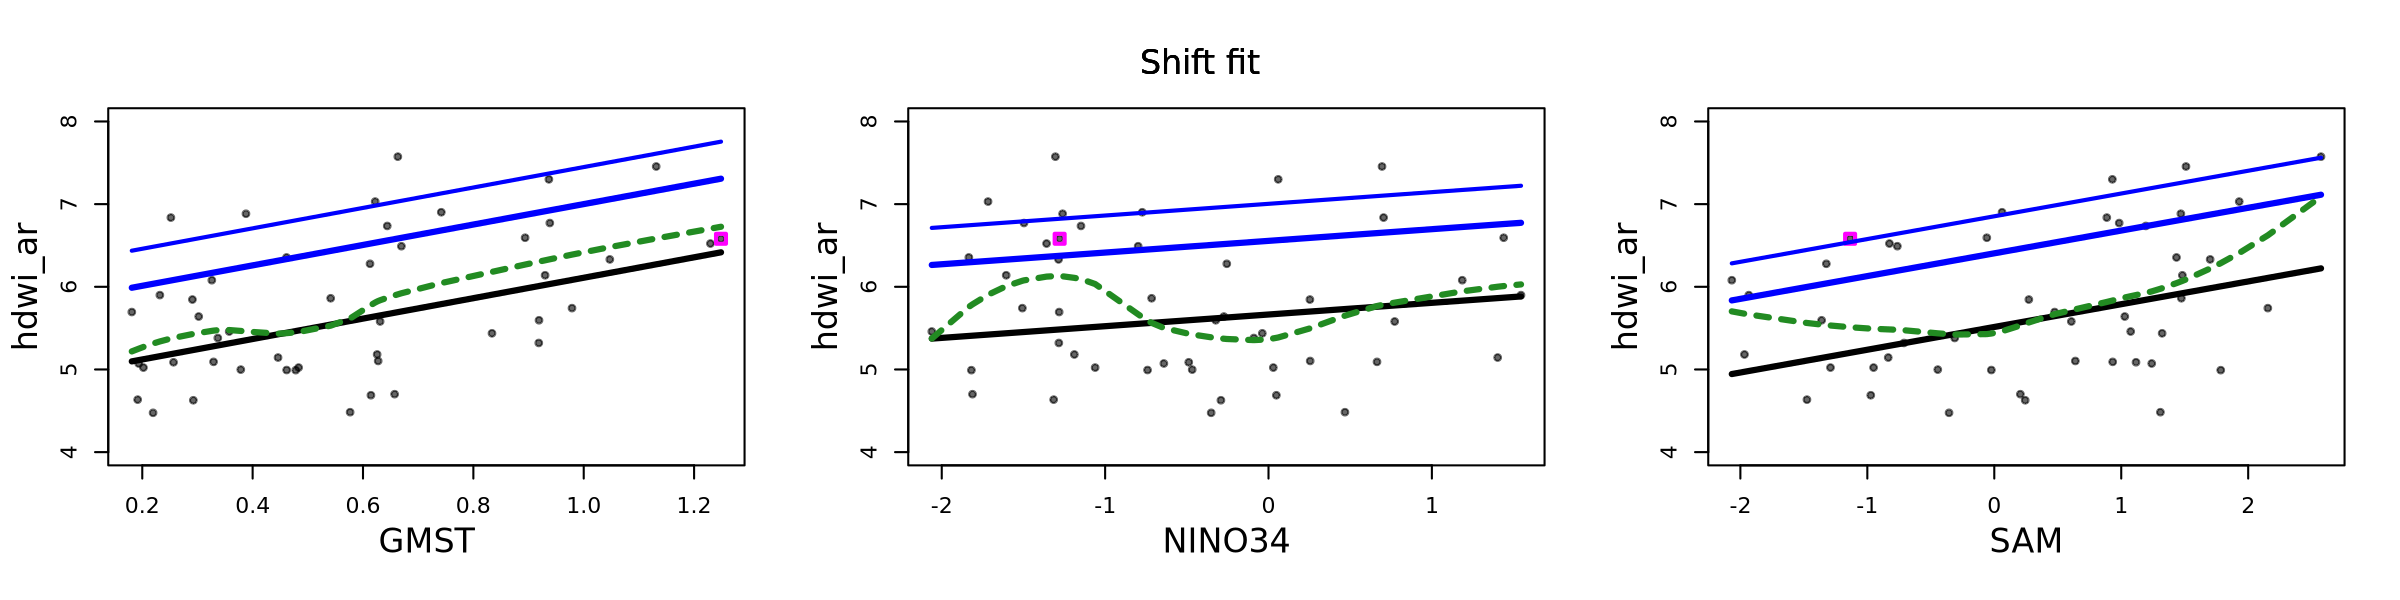

In [146]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_arg_shift[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift fit", side = 3, outer = T, line = -3)
}

# for (covnm in c("gmst", "nino34", "sam")) {
#     plot_covtrend(models_chile_shiftscale[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
#     mtext("Shift + scale fit", side = 3, outer = T, line = -3)
# }

# for (covnm in c("gmst", "nino34", "sam")) {
#     plot_covtrend(models_chile_fixeddisp[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
#     mtext("Fixed-dispersion fit", side = 3, outer = T, line = -3)
# }

# Exploratory analysis - precip

In [147]:
df <- merge(merge(merge(read.table("ts-obs/gmst-smoothed.dat", col.names = c("year", "gmst")),
                        load_ts("ts-obs/sam-fires_nino34det-ndj.dat", col.names = c("year", "nino34"))),
                  load_ts("ts-obs/sam-fires_sam-dec.dat", col.names = c("year", "sam"))),
            merge(load_ts(paste0("ts-obs/sam-fires_pr-ndj_chile2026_era5land.dat"), col.names = c("year", "pr_ch")),
                  load_ts(paste0("ts-obs/sam-fires_pr-ndj_patagonia_era5land.dat"), col.names = c("year", "pr_ar"))))

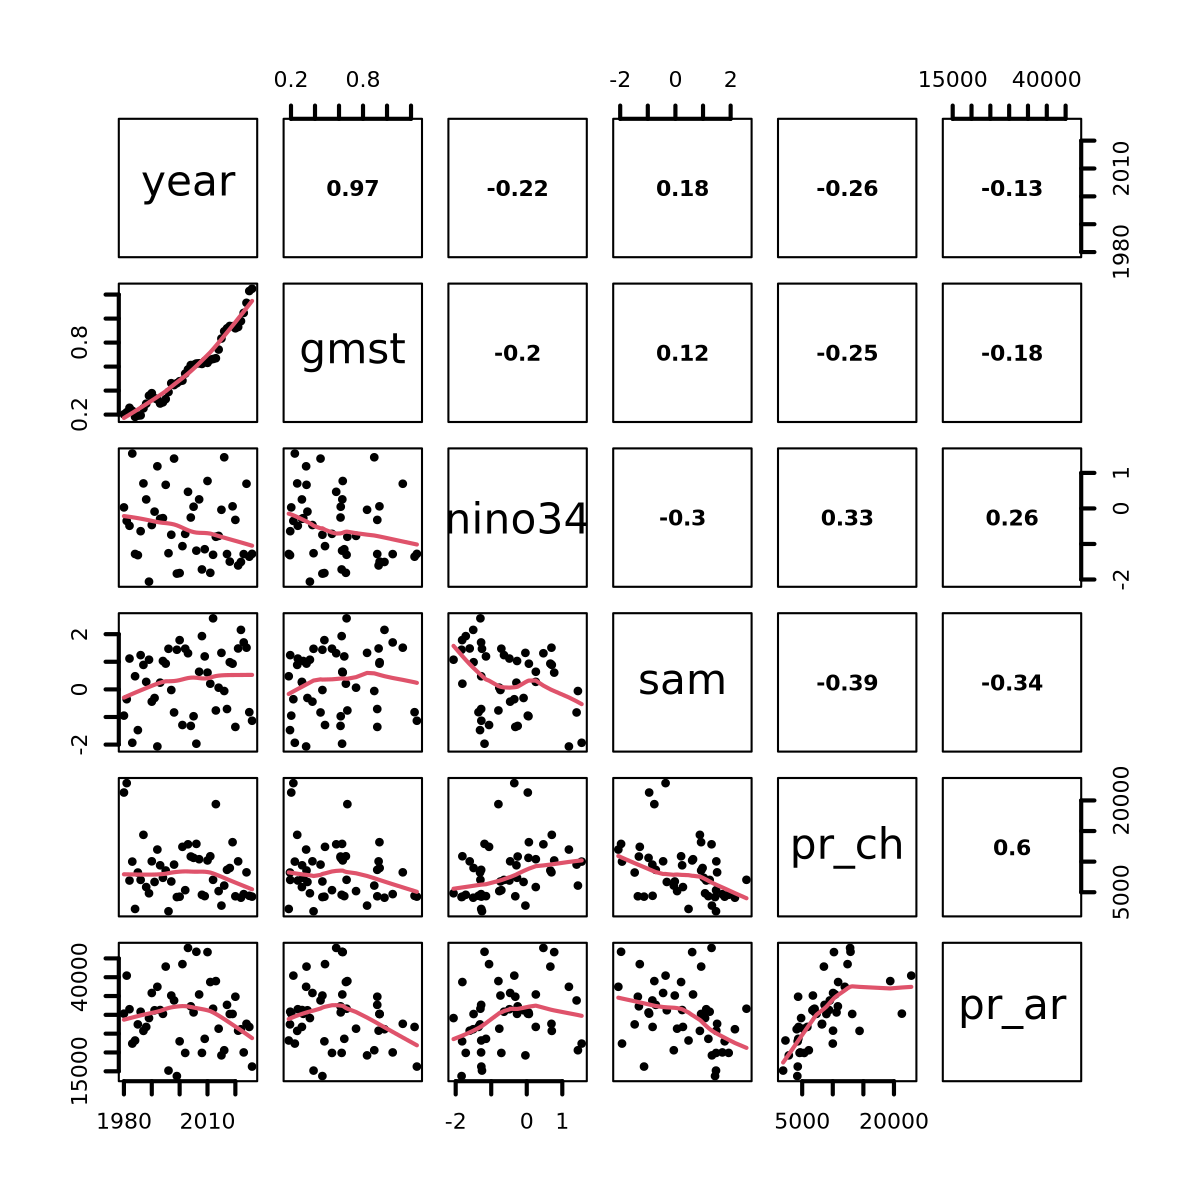

In [149]:
prep_window(h = 6, w = 6)
pairs(df, upper.panel = panel.cor, lower.panel = panel.smooth, lwd = 2)

## Check distributions

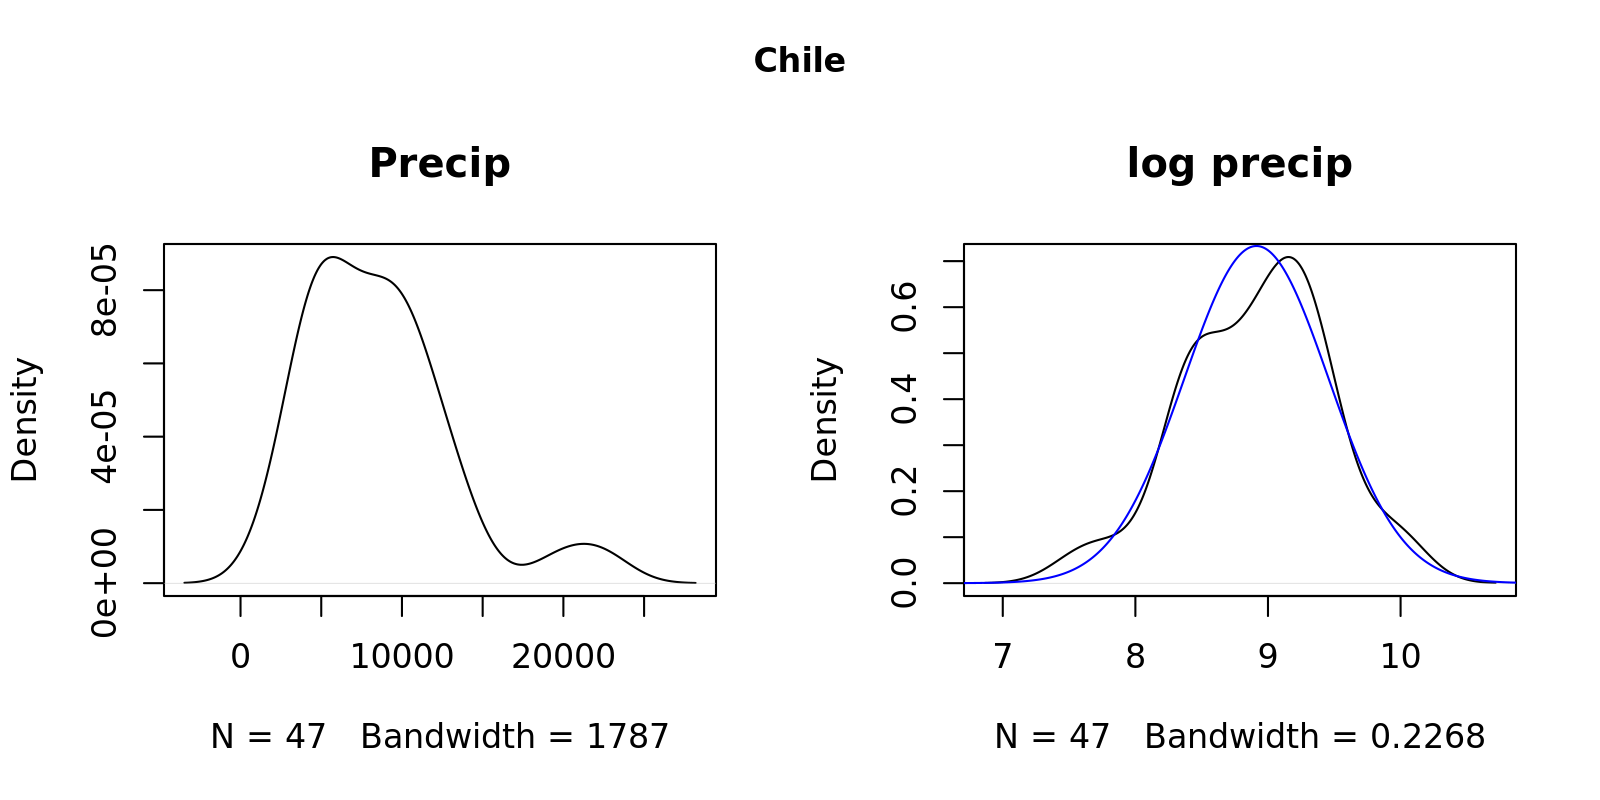

In [158]:
prep_window(c(1,2), oma = c(0,0,2,0))

plot(density(df$pr_ch), main = "Precip")

plot(density(log(df$pr_ch)), main = "log precip")
lines(x <- seq(6.5,11,0.01), dnorm(x, mean(log(df$pr_ch)), sd(log(df$pr_ch))), col = "blue")

mtext("Chile", side = 3, outer = T, font = 2)

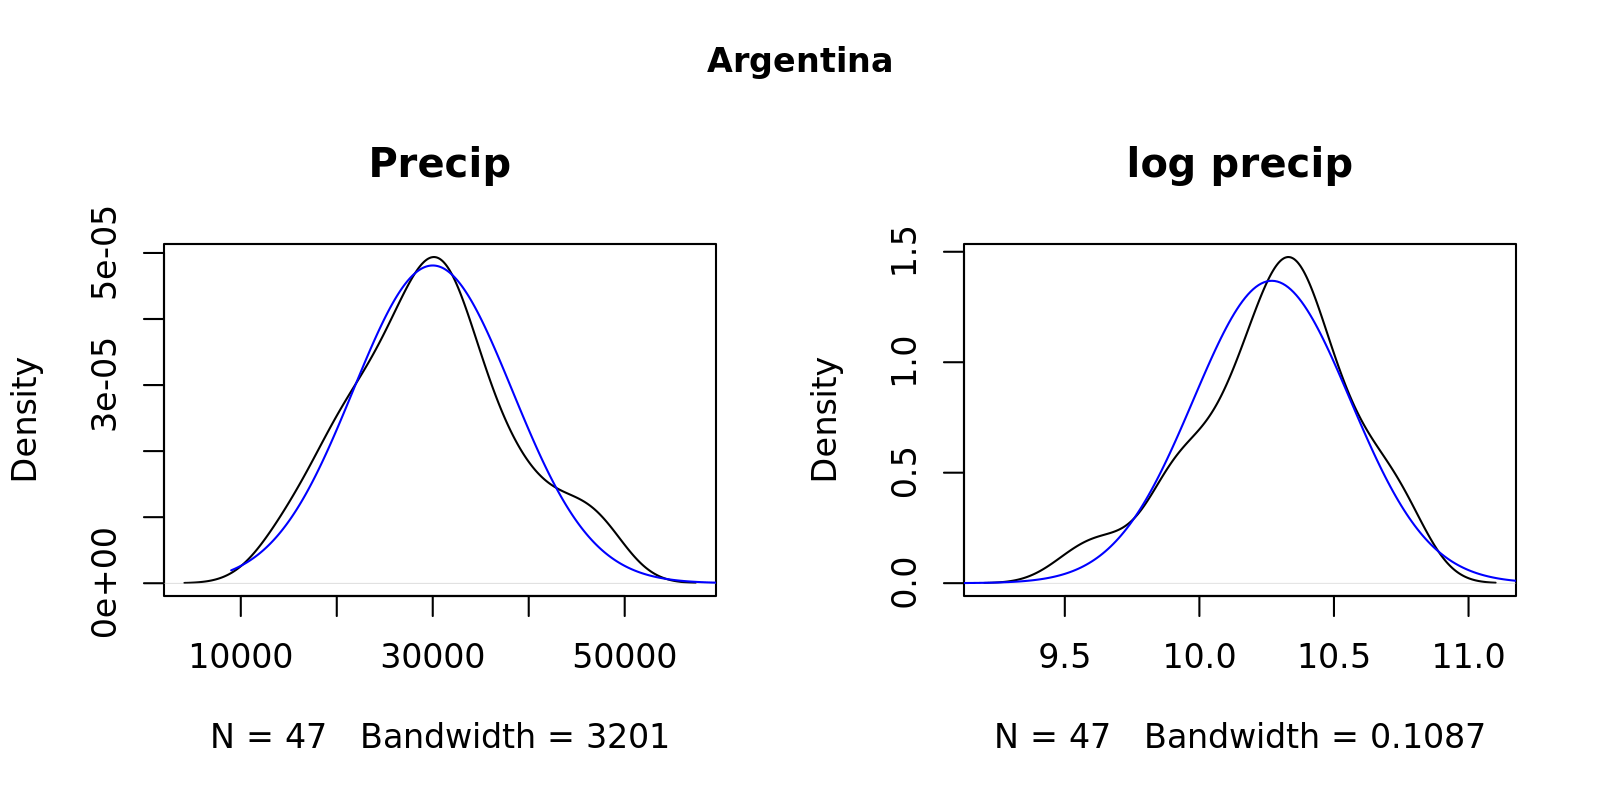

In [161]:
prep_window(c(1,2), oma = c(0,0,2,0))

plot(density(df$pr_ar), main = "Precip")
lines(x <- seq(9000,60000,100), dnorm(x, mean((df$pr_ar)), sd((df$pr_ar))), col = "blue")

plot(density(log(df$pr_ar)), main = "log precip")
lines(x <- seq(8,12,0.01), dnorm(x, mean(log(df$pr_ar)), sd(log(df$pr_ar))), col = "blue")

mtext("Argentina", side = 3, outer = T, font = 2)

## Model selection

### Chile

In [170]:
covar_list <- list("GMST only" = "gmst", "Nino only" = "nino34", "SAM only" = "sam",
                   "GMST + Nino" = c("gmst", "nino34"), "GMST + SAM" = c("gmst", "sam"), "GMST + Nino + SAM" = c("gmst", "nino34", "sam"))

# fit all model variants
df$logpr_ch <- log(df$pr_ch)

args_chile <- list(data = df, lower = T)
models_chile_normlogt <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, varnm = "pr_ch", type = "shift", dist = "norm_logt"))), simplify = F)
models_chile_logpr <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, varnm = "logpr_ch", type = "shift", dist = "norm"))), simplify = F)

In [168]:
round(rbind("chile - normlogt" = sapply(models_chile_shift, aic)), 2)

GMST only Nino only SAM only GMST + Nino GMST + SAM
chile - normlogt 917.1     911.37    910.51   912.51      911.17    
                 GMST + Nino + SAM
chile - normlogt 909.28

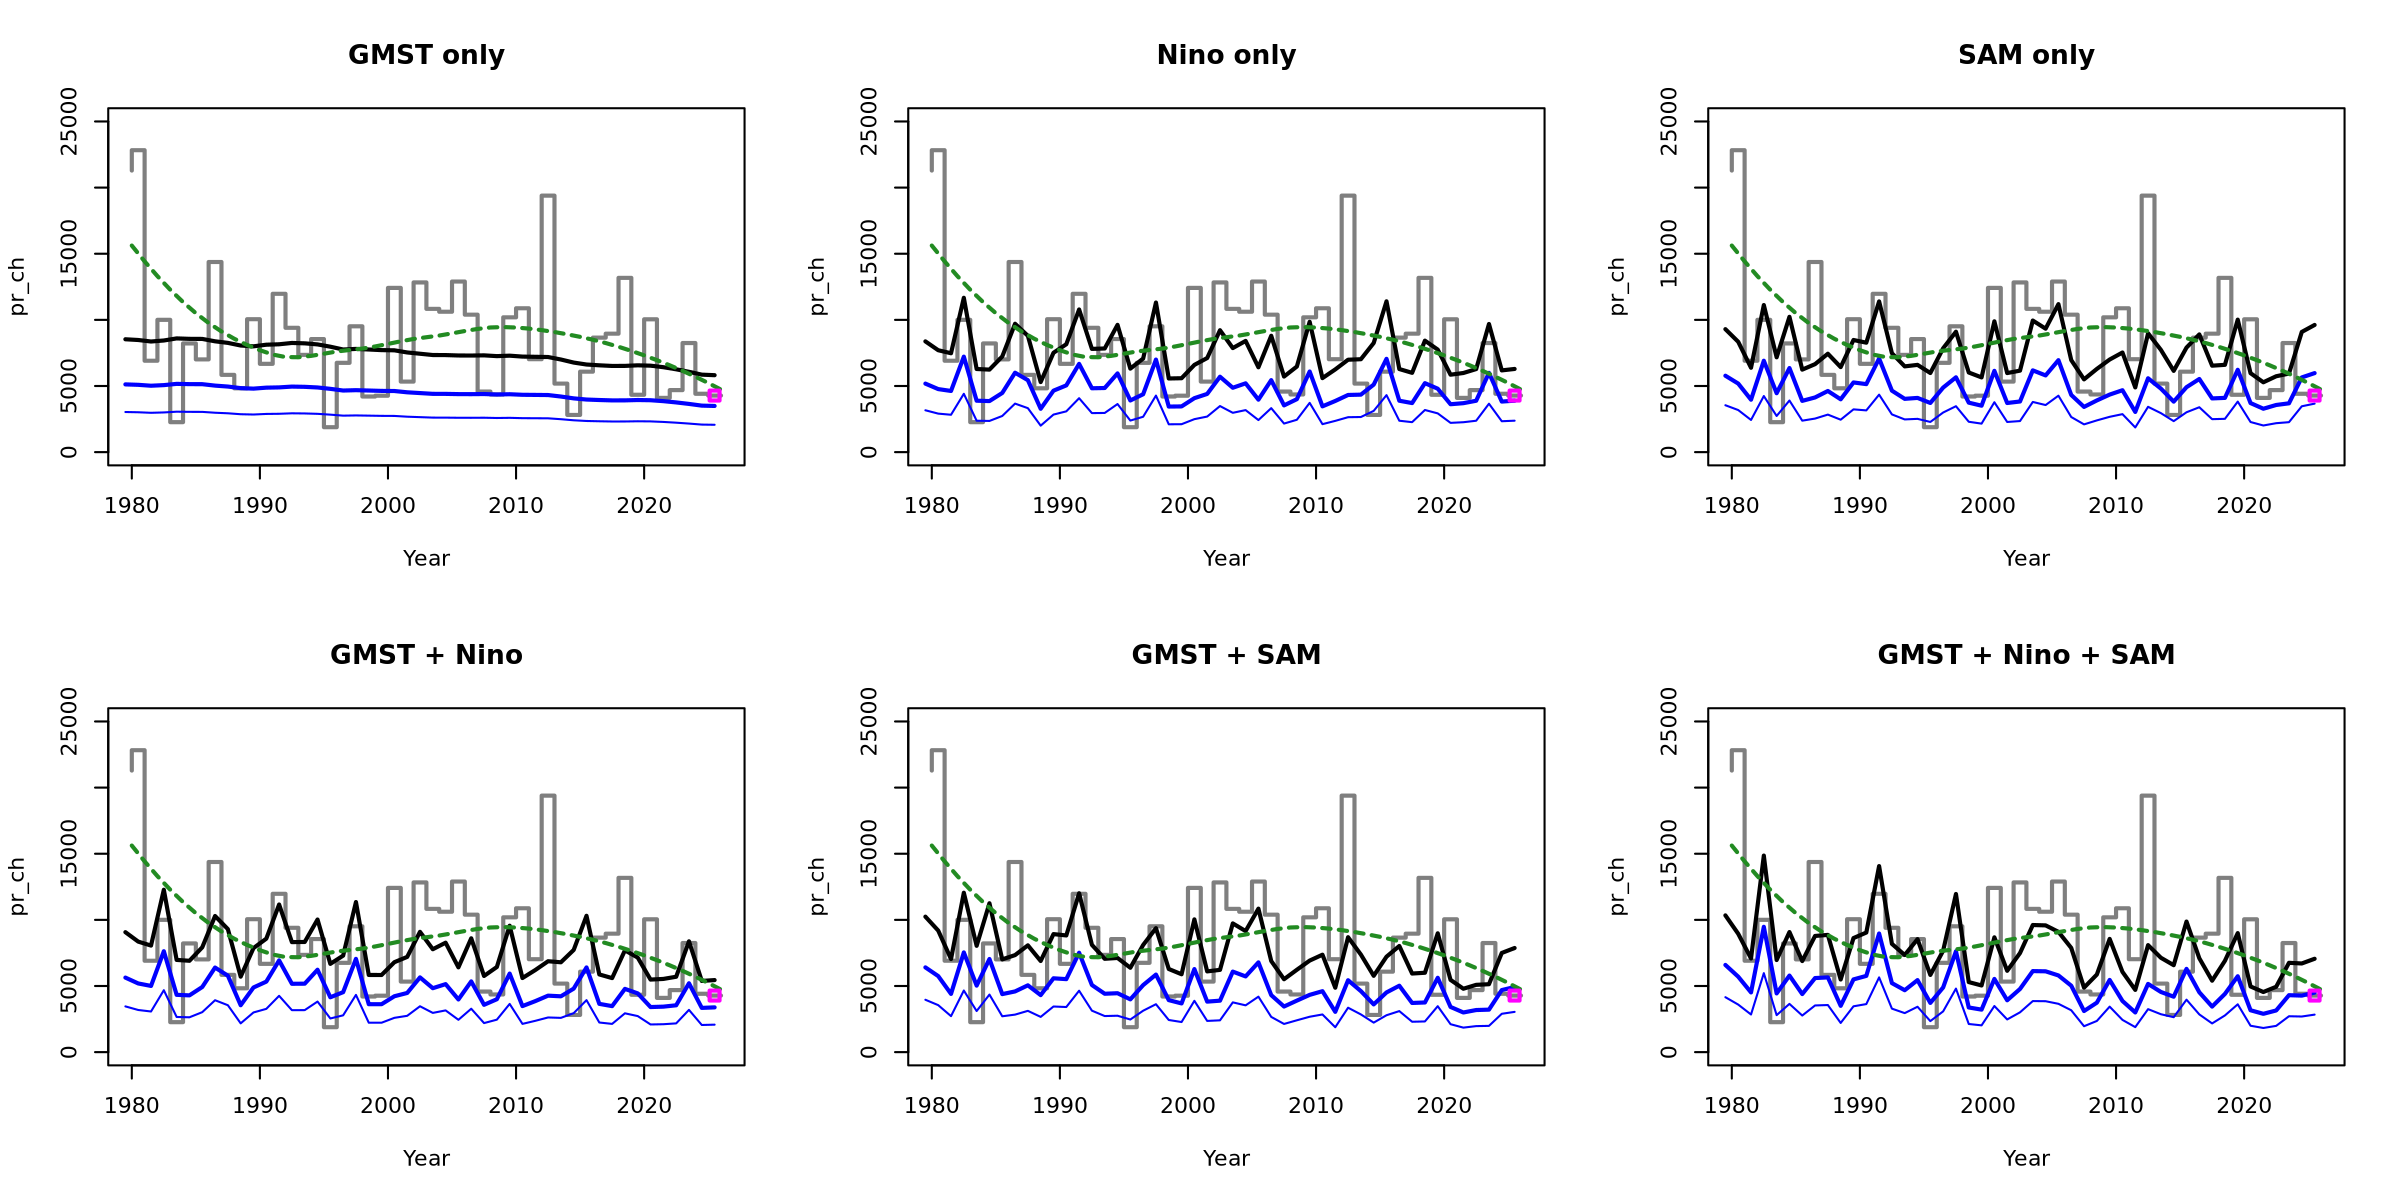

In [171]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_chile_normlogt)) {
    plot_trend(models_chile_normlogt[[m]], main = m, legend_pos = NA)
}

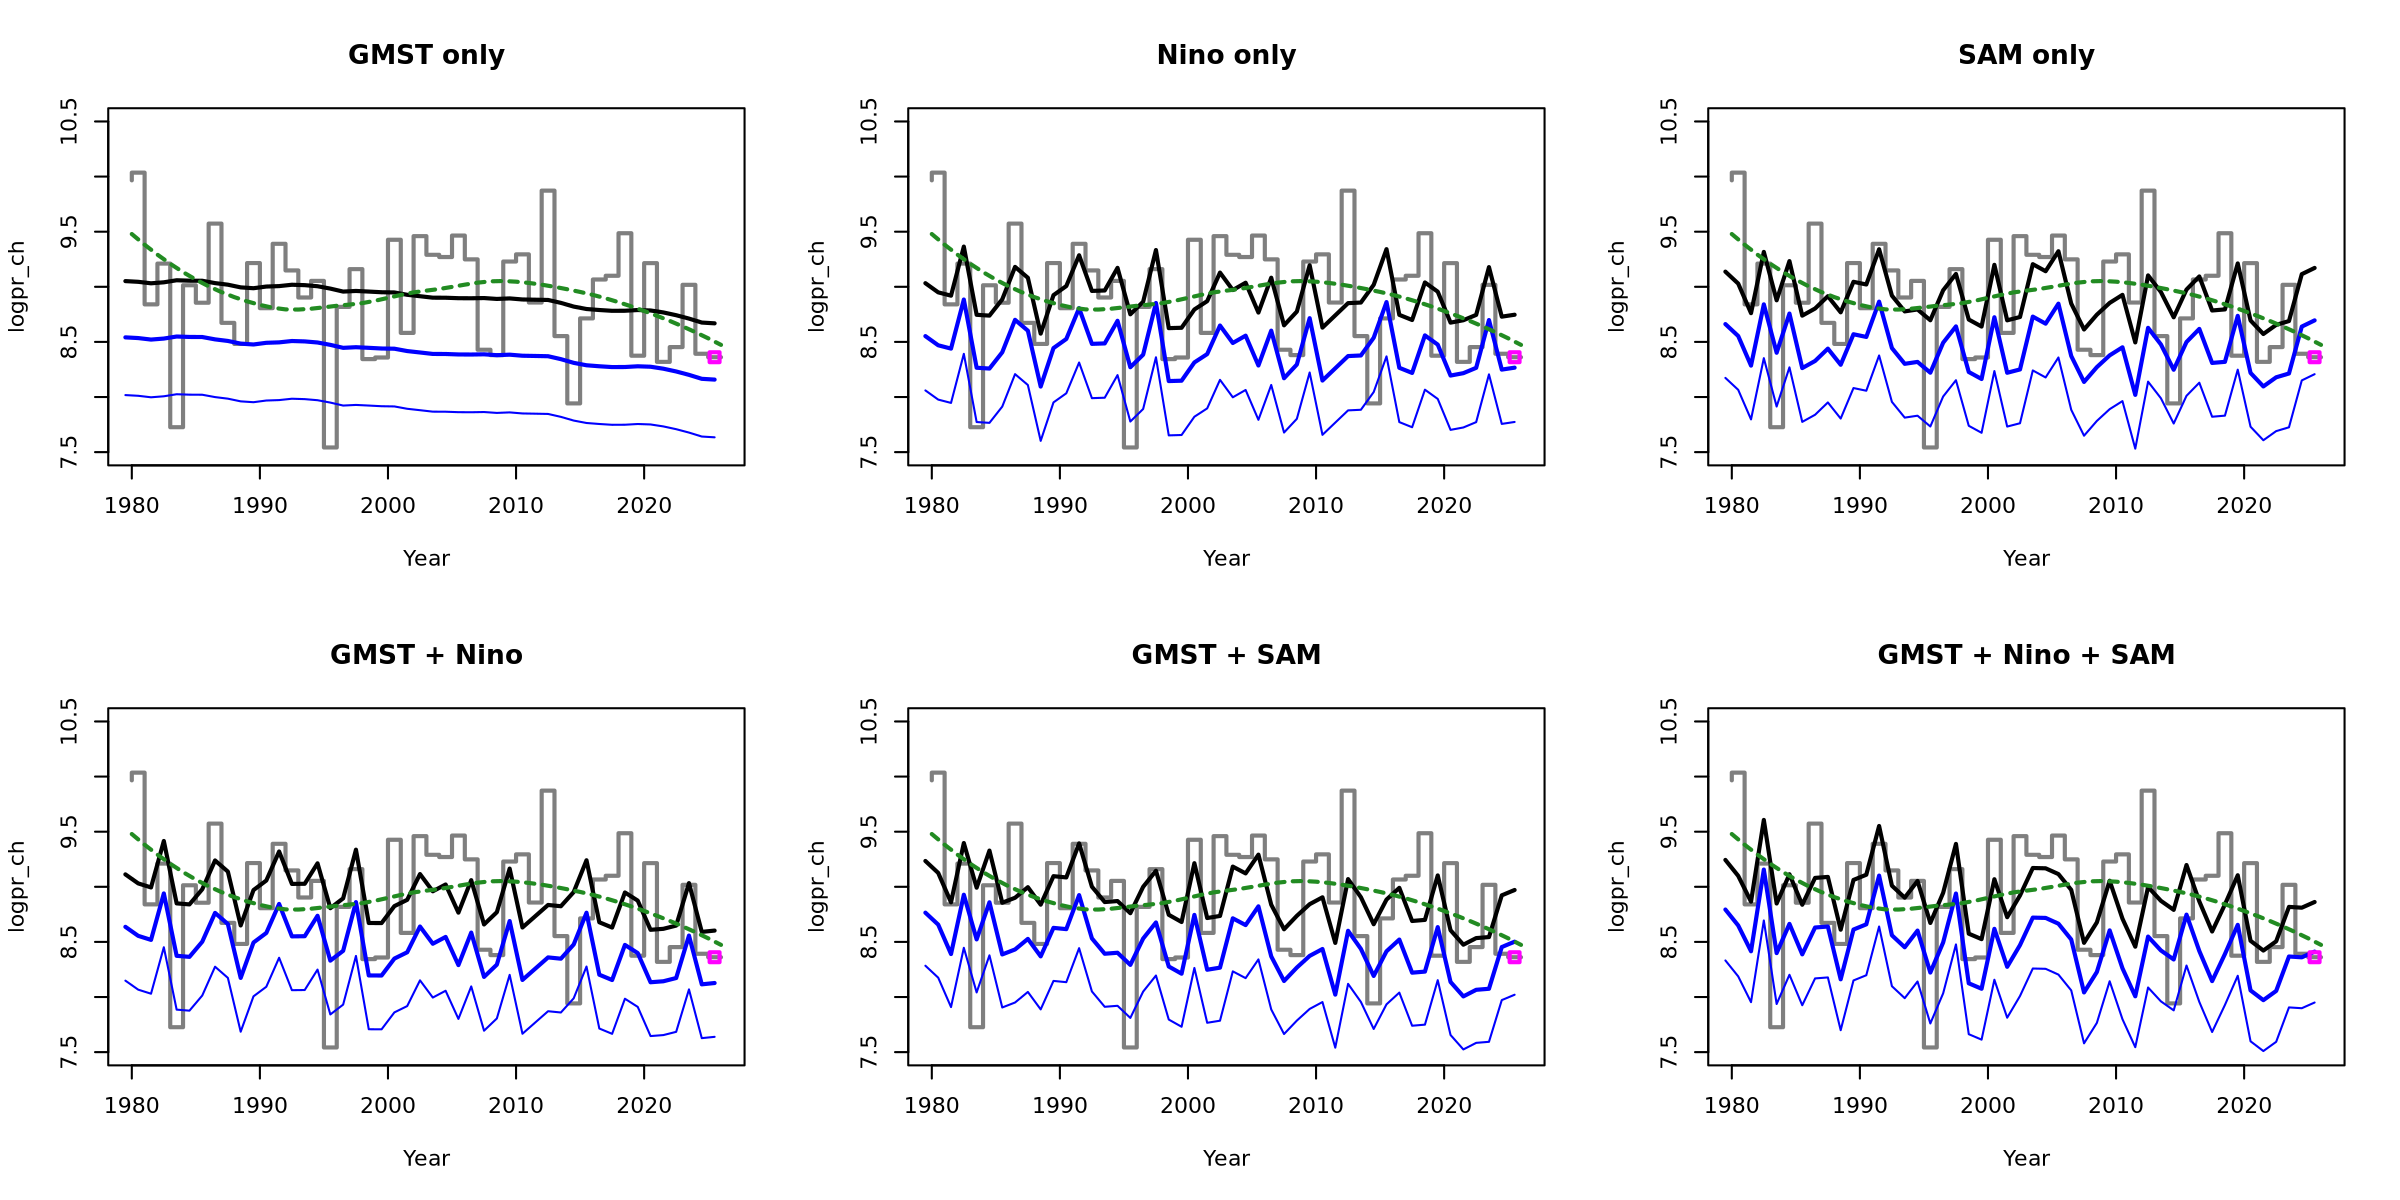

In [172]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_chile_logpr)) {
    plot_trend(models_chile_logpr[[m]], main = m, legend_pos = NA)
}

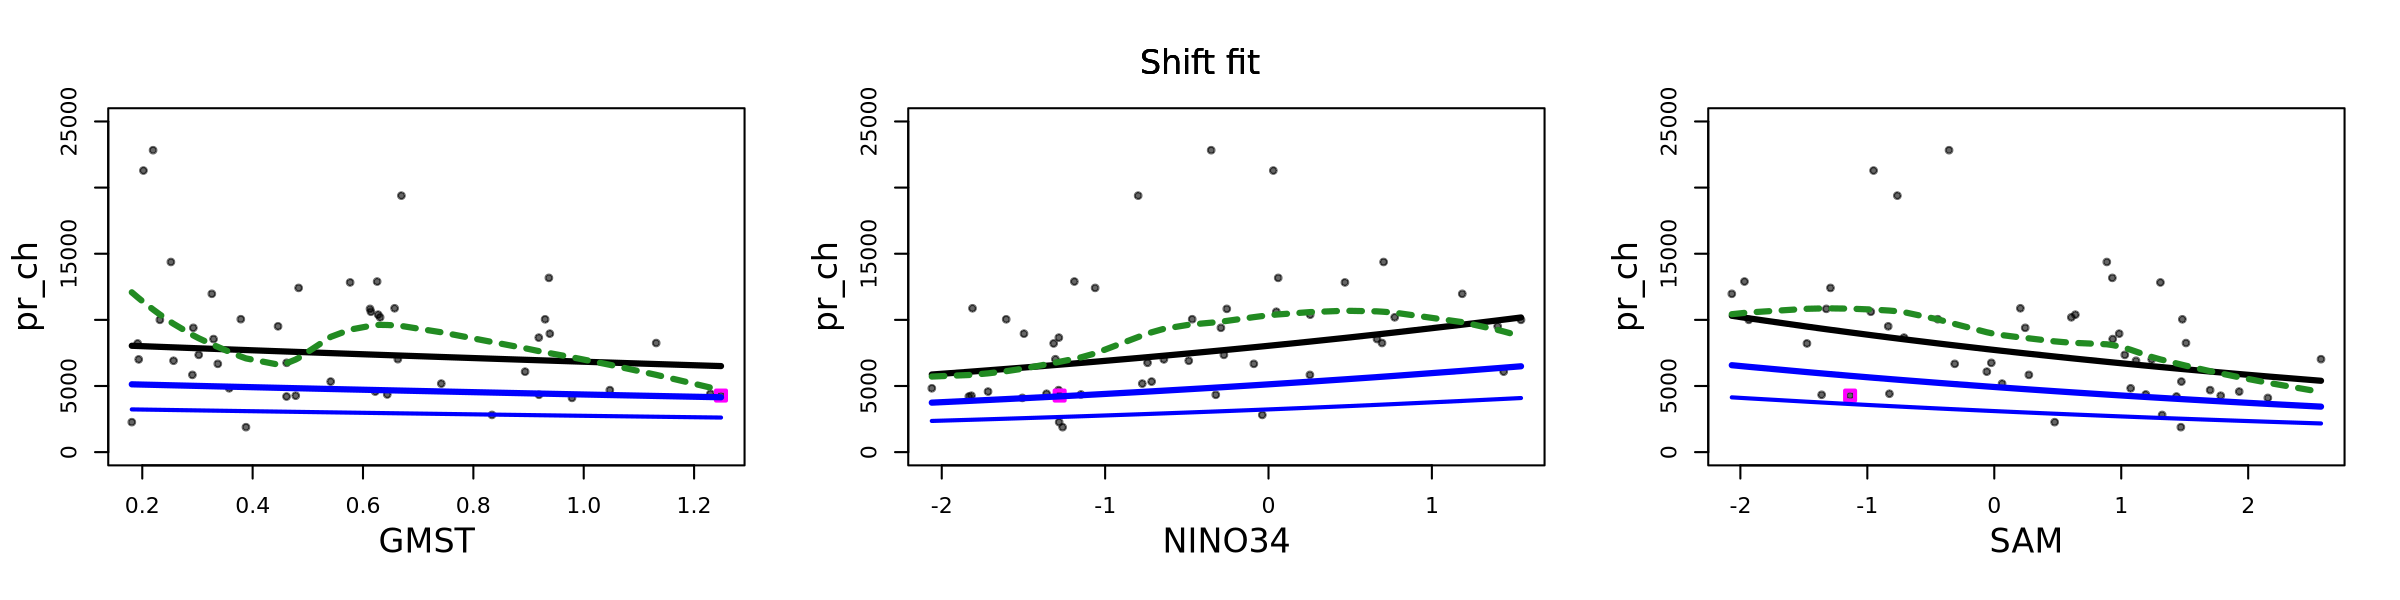

In [173]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shift[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift fit", side = 3, outer = T, line = -3)
}

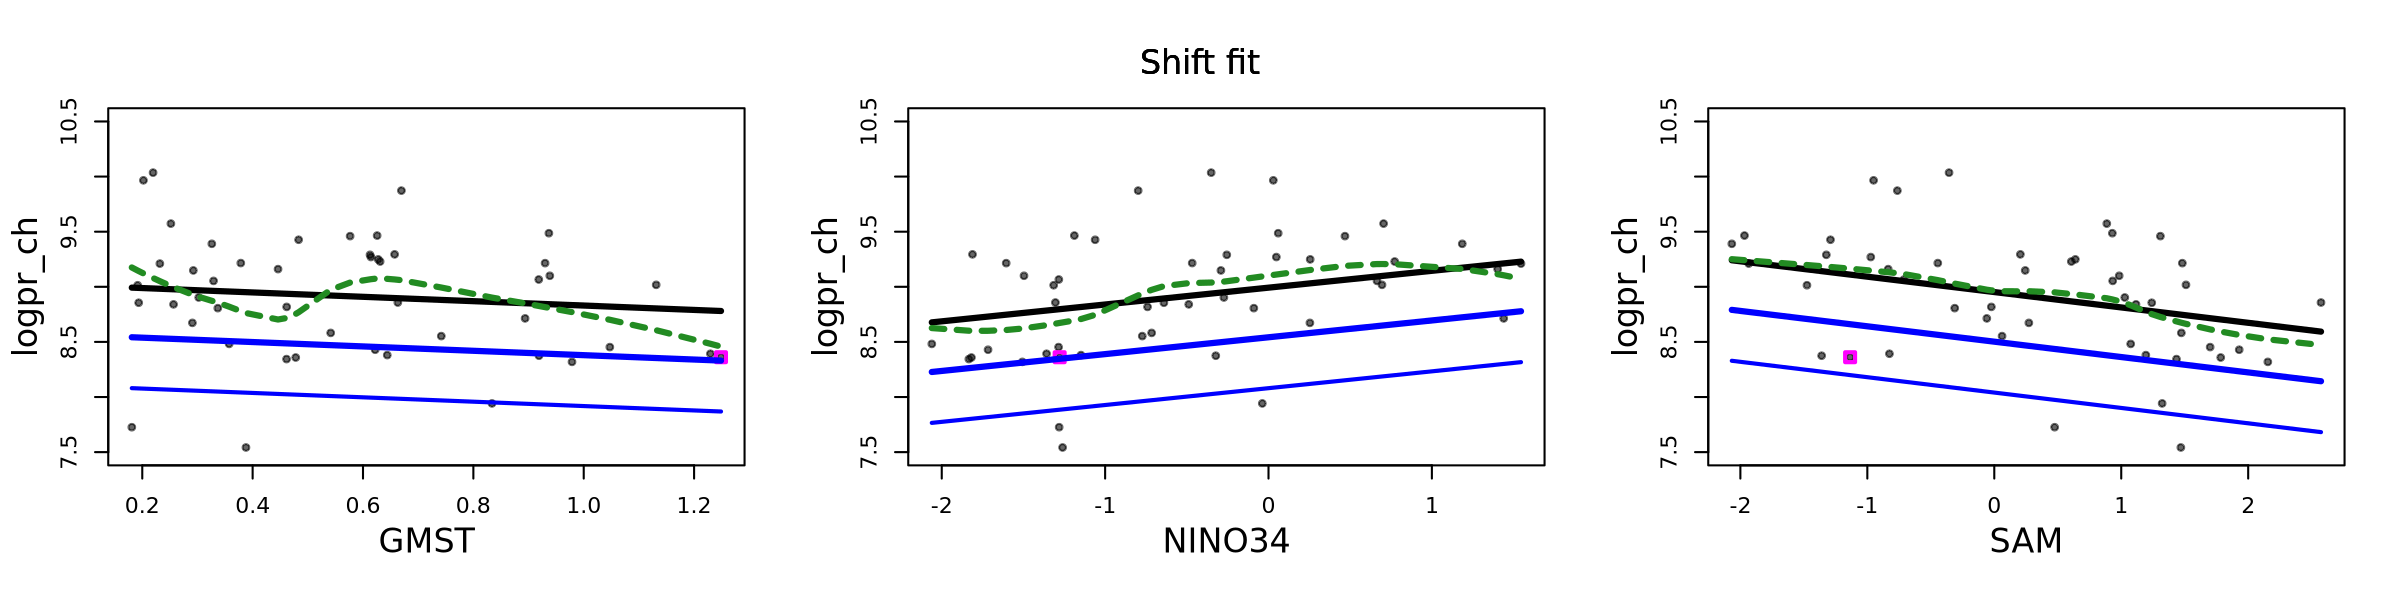

In [174]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_logpr[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift fit", side = 3, outer = T, line = -3)
}

### Argentina

In [182]:
covar_list <- list("GMST only" = "gmst", "Nino only" = "nino34", "SAM only" = "sam",
                   "GMST + Nino" = c("gmst", "nino34"), "GMST + SAM" = c("gmst", "sam"), "GMST + Nino + SAM" = c("gmst", "nino34", "sam"))

# fit all model variants
df$logpr_ar <- log(df$pr_ar)

In [ ]:
args_arg <- list(data = df, lower = T)
models_arg_norm <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, varnm = "pr_ar", type = "fixeddisp", dist = "norm"))), simplify = F)
models_arg_normlogt <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, varnm = "pr_ar", type = "shift", dist = "norm_logt"))), simplify = F)

In [188]:
round(rbind("argentina - normlogt" = sapply(models_arg_normlogt, aic),
            "argentina - fixeddispersion, normal" = sapply(models_arg_norm, aic)), 2)

GMST only Nino only SAM only GMST + Nino
argentina - normlogt                986.13    984.24    981.96   985.32     
argentina - fixeddispersion, normal 986.57    986.57    986.57   988.57     
                                    GMST + SAM GMST + Nino + SAM
argentina - normlogt                982.80     983.55           
argentina - fixeddispersion, normal 988.57     990.57

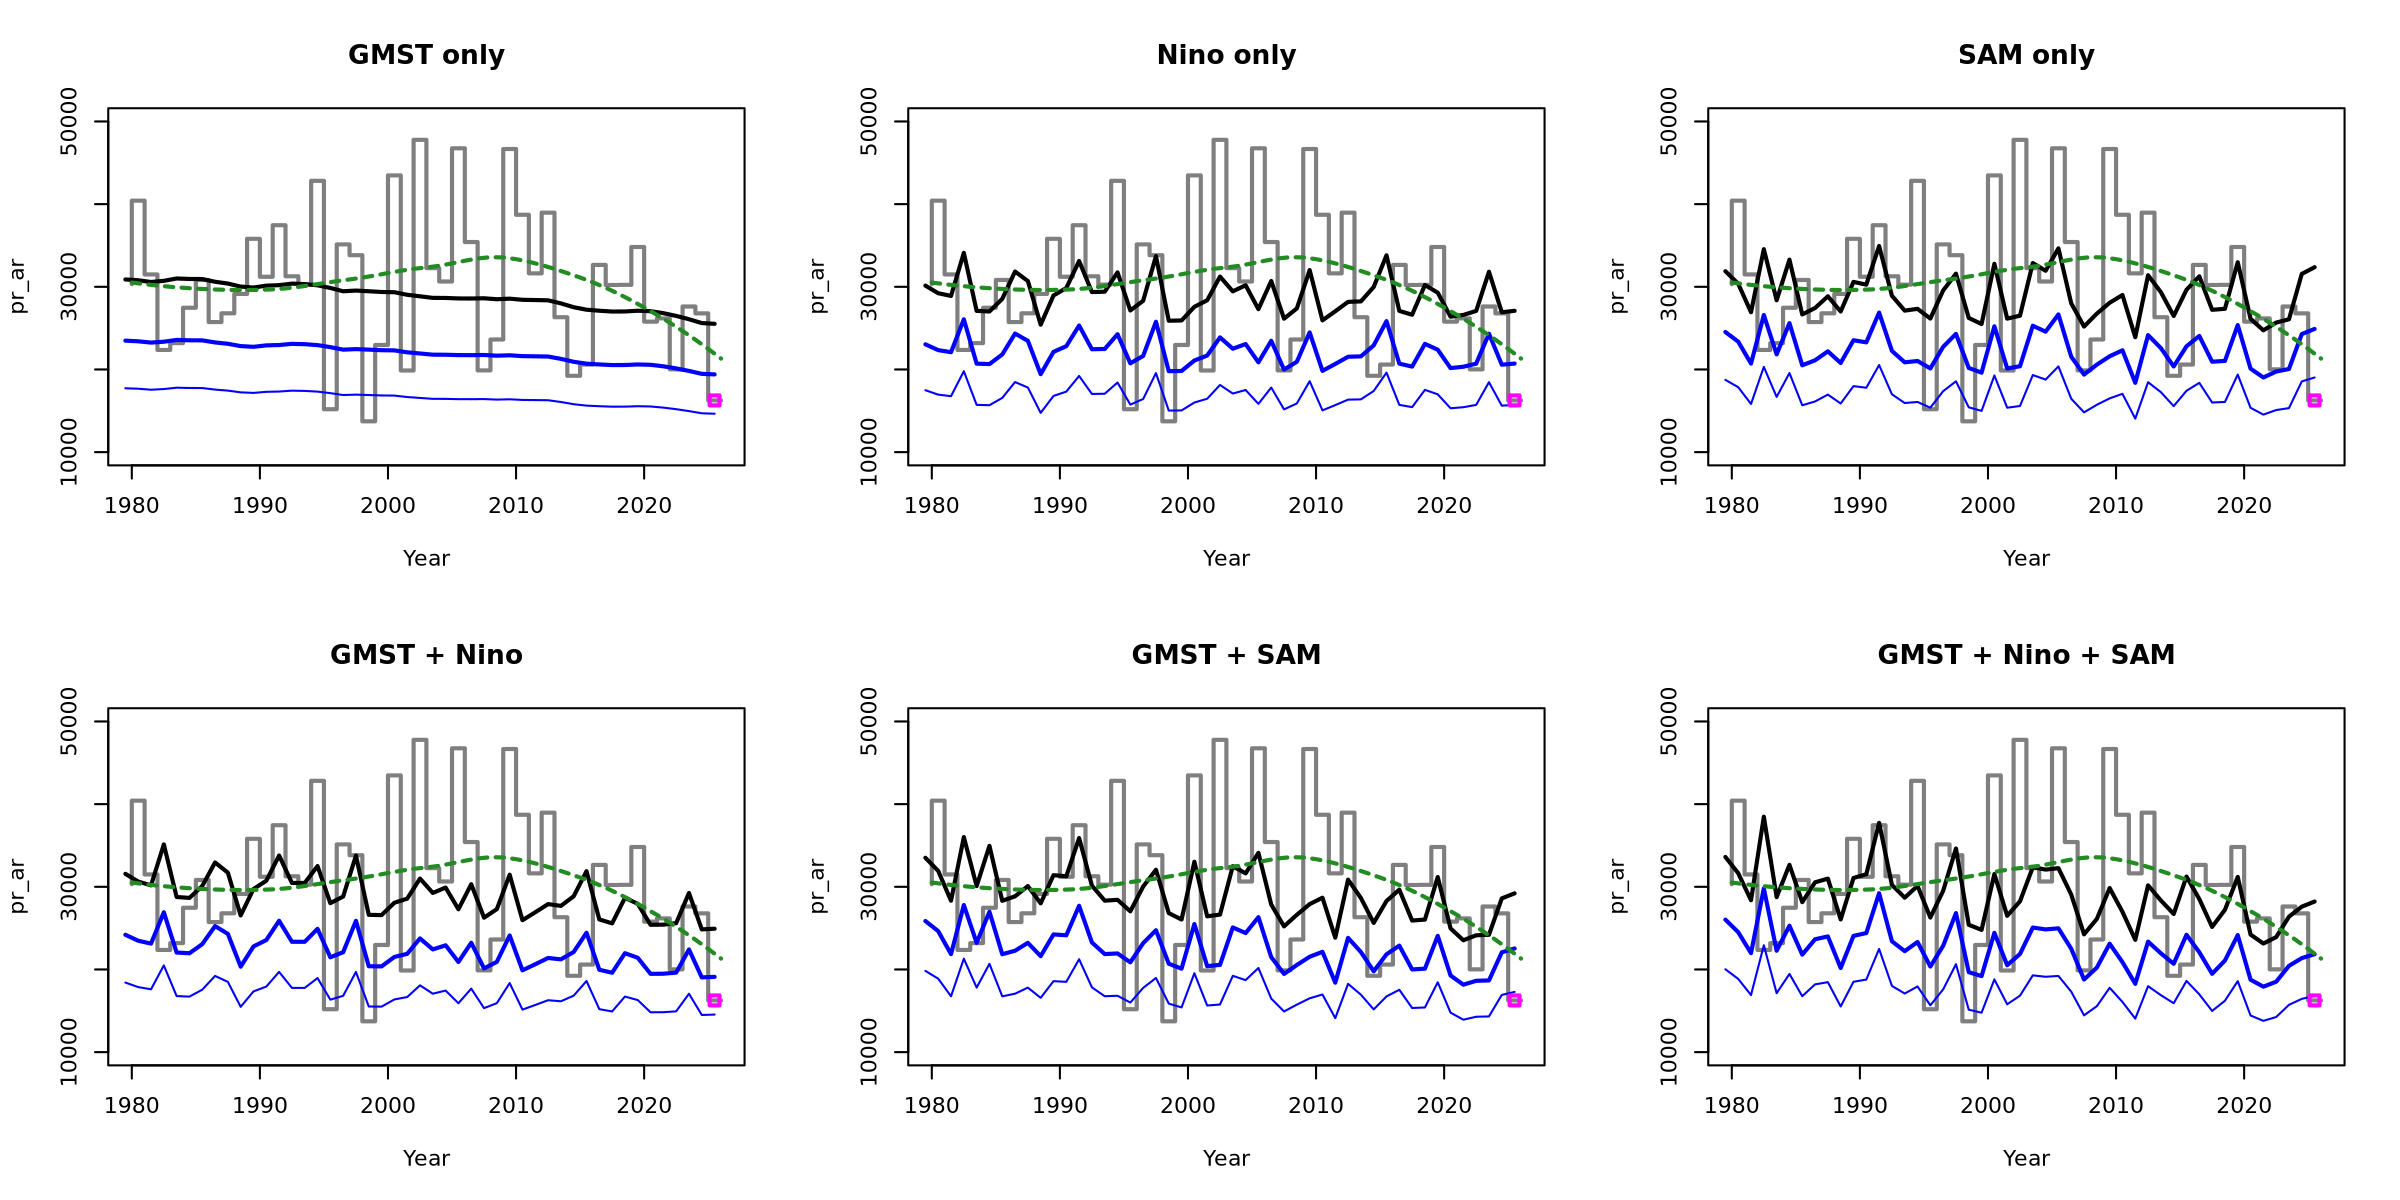

In [189]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_arg_normlogt)) {
    plot_trend(models_arg_normlogt[[m]], main = m, legend_pos = NA)
}

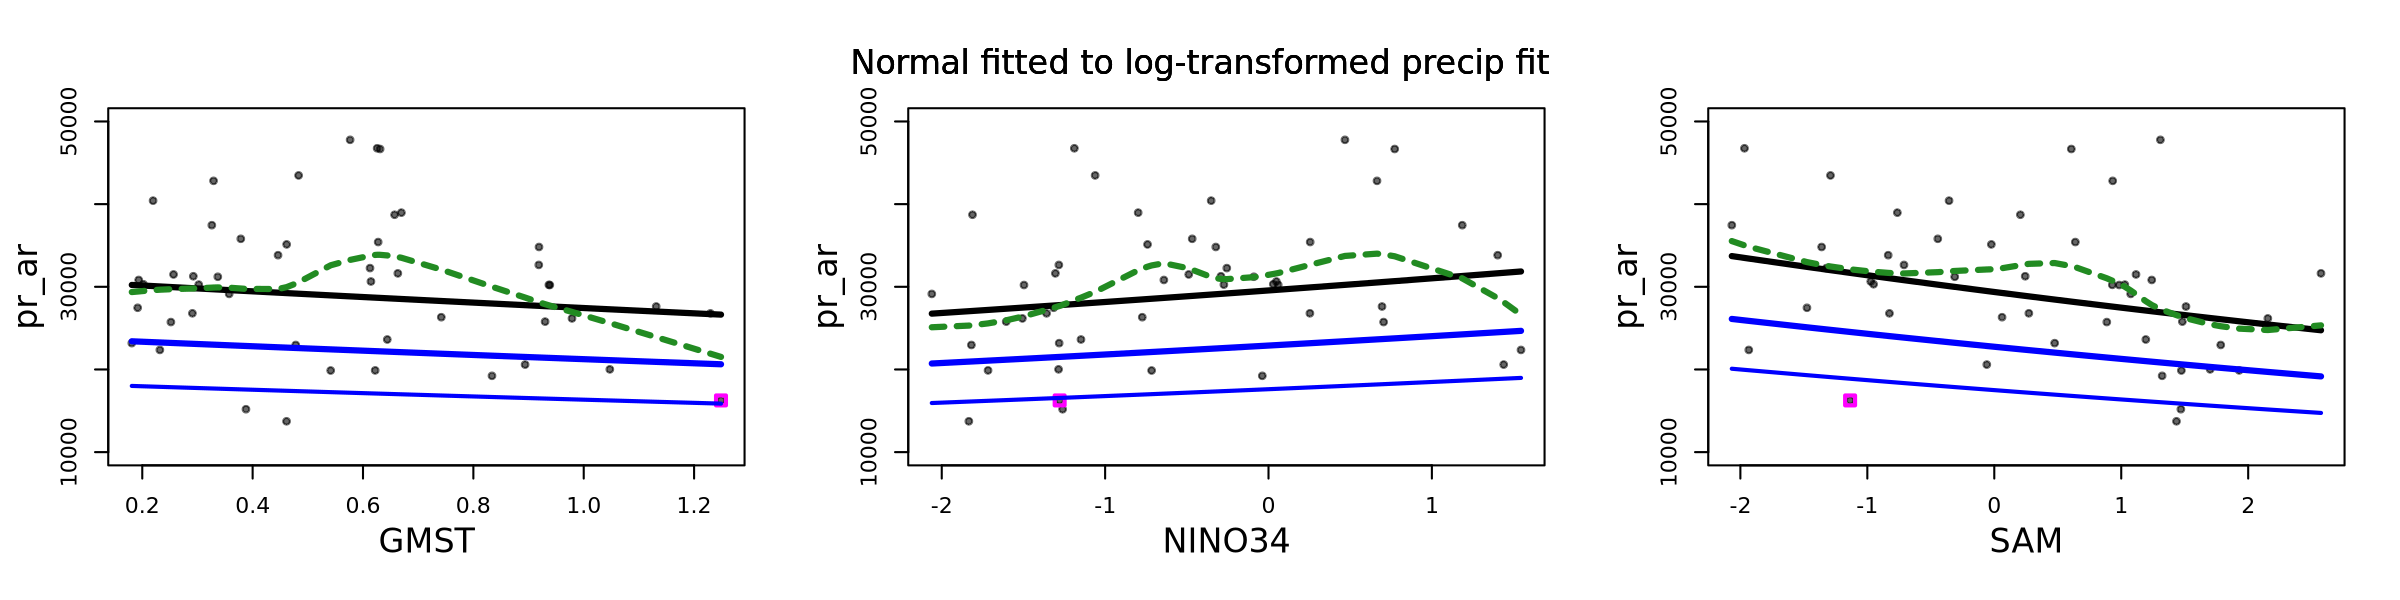

In [190]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_arg_normlogt[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Normal fitted to log-transformed precip fit", side = 3, outer = T, line = -3)
}

# Exploratory analysis - PET

In [113]:
df <- merge(merge(merge(read.table("ts-obs/gmst-smoothed.dat", col.names = c("year", "gmst")),
                        load_ts("ts-obs/sam-fires_nino34det-ndj.dat", col.names = c("year", "nino34"))),
                  load_ts("ts-obs/sam-fires_sam-dec.dat", col.names = c("year", "sam"))),
            merge(load_ts(paste0("ts-obs/sam-fires_pet-ndj_chile2026_era5land.dat"), col.names = c("year", "pet_ch")),
                  load_ts(paste0("ts-obs/sam-fires_pet-ndj_patagonia_era5land.dat"), col.names = c("year", "pet_ar"))))

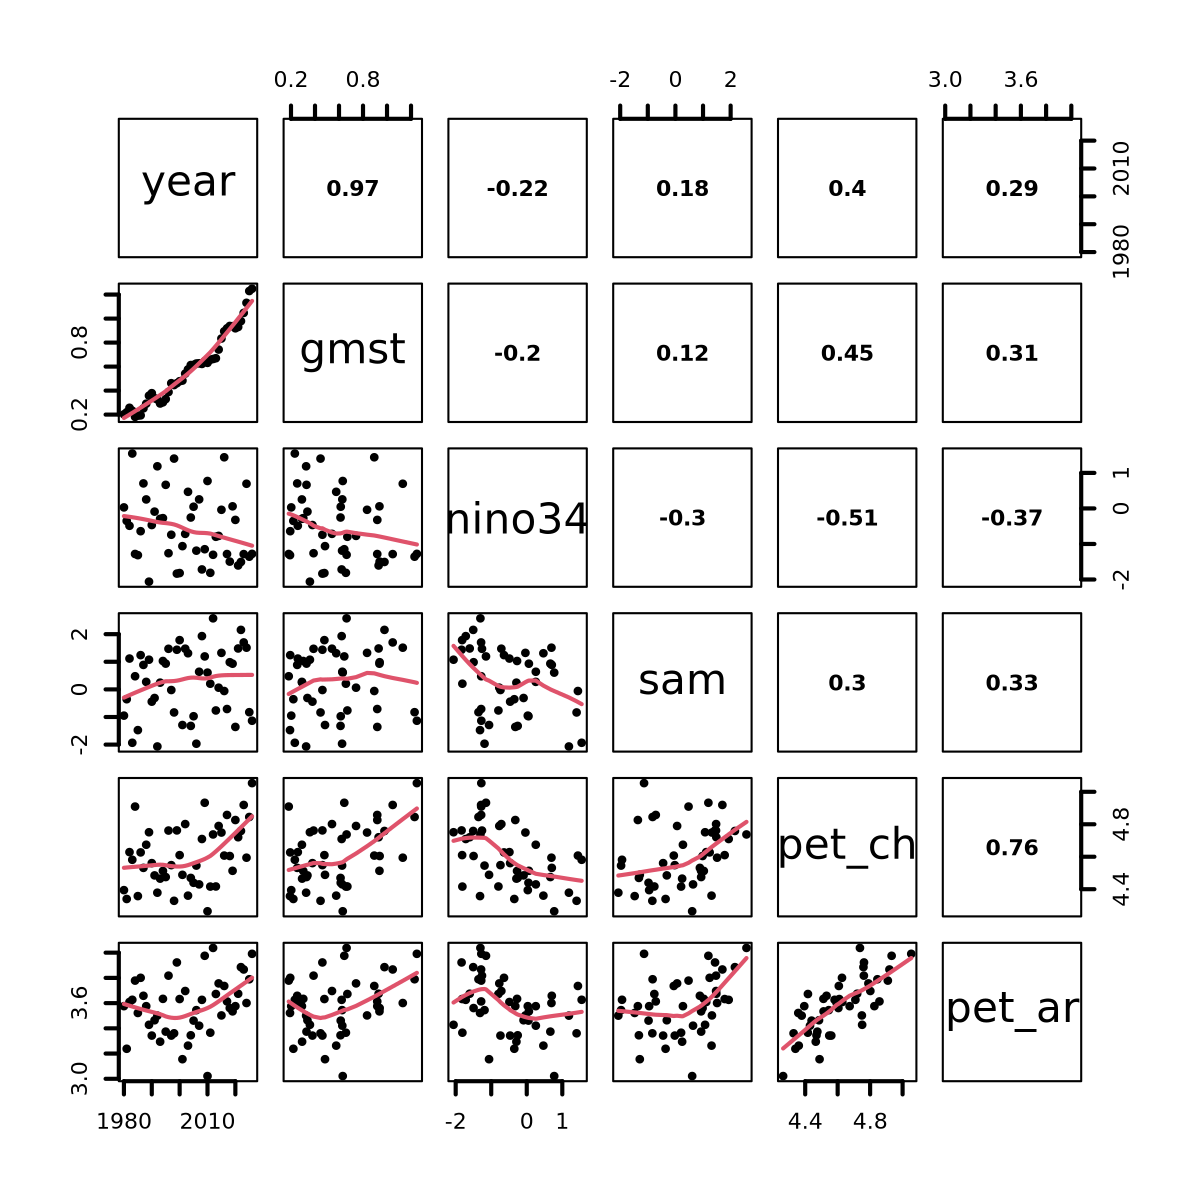

In [114]:
prep_window(h = 6, w = 6)
pairs(df, upper.panel = panel.cor, lower.panel = panel.smooth, lwd = 2)

## Check distributions

In [148]:
prep_window(c(1,2), oma = c(0,0,2,0))

plot(density(df$pet_ch), main = "PET", ylim = c(0,2))
lines(x <- seq(4,5.5,0.01), do.call(devd, append(setNames(as.list(fevd(df$pet_ch, df)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "red3")
lines(x, dnorm(x, mean(df$pet_ch), sd(df$pet_ch)), col = "blue")

plot(density(log(df$pet_ch)), main = "log PET")
lines(x <- seq(1.3,2,0.01), dnorm(x, mean(log(df$pet_ch)), sd(log(df$pet_ch))), col = "blue")

mtext("Chile", side = 3, outer = T, font = 2)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': argument 'x' must be numeric


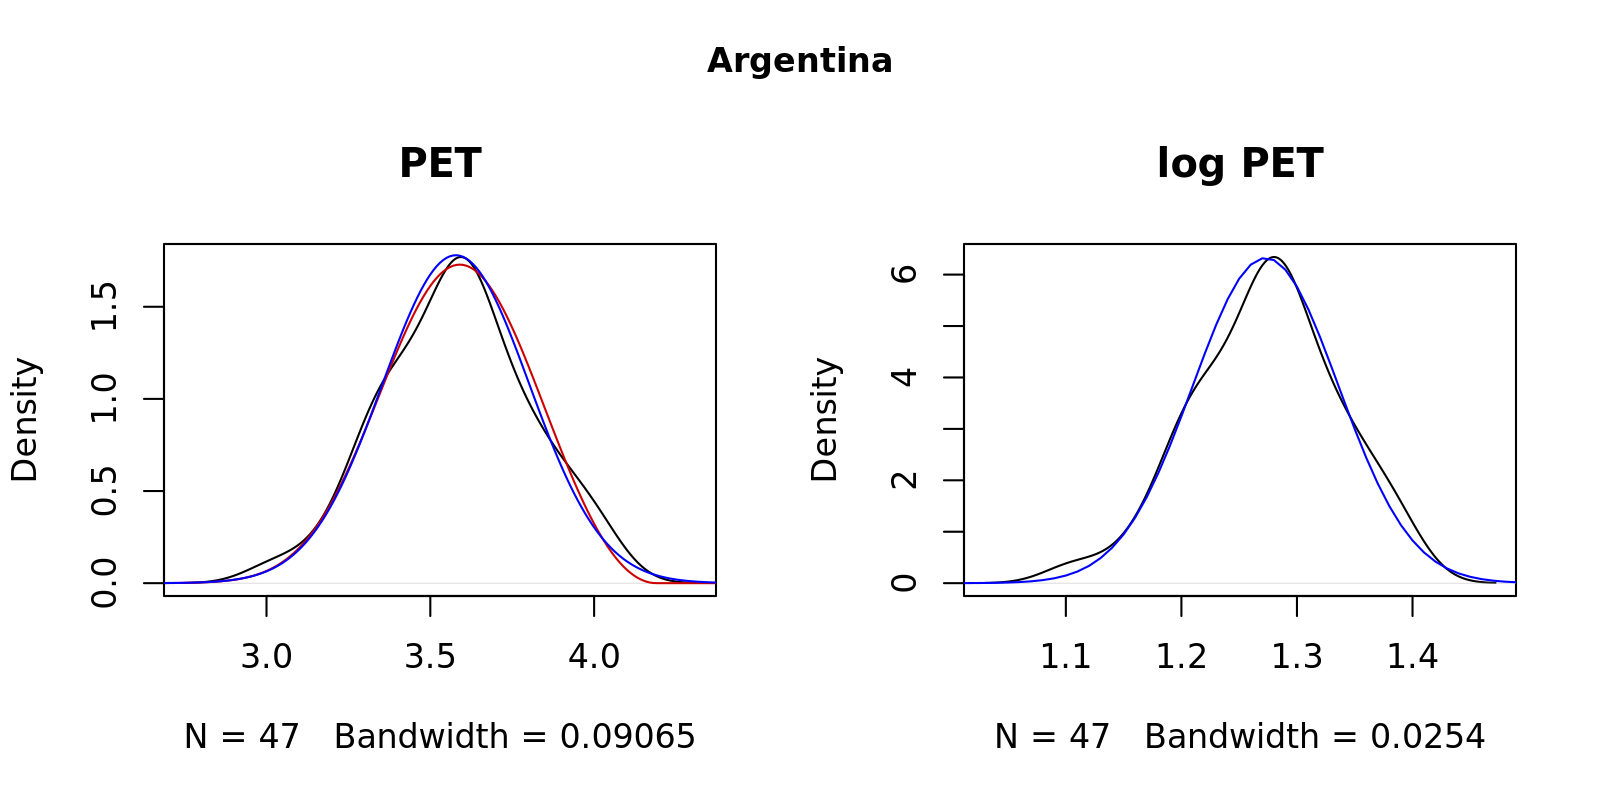

In [116]:
prep_window(c(1,2), oma = c(0,0,2,0))

plot(density(df$pet_ar), main = "PET")
lines(x <- seq(2.5,5.5,0.01), do.call(devd, append(setNames(as.list(fevd(df$pet_ar, df)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "red3")
lines(x, dnorm(x, mean(df$pet_ar), sd(df$pet_ar)), col = "blue")

plot(density(log(df$pet_ar)), main = "log PET")
lines(x <- seq(1,2,0.01), dnorm(x, mean(log(df$pet_ar)), sd(log(df$pet_ar))), col = "blue")

mtext("Argentina", side = 3, outer = T, font = 2)

## Model selection

### Chile

In [117]:
covar_list <- list("GMST only" = "gmst", "Nino only" = "nino34", "SAM only" = "sam",
                   "GMST + Nino" = c("gmst", "nino34"), "GMST + SAM" = c("gmst", "sam"), "GMST + Nino + SAM" = c("gmst", "nino34", "sam"))

# fit all model variants
args_chile <- list(dist = "gev", varnm = "pet_ch", data = df, lower = F)
models_chile_shift <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shift"))), simplify = F)
models_chile_fixeddisp <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "fixeddisp"))), simplify = F)
models_chile_shiftscale <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale"))), simplify = F)
models_chile_shiftscalelinear <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale_linear", method = "Nelder-Mead"))), simplify = F)

In [ ]:
round(rbind("chile - shift" = sapply(models_chile_shift, aic),
      "chile - fixed dispersion" = sapply(models_chile_fixeddisp, aic),
      "chile - shift + scale" = sapply(models_chile_shiftscale, aic), 
      "chile - shift + scale (linear)" = sapply(models_chile_shiftscalelinear, aic)
     ), 2)

In [ ]:
round(rbind("chile - shift" = sapply(models_chile_shift, aic),
      "chile - fixed dispersion" = sapply(models_chile_fixeddisp, aic),
      "chile - shift + scale" = sapply(models_chile_shiftscale, aic), 
      "chile - shift + scale (linear)" = sapply(models_chile_shiftscalelinear, aic)
     ), 2)

In [125]:
rbind("chile - shift" = sapply(models_chile_shift, rsquared))

GMST only  Nino only SAM only    GMST + Nino GMST + SAM
r2     0.09084003 0.1658120 -0.06952016 0.3140031   0.1646305 
r2.adj 0.07063648 0.1472745 -0.09328728 0.2828215   0.1266592 
       GMST + Nino + SAM
r2     0.3238671        
r2.adj 0.2766950

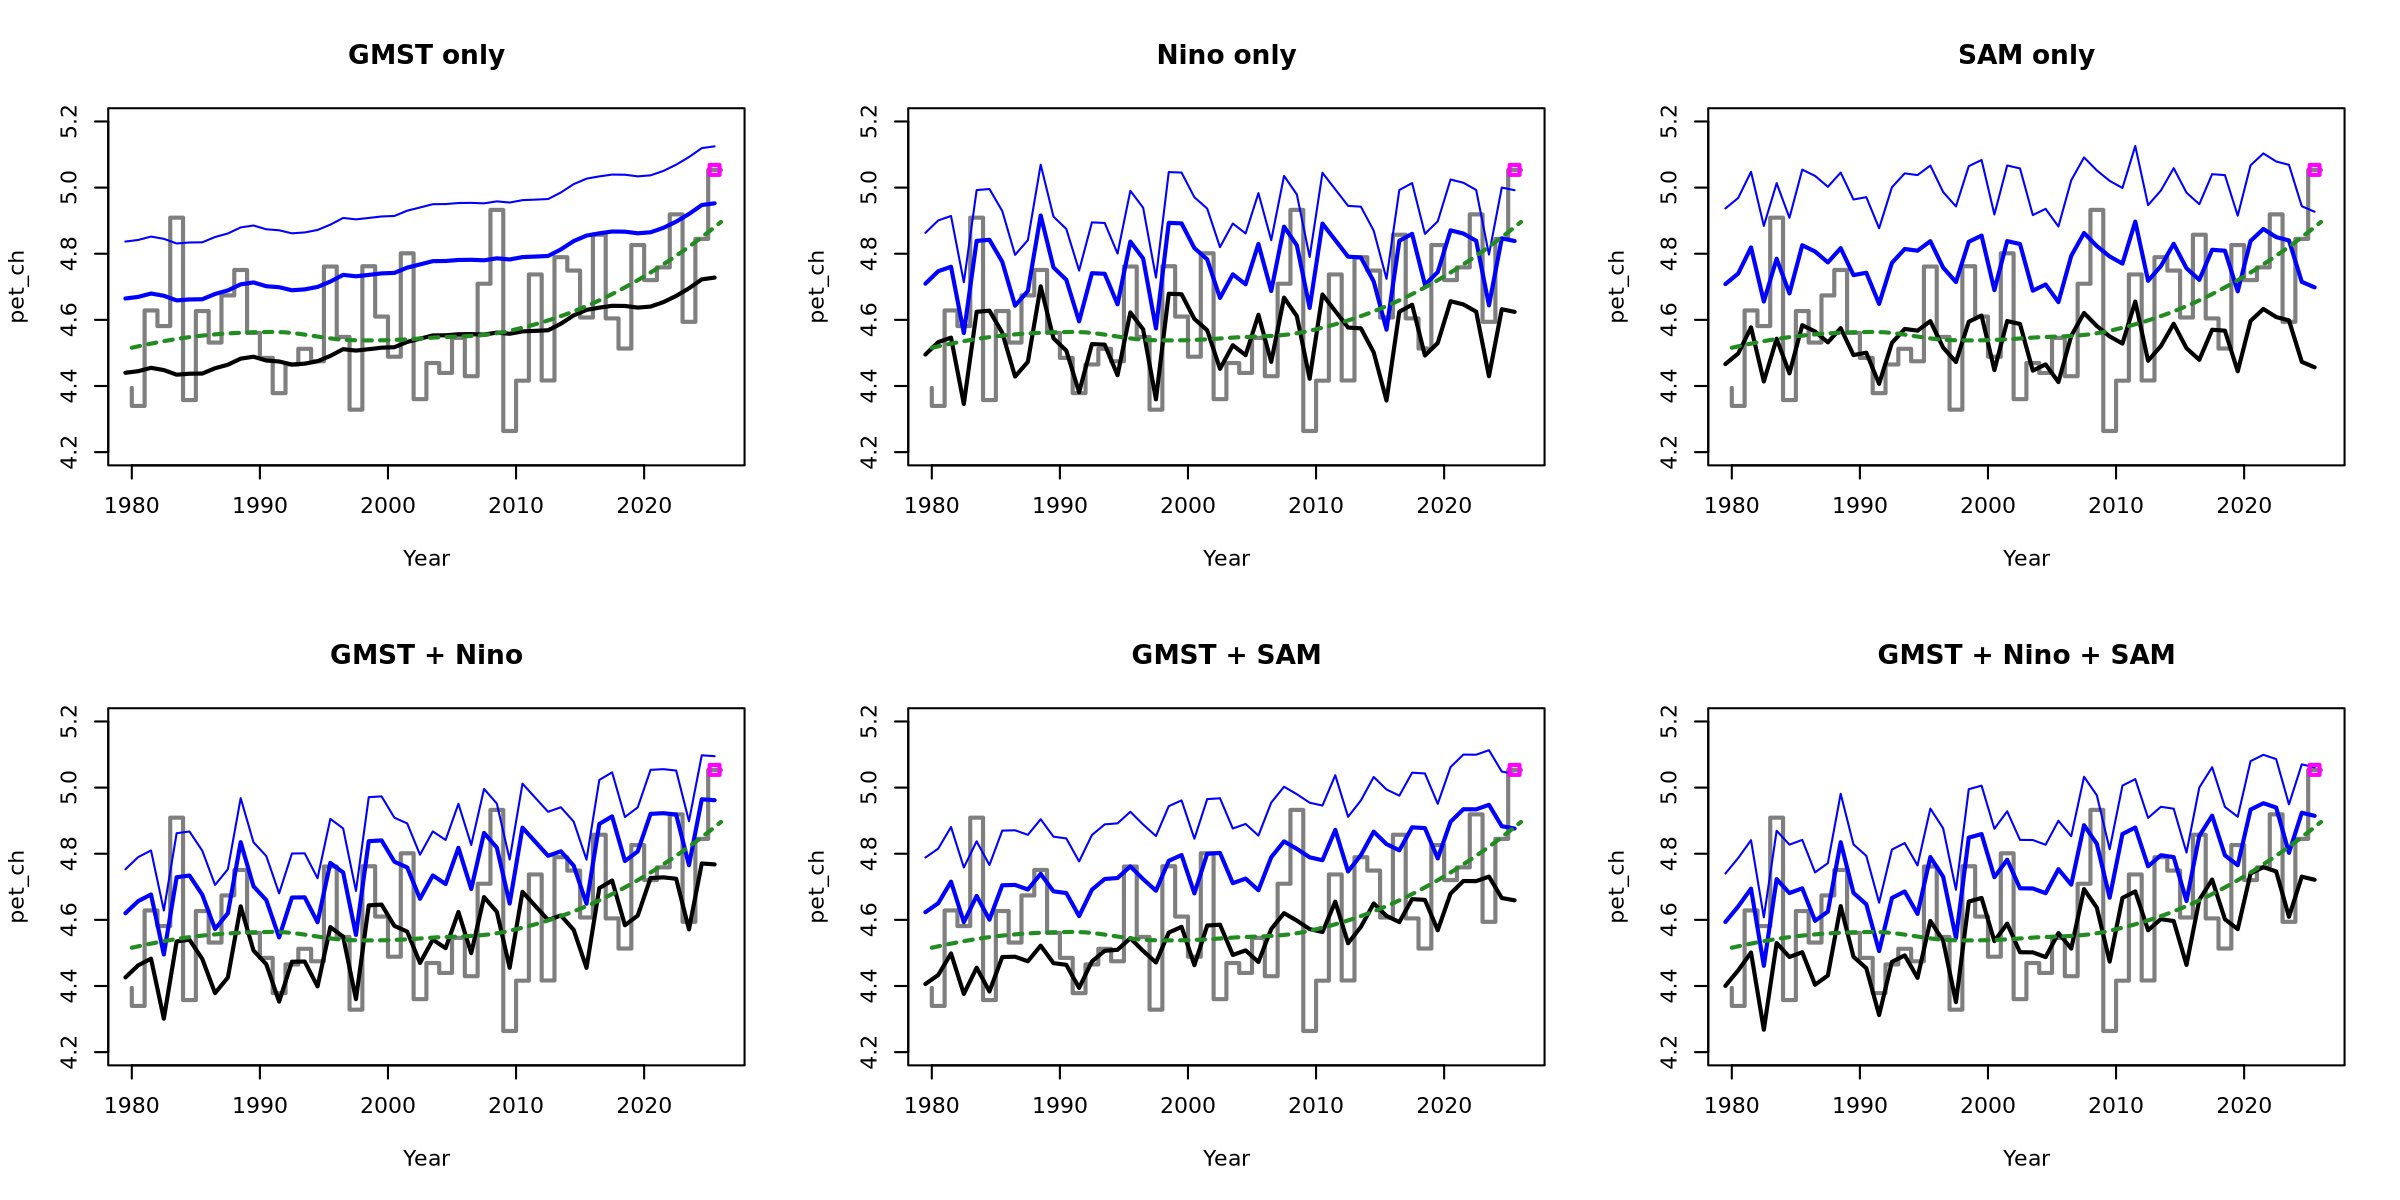

In [126]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_chile_shift)) {
    plot_trend(models_chile_shift[[m]], main = m, legend_pos = NA)
}

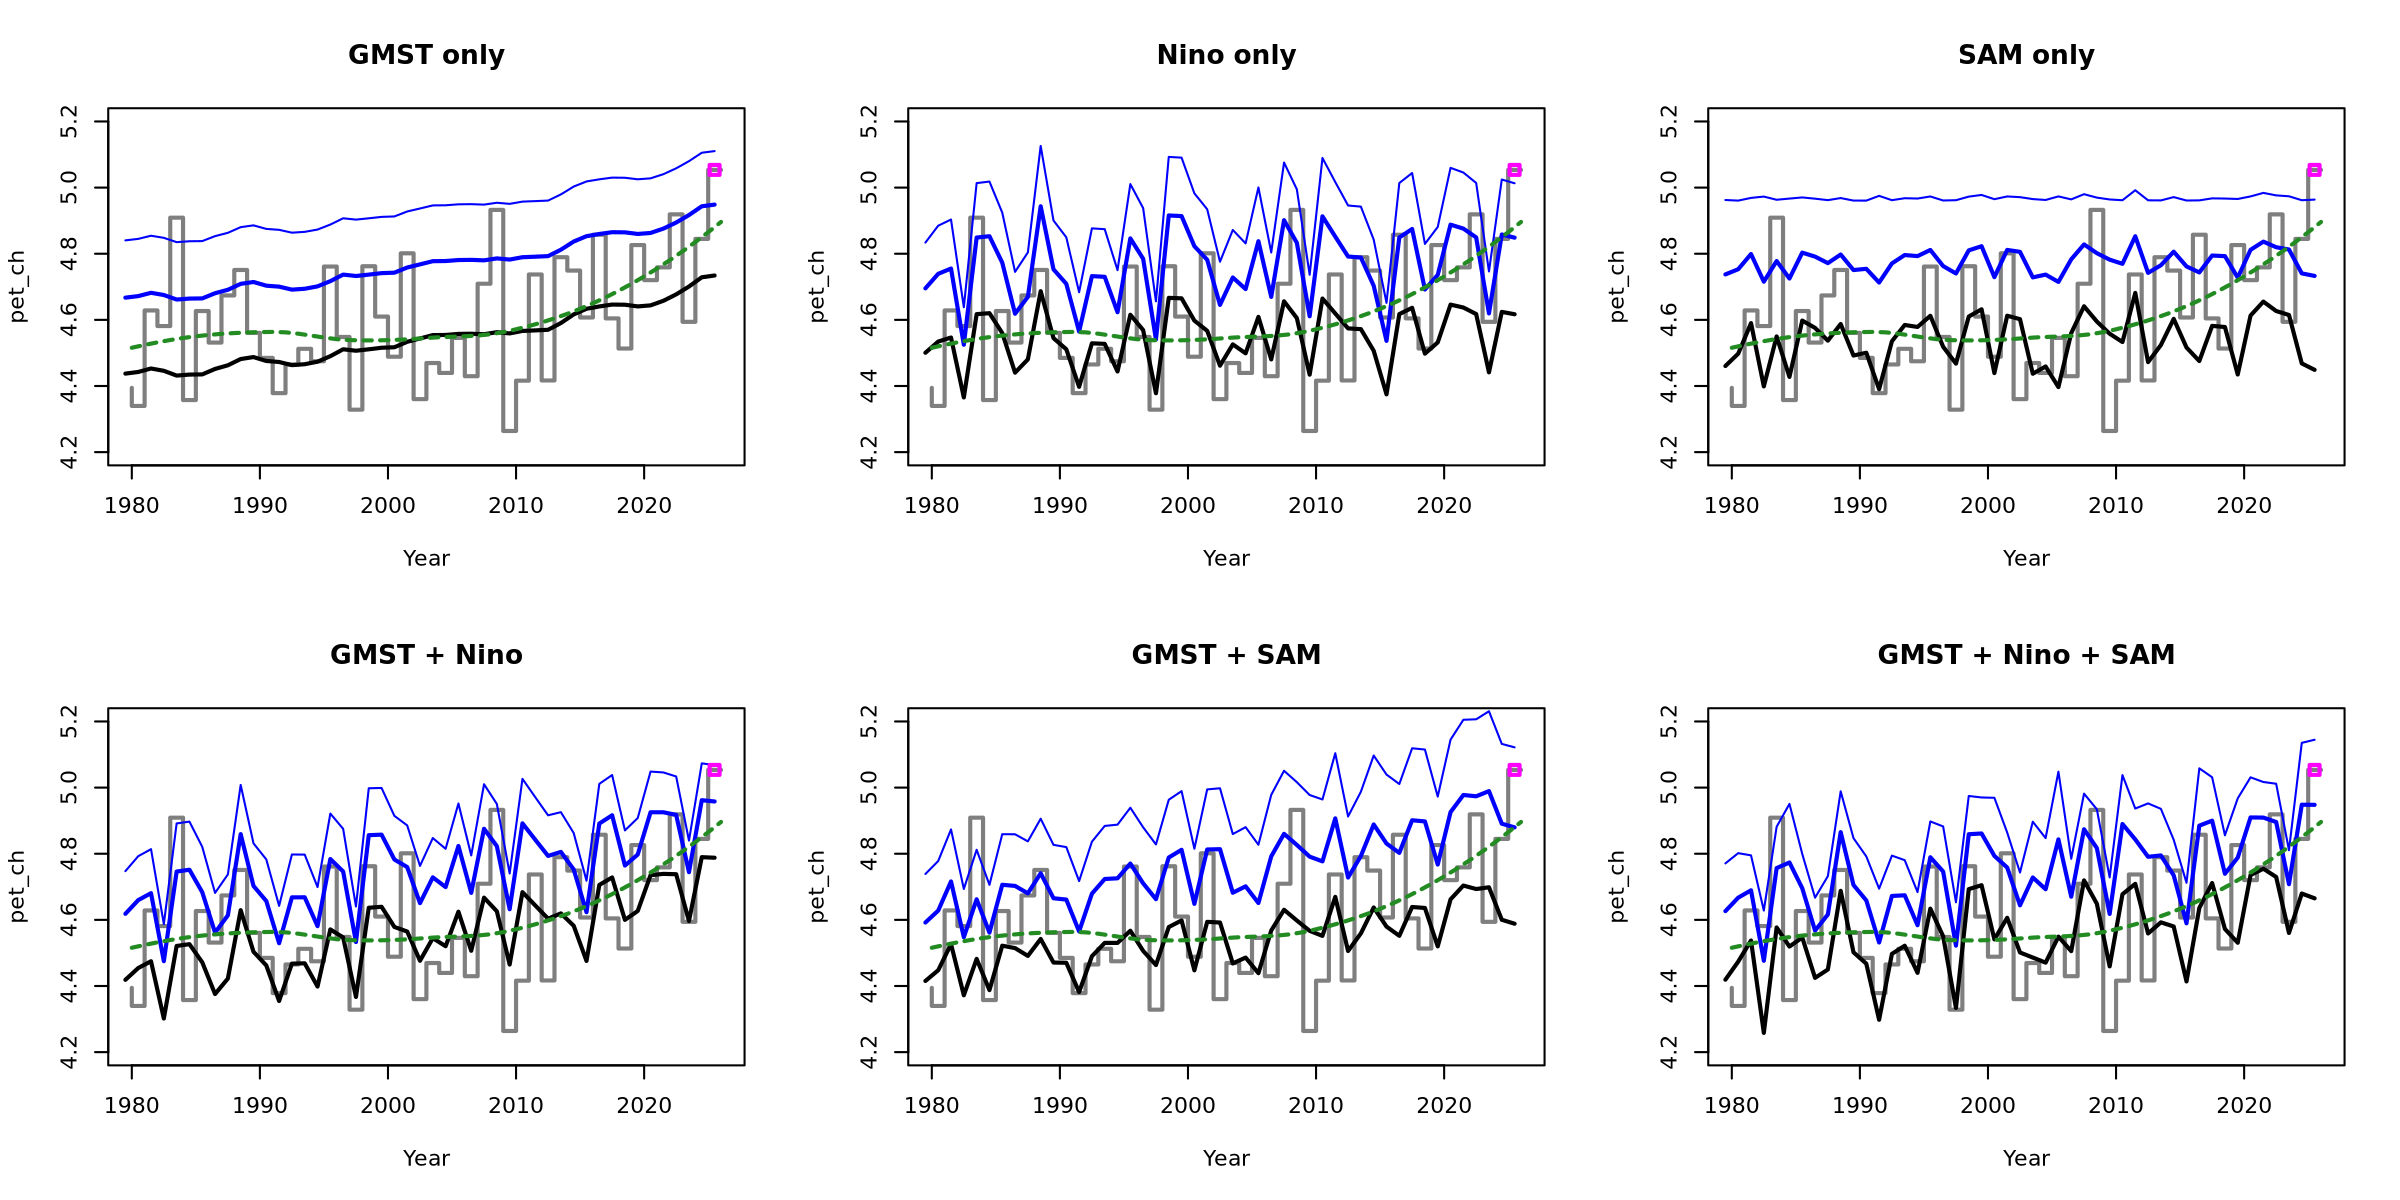

In [121]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_chile_shiftscale)) {
    plot_trend(models_chile_shiftscale[[m]], main = m, legend_pos = NA)
}

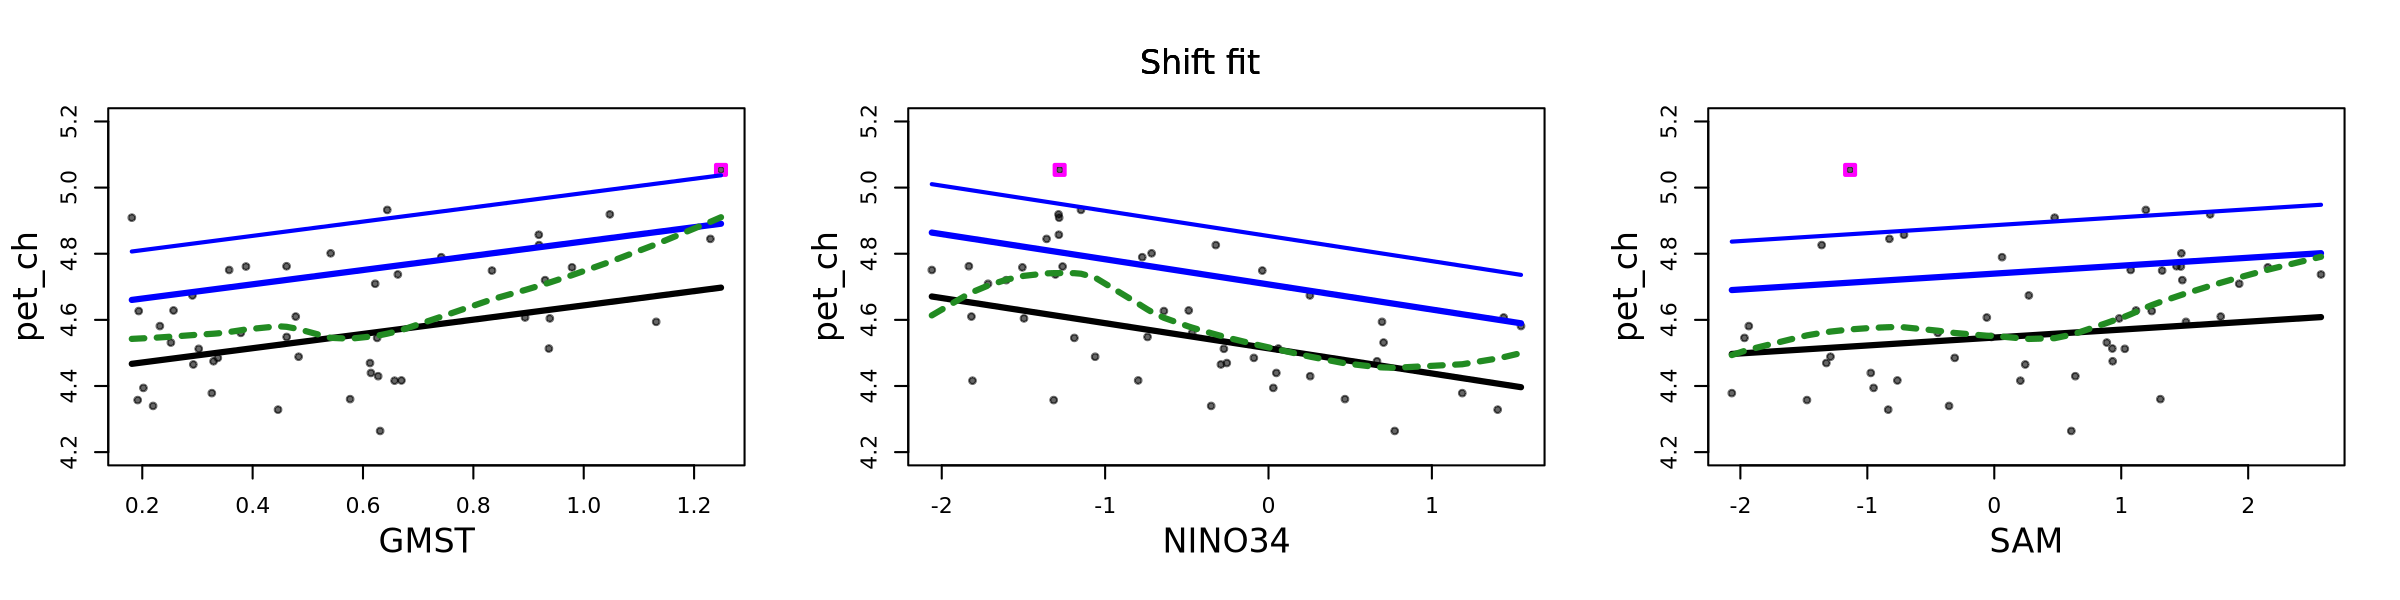

In [127]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shift[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift fit", side = 3, outer = T, line = -3)
}

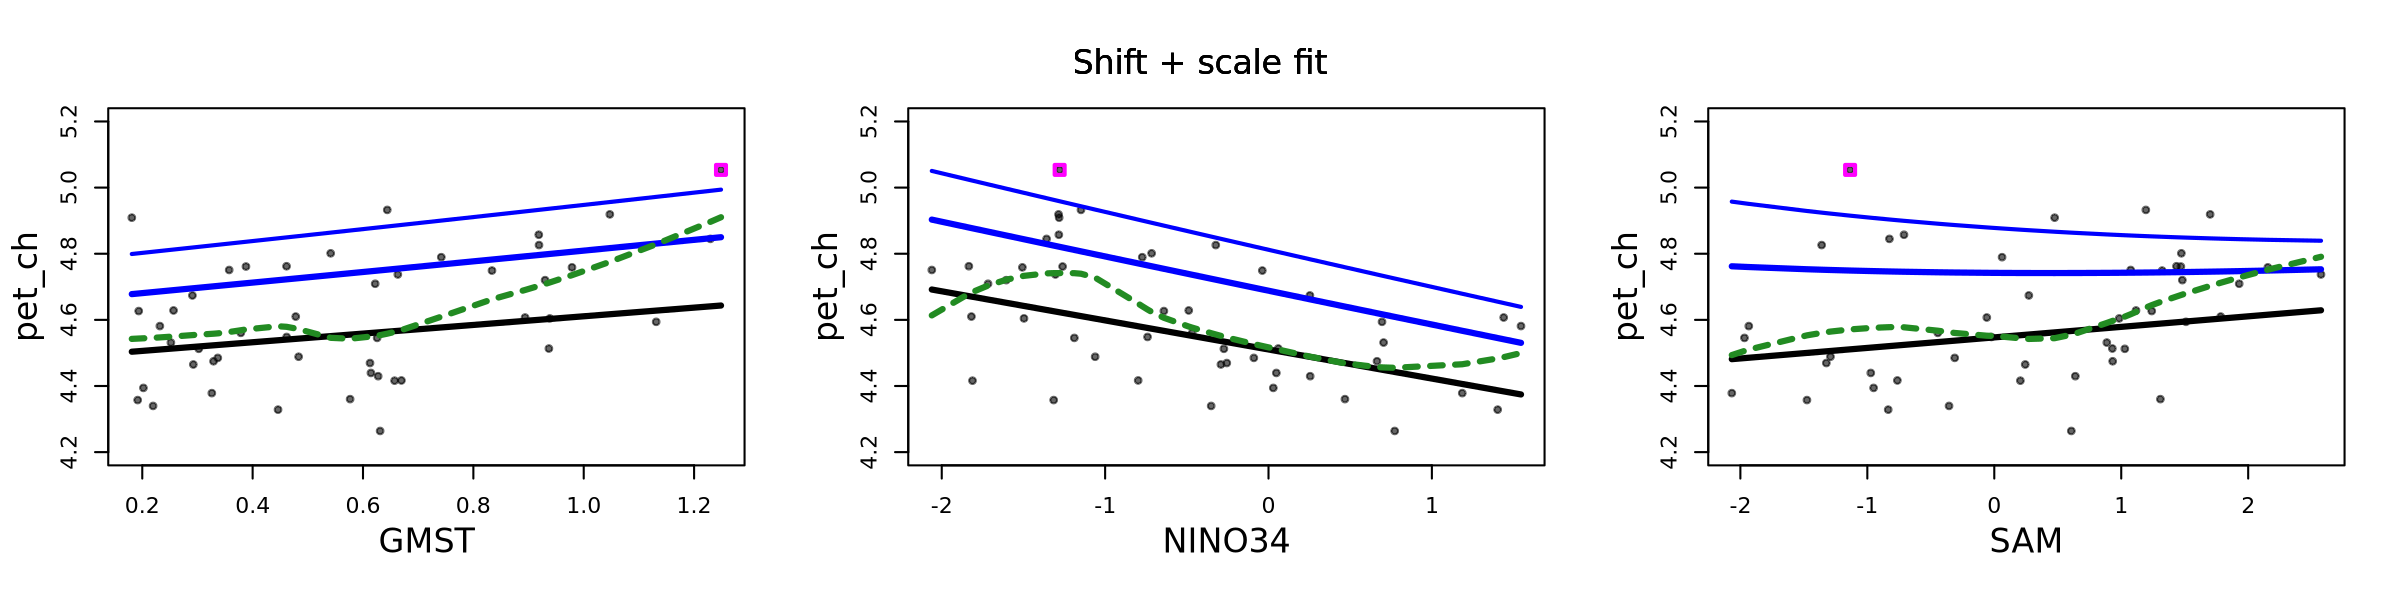

In [123]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shiftscale[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift + scale fit", side = 3, outer = T, line = -3)
}

# essentially linear in all but SAM

### Argentina

In [130]:
covar_list <- list("GMST only" = "gmst", "Nino only" = "nino34", "SAM only" = "sam",
                   "GMST + Nino" = c("gmst", "nino34"), "GMST + SAM" = c("gmst", "sam"), "GMST + Nino + SAM" = c("gmst", "nino34", "sam"))

# fit all model variants
args_chile <- list(dist = "gev", varnm = "pet_ar", data = df, lower = F)
models_chile_shift <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shift"))), simplify = F)
models_chile_fixeddisp <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "fixeddisp"))), simplify = F)
models_chile_shiftscale <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale"))), simplify = F)
models_chile_shiftscalelinear <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale_linear", method = "Nelder-Mead"))), simplify = F)

In [131]:
round(rbind("argentina - shift" = sapply(models_chile_shift, aic),
      "argentina - fixed dispersion" = sapply(models_chile_fixeddisp, aic),
      "argentina - shift + scale" = sapply(models_chile_shiftscale, aic), 
      "argentina - shift + scale (linear)" = sapply(models_chile_shiftscalelinear, aic)
     ), 2)

GMST only Nino only SAM only GMST + Nino
argentina - shift                  -5.57     -9.10     -5.67    -10.39     
argentina - fixed dispersion       -5.49     -9.39     -5.64    -10.58     
argentina - shift + scale          -3.81     -7.36     -3.78     -7.11     
argentina - shift + scale (linear) -3.92     -7.33     -3.78      8.70     
                                   GMST + SAM GMST + Nino + SAM
argentina - shift                  -10.98     -12.35           
argentina - fixed dispersion       -11.47     -12.55           
argentina - shift + scale           -7.89      -6.56           
argentina - shift + scale (linear)  -5.13      -4.20

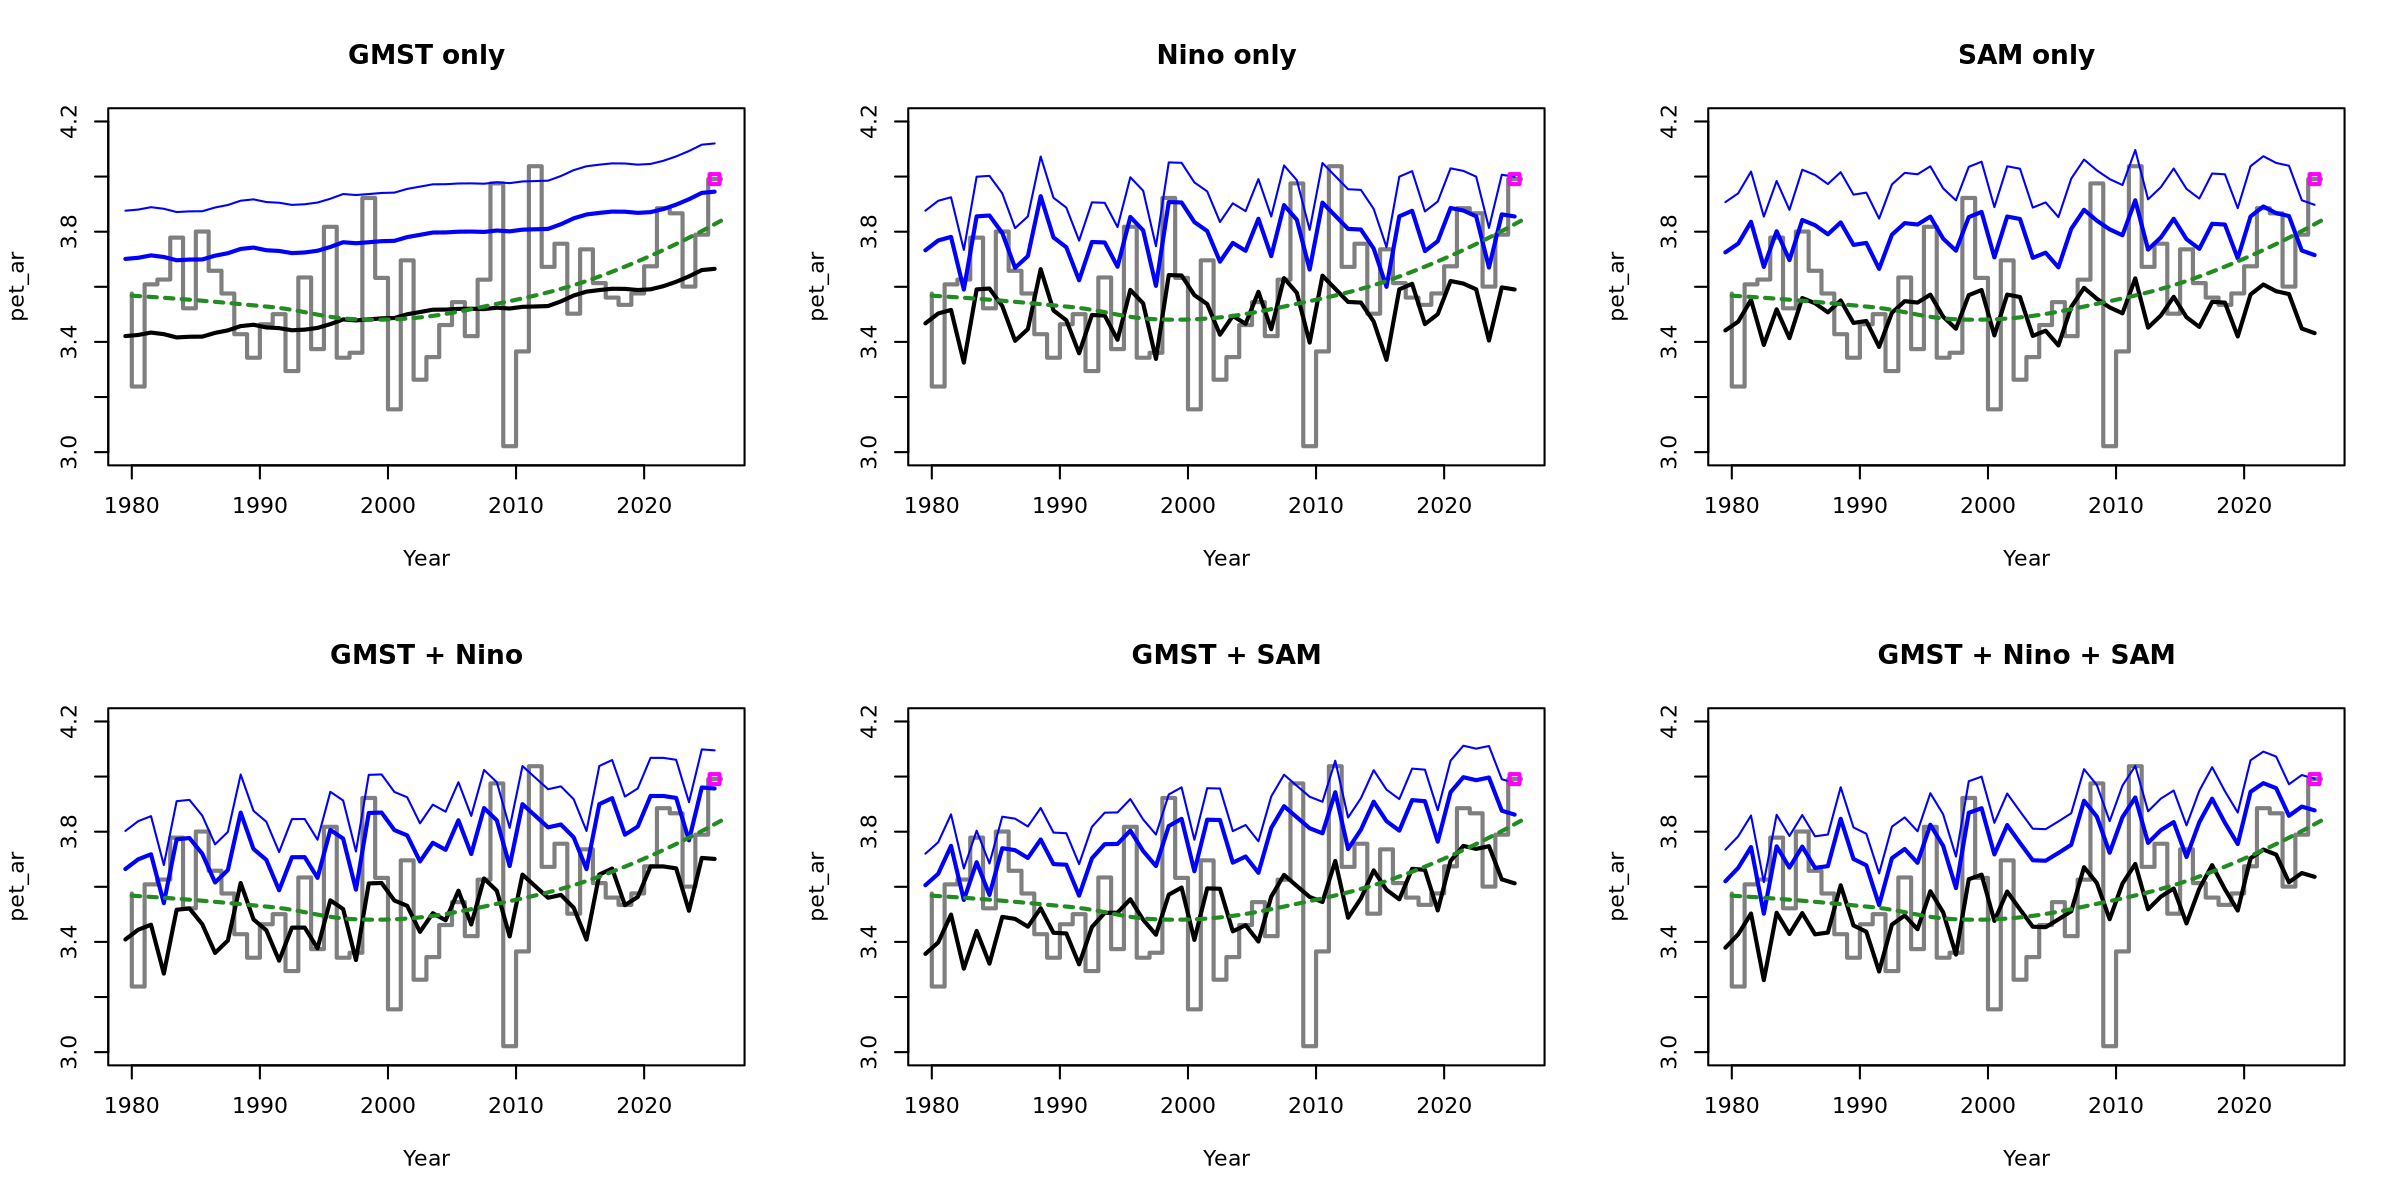

In [133]:
prep_window(c(2,3), w = 4, h = 3)

for (m in names(models_chile_shift)) {
    plot_trend(models_chile_shift[[m]], main = m, legend_pos = NA)
}

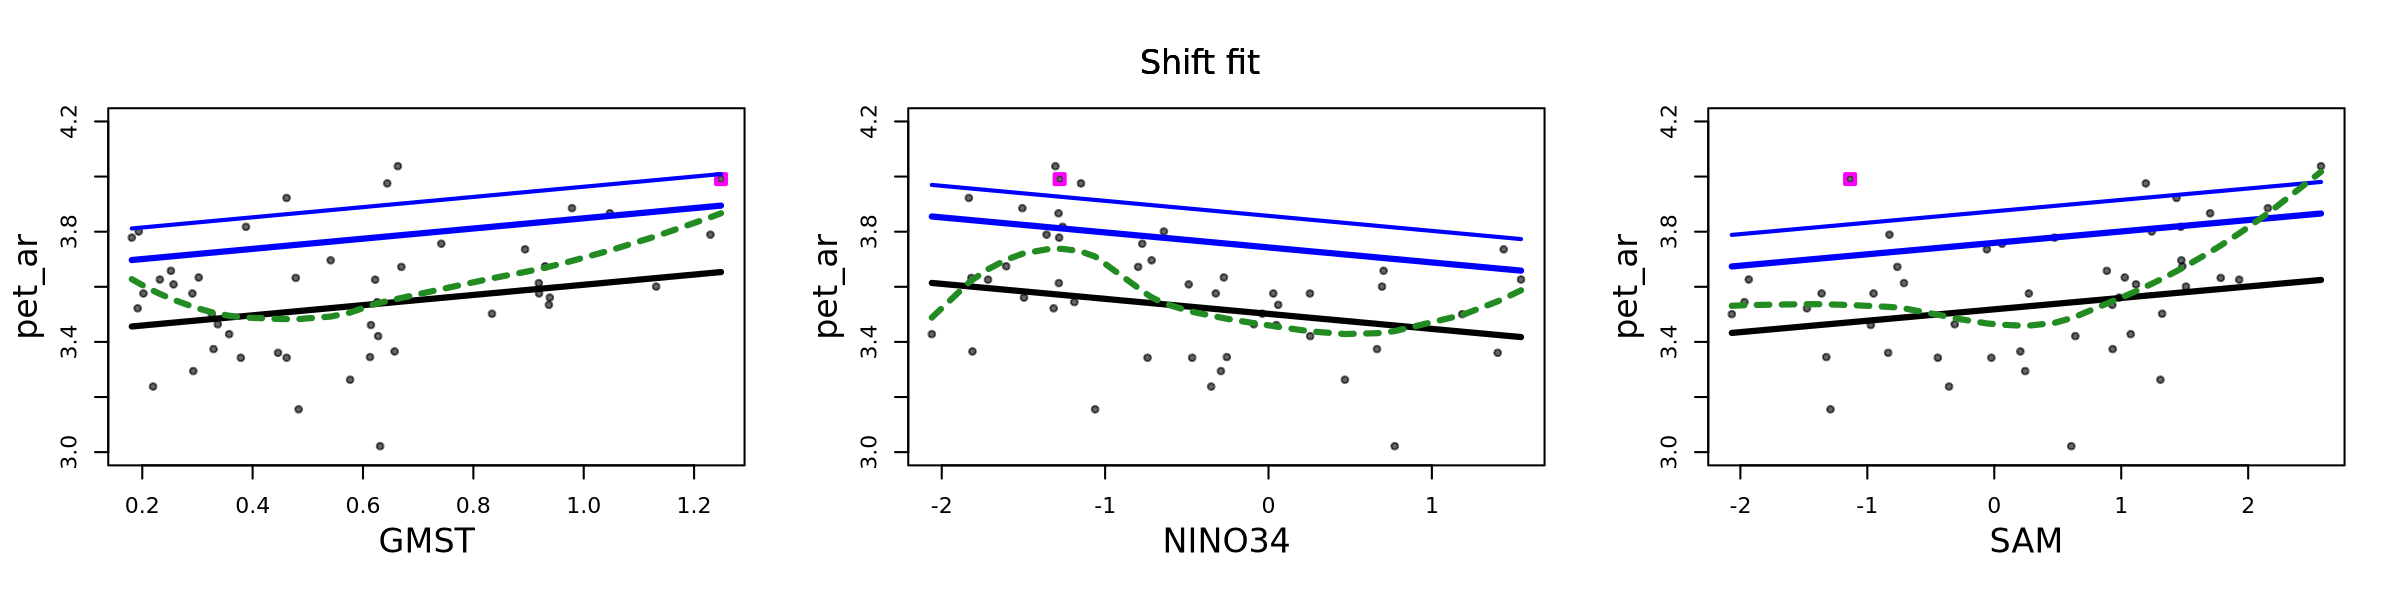

In [134]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shift[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift fit", side = 3, outer = T, line = -3)
}

# Exploratory analysis - effective precip

In [136]:
df <- merge(merge(merge(read.table("ts-obs/gmst-smoothed.dat", col.names = c("year", "gmst")),
                        load_ts("ts-obs/sam-fires_nino34det-ndj.dat", col.names = c("year", "nino34"))),
                  load_ts("ts-obs/sam-fires_sam-dec.dat", col.names = c("year", "sam"))),
            merge(load_ts(paste0("ts-obs/sam-fires_epr-ndj_chile2026_era5land.dat"), col.names = c("year", "epr_ch")),
                  load_ts(paste0("ts-obs/sam-fires_epr-ndj_patagonia_era5land.dat"), col.names = c("year", "epr_ar"))))

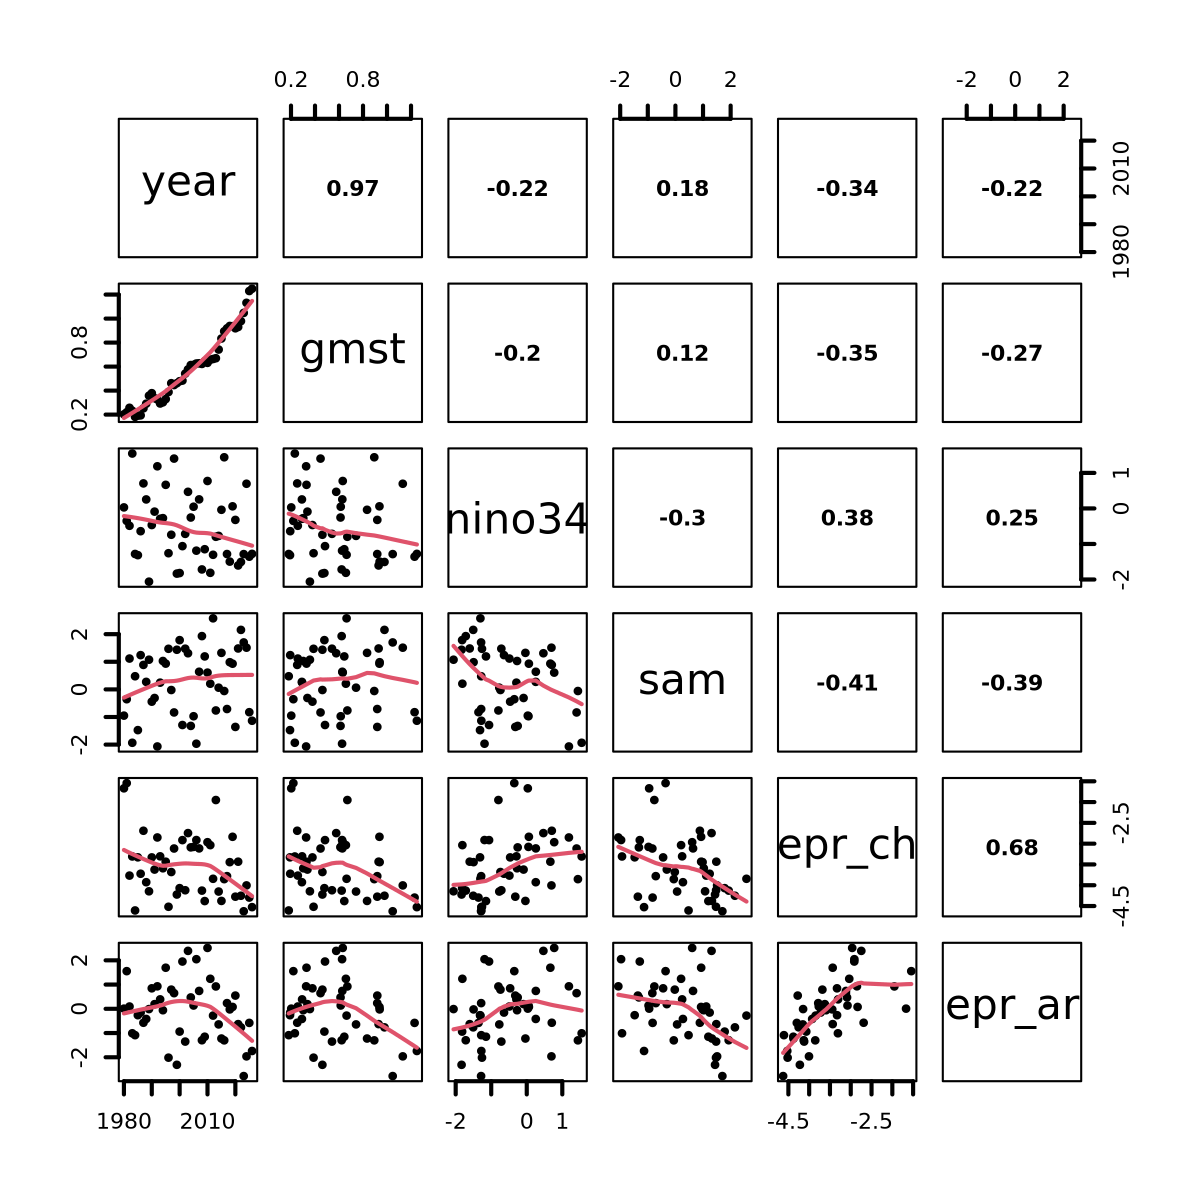

In [137]:
prep_window(h = 6, w = 6)
pairs(df, upper.panel = panel.cor, lower.panel = panel.smooth, lwd = 2)

## Check distributions

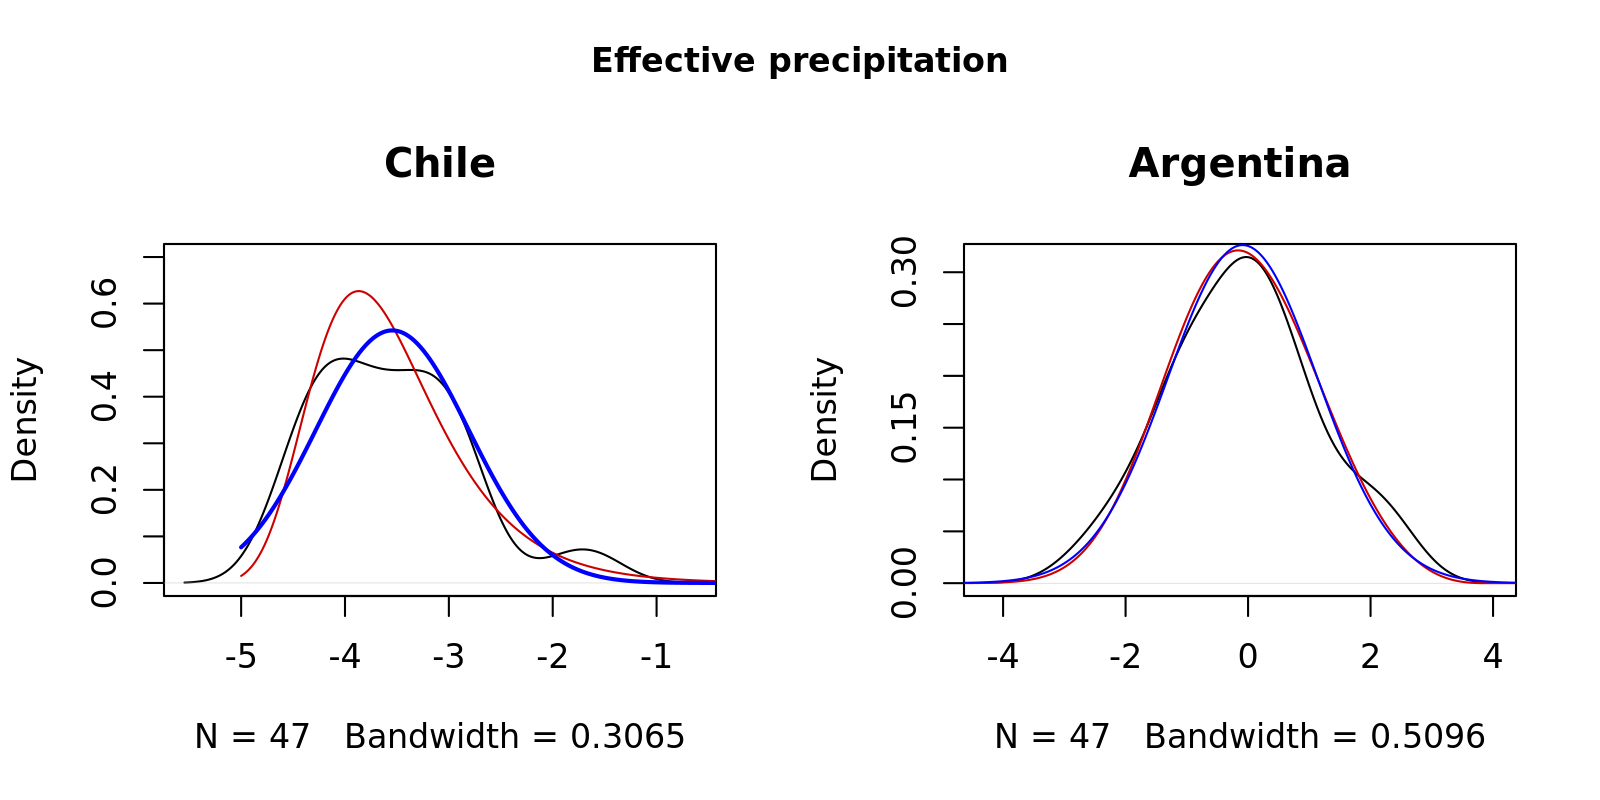

In [150]:
prep_window(c(1,2), oma = c(0,0,2,0))

plot(density(df$epr_ch), main = "Chile", ylim = c(0,0.7))
lines(x <- seq(-5,0,0.01), do.call(devd, append(setNames(as.list(fevd(df$epr_ch, df)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "red3")
lines(x, dnorm(x, mean(df$epr_ch), sd(df$epr_ch)), col = "blue", lwd = 2)

plot(density(df$epr_ar), main = "Argentina")
lines(x <- seq(-5,5,0.01), do.call(devd, append(setNames(as.list(fevd(df$epr_ar, df)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "red3")
lines(x, dnorm(x, mean(df$epr_ar), sd(df$epr_ar)), col = "blue")

mtext("Effective precipitation", side = 3, outer = T, font = 2)

# no real justification for a GEV - use normal distribution

## Model selection

### Chile

In [139]:
covar_list <- list("GMST only" = "gmst", "Nino only" = "nino34", "SAM only" = "sam",
                   "GMST + Nino" = c("gmst", "nino34"), "GMST + SAM" = c("gmst", "sam"), "GMST + Nino + SAM" = c("gmst", "nino34", "sam"))

# fit all model variants
args_chile <- list(dist = "gev", varnm = "epr_ch", data = df, lower = F)
models_chile_shift <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shift"))), simplify = F)
models_chile_fixeddisp <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "fixeddisp"))), simplify = F)
models_chile_shiftscale <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale"))), simplify = F)
models_chile_shiftscalelinear <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale_linear", method = "Nelder-Mead"))), simplify = F)

In [140]:
round(rbind("chile - shift" = sapply(models_chile_shift, aic),
      "chile - fixed dispersion" = sapply(models_chile_fixeddisp, aic),
      "chile - shift + scale" = sapply(models_chile_shiftscale, aic), 
      "chile - shift + scale (linear)" = sapply(models_chile_shiftscalelinear, aic)
     ), 2)

GMST only Nino only SAM only GMST + Nino
chile - shift                  101.50    95.67      99.65   92.92      
chile - fixed dispersion       102.71    96.20     101.54   93.67      
chile - shift + scale           99.14    97.54      97.64   94.12      
chile - shift + scale (linear)  98.52    97.51      96.98   93.44      
                               GMST + SAM GMST + Nino + SAM
chile - shift                  95.04      91.50            
chile - fixed dispersion       97.43      92.94            
chile - shift + scale          97.47      94.58            
chile - shift + scale (linear) 97.56      97.55

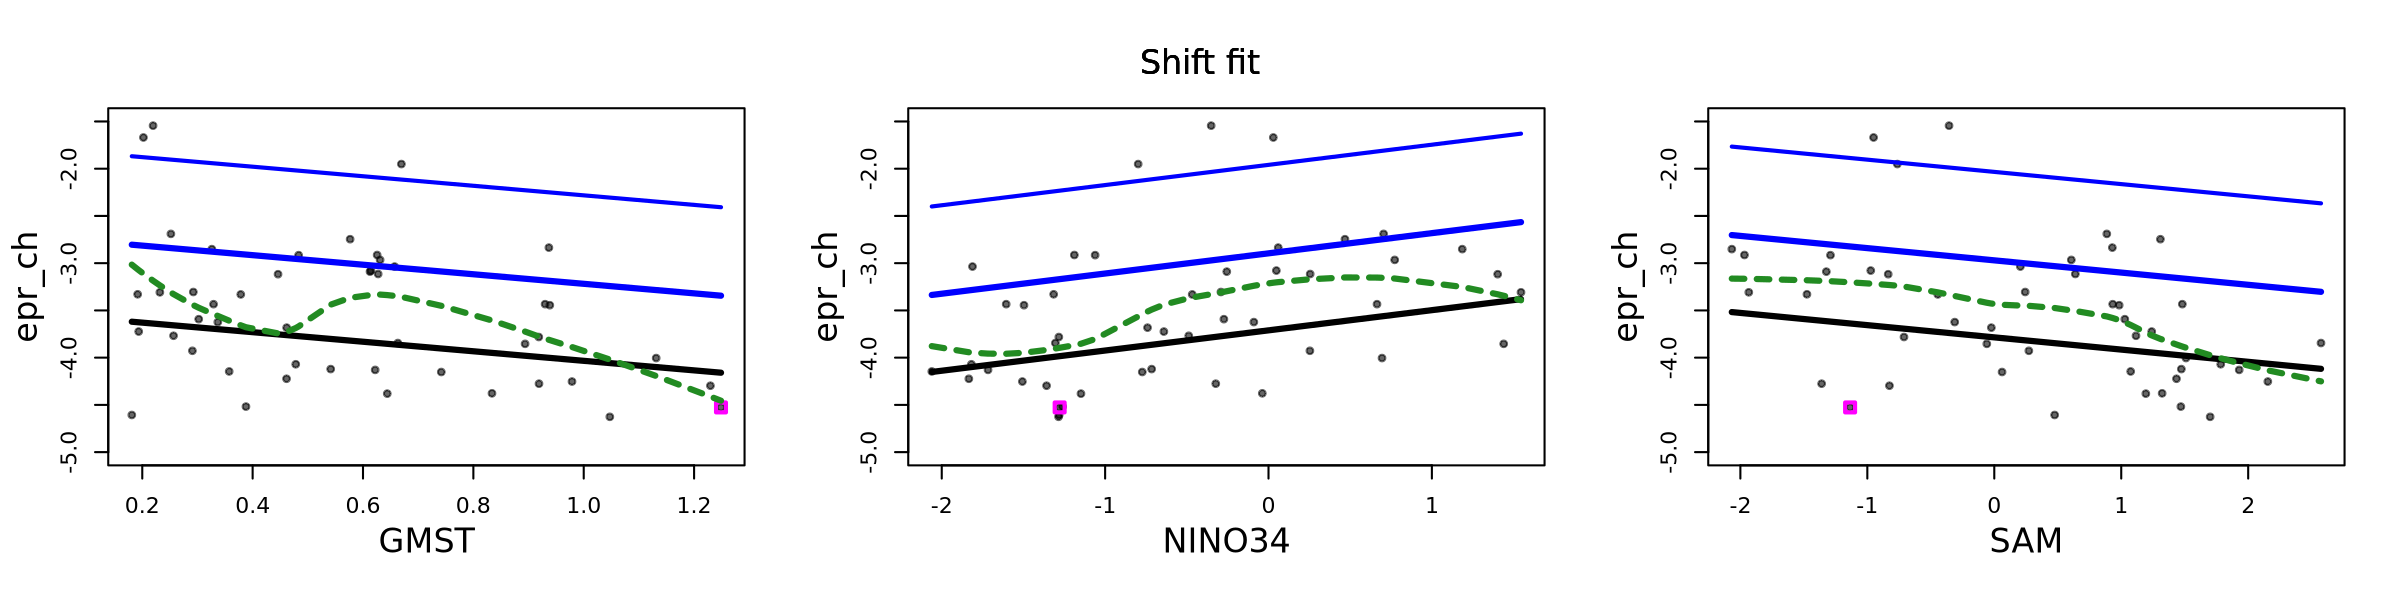

In [141]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shift[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift fit", side = 3, outer = T, line = -3)
}

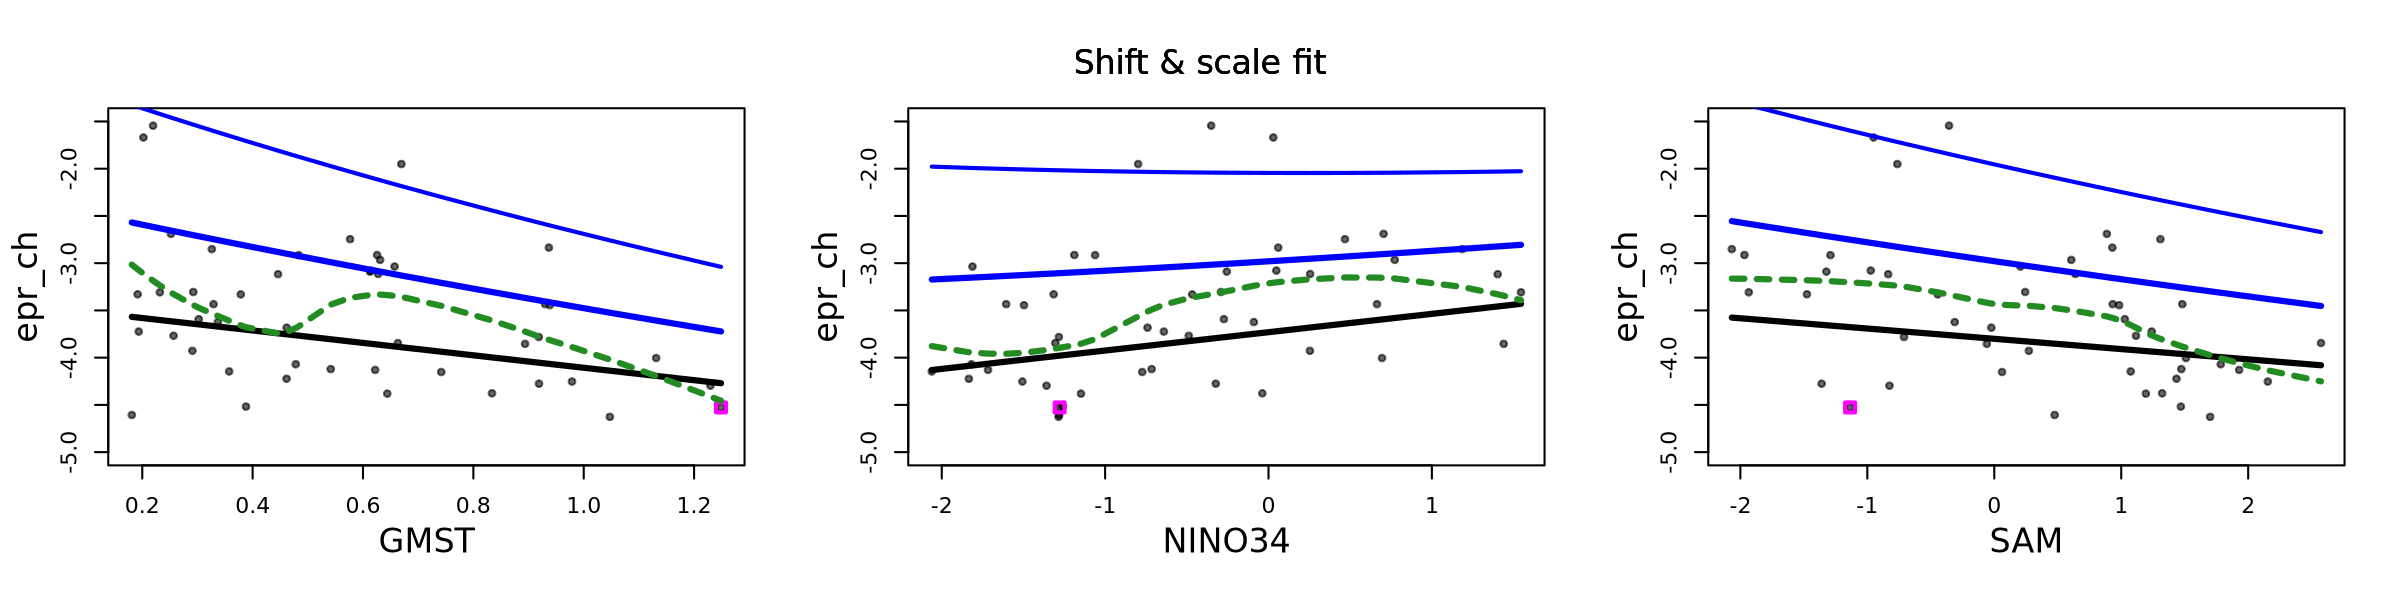

In [143]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shiftscale[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift & scale fit", side = 3, outer = T, line = -3)
}

### Argentina

In [144]:
covar_list <- list("GMST only" = "gmst", "Nino only" = "nino34", "SAM only" = "sam",
                   "GMST + Nino" = c("gmst", "nino34"), "GMST + SAM" = c("gmst", "sam"), "GMST + Nino + SAM" = c("gmst", "nino34", "sam"))

# fit all model variants
args_chile <- list(dist = "gev", varnm = "epr_ar", data = df, lower = F)
models_chile_shift <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shift"))), simplify = F)
models_chile_fixeddisp <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "fixeddisp"))), simplify = F)
models_chile_shiftscale <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale"))), simplify = F)
models_chile_shiftscalelinear <- sapply(covar_list, function(covs) do.call(fit_ns, append(args_chile, list(covnm = covs, type = "shiftscale_linear", method = "Nelder-Mead"))), simplify = F)

In [146]:
round(rbind("argentina - shift" = sapply(models_chile_shift, aic),
      "argentina - fixed dispersion" = sapply(models_chile_fixeddisp, aic),
      "argentina - shift + scale" = sapply(models_chile_shiftscale, aic), 
      "argentina - shift + scale (linear)" = sapply(models_chile_shiftscalelinear, aic)
     ), 2)

GMST only Nino only SAM only GMST + Nino
argentina - shift                  154.86    155.54    150.68   154.56     
argentina - fixed dispersion       156.76    158.70    157.39   158.69     
argentina - shift + scale          156.85    157.28    152.58   158.18     
argentina - shift + scale (linear) 156.85    157.58    152.58   158.10     
                                   GMST + SAM GMST + Nino + SAM
argentina - shift                  149.11     150.82           
argentina - fixed dispersion       157.44     159.40           
argentina - shift + scale          153.04     154.63           
argentina - shift + scale (linear) 153.36     154.99

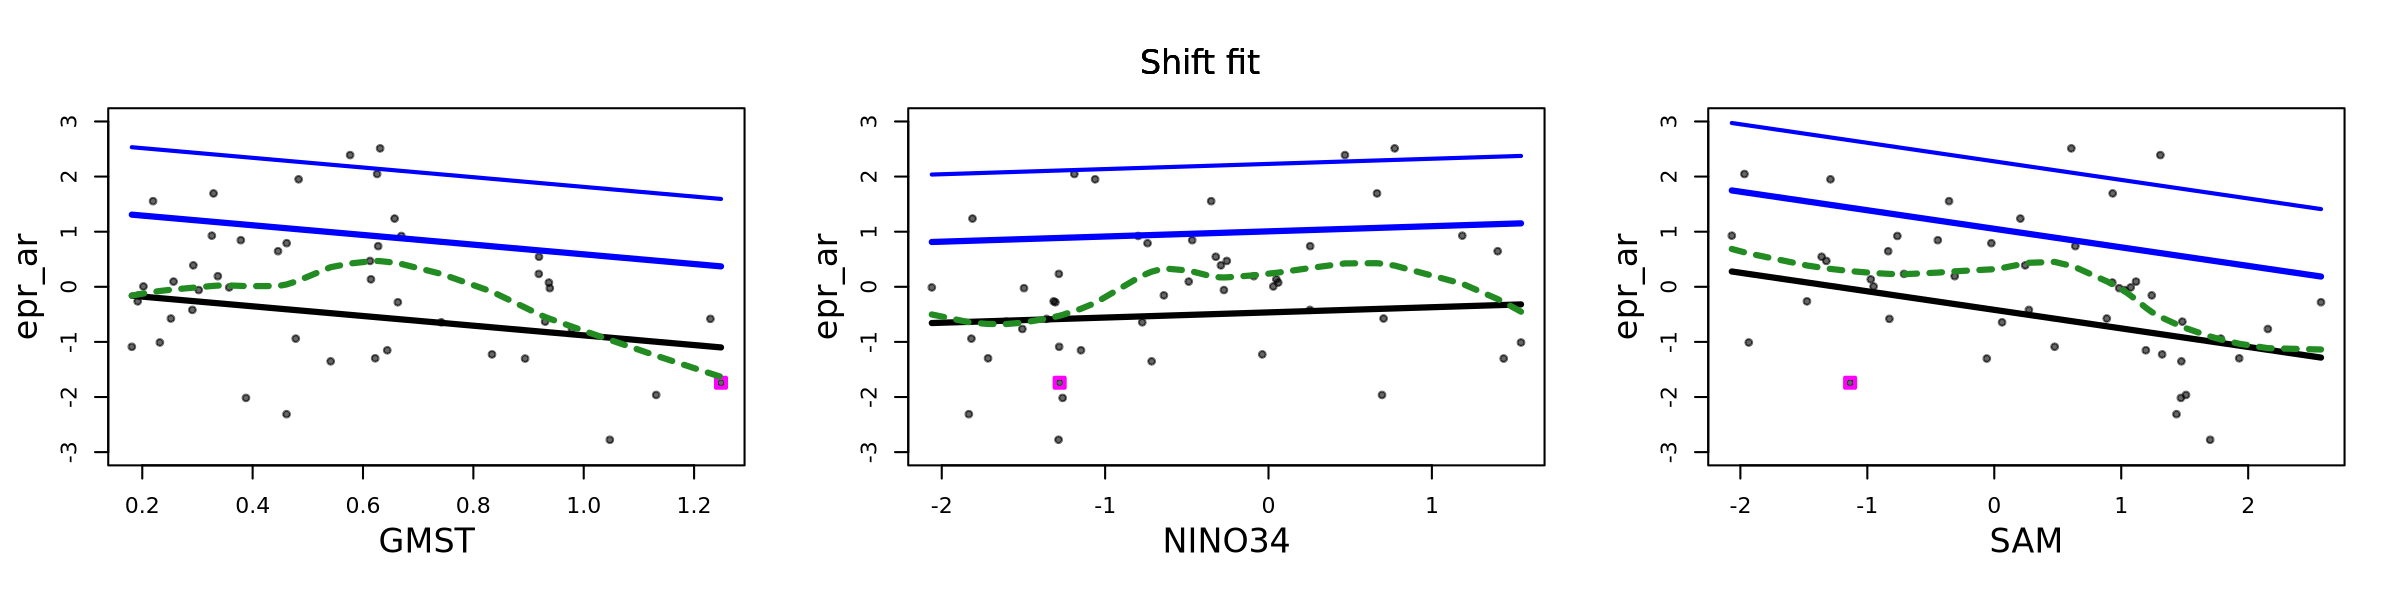

In [147]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shift[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift fit", side = 3, outer = T, line = -3)
}

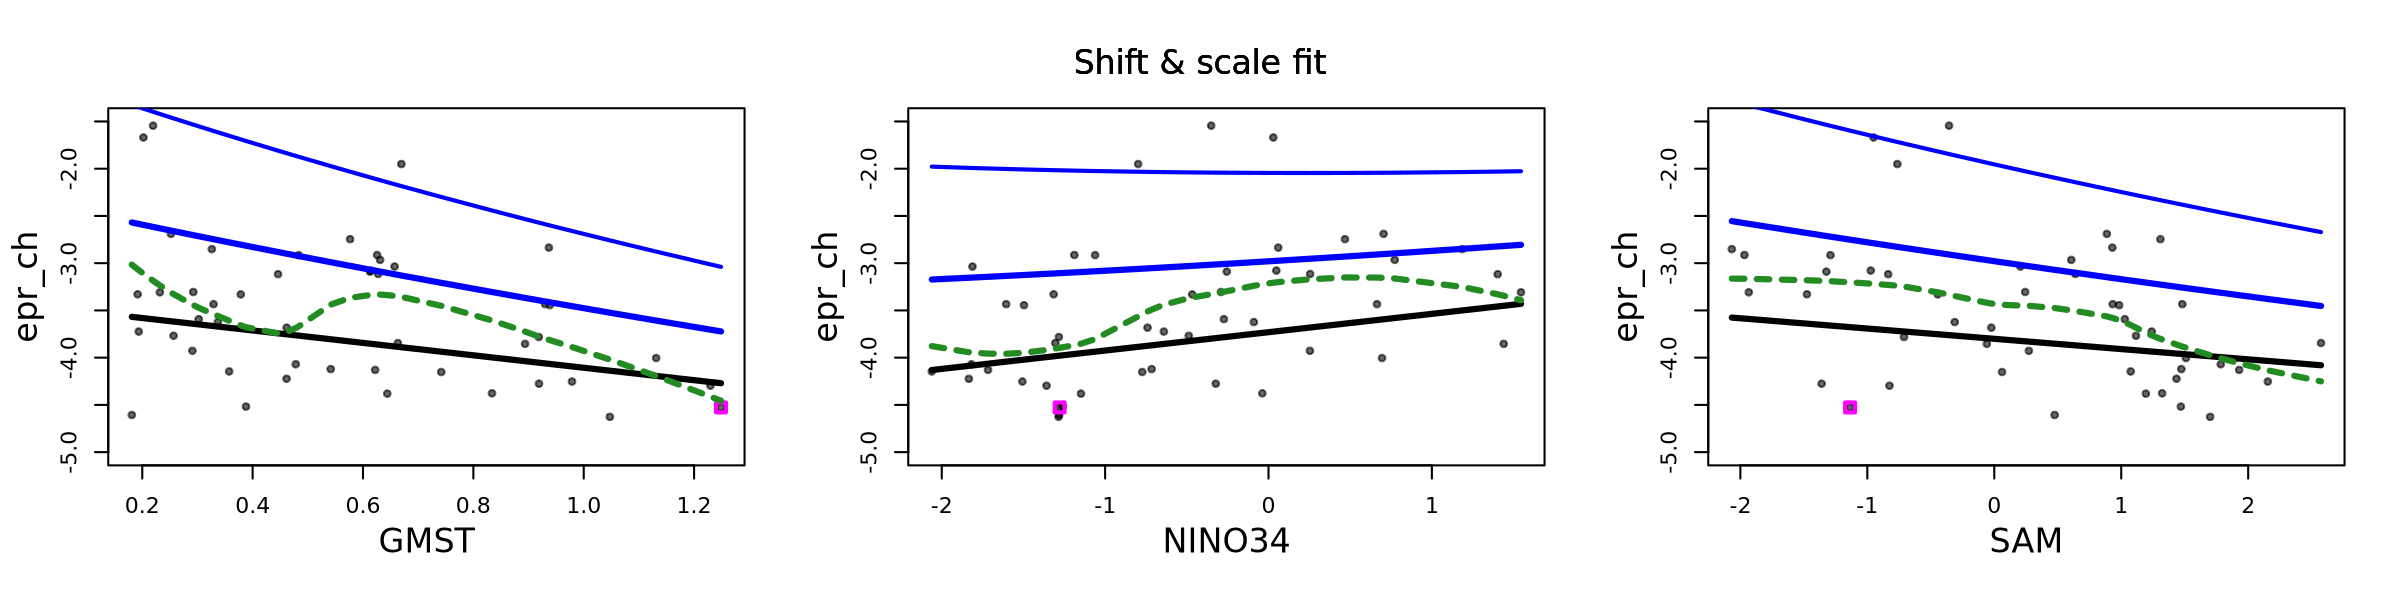

In [143]:
prep_window(c(1,3), w = 4, h = 3)

for (covnm in c("gmst", "nino34", "sam")) {
    plot_covtrend(models_chile_shiftscale[["GMST + Nino + SAM"]], covnm, legend_pos = NA)
    mtext("Shift & scale fit", side = 3, outer = T, line = -3)
}

# Model fitting - obs

In [16]:
mdl_args <- list("hdwi_chile2026" = list(dist = "gev", type = "shiftscale", lower = F),
                 "hdwi_patagonia" = list(dist = "gev", type = "shift", lower = F),
                 "pr-ndj_chile2026" = list(dist = "norm_logt", type = "shift", lower = T),
                 "pr-ndj_patagonia" = list(dist = "norm_logt", type = "shift", lower = T),
                 "pet-ndj_chile2026" = list(dist = "norm", type = "shift", lower = F),
                 "pet-ndj_patagonia" = list(dist = "norm", type = "shift", lower = F),
                 "epr-ndj_chile2026" = list(dist = "norm", type = "shift", lower = T),
                 "epr-ndj_patagonia" = list(dist = "norm", type = "shift", lower = T))


cov_df <- merge(merge(read.table("ts-obs/gmst-smoothed.dat", col.names = c("year", "gmst")),
                      load_ts("ts-obs/sam-fires_nino34det-ndj.dat", col.names = c("year", "nino34"))),
                load_ts("ts-obs/sam-fires_sam-dec.dat", col.names = c("year", "sam")))
cov_df$gmst <- cov_df$gmst - cov_df$gmst[cov_df$year == 2026]
cov_df$samdet <- resid(lm(sam ~ gmst, cov_df))


cov_2026 <- cov_df[cov_df$year == 2026,c("gmst", "sam", "samdet", "nino34"),drop = F]
cov_cf <- rbind("pi" = cov_2026 - c(1.3, 0, 0, 0),
                "samneutral" = c(cov_2026$gmst, 0, 0, cov_2026$nino34),
                "ensoneutral" = c(cov_2026$gmst, cov_2026$sam, cov_2026$samdet, 0),
                "bothneutral" = c(cov_2026$gmst, 0, 0, 0))

cov_list <- list("gmst-only" = "gmst", "gmst+nino" = c("gmst", "nino34"), "gmst+sam" = c("gmst", "sam"), 
                 "gmst+nino+sam" = c("gmst", "sam", "nino34")
                 ,"gmst+samdet" = c("gmst", "samdet"),"gmst+nino+samdet" = c("gmst", "samdet", "nino34")
                )

In [17]:
nsamp <- 1000
for (varnm in c("hdwi", "pr-ndj", "pet-ndj", "epr-ndj")) {
    for (rnm in c("chile2026", "patagonia")) {
        for (mtype in names(cov_list)) {

            covnm <- cov_list[[mtype]]

            res_fnm = paste0("res-obs/res-obs_",varnm,"_",rnm,"_era5land_",mtype,".csv")
            if (file.exists(res_fnm)) next
            
            df <- merge(cov_df, load_ts(paste0("ts-obs/sam-fires_",varnm,"_",rnm,"_era5land.dat"), col.names = c("year", "x")))
            
            mdl <- do.call(fit_ns, append(mdl_args[[paste0(varnm,"_",rnm)]], list("data" = df, "varnm" = "x", covnm = covnm)))
        
            boot_res <- boot_ci(mdl, cov_f = cov_2026, cov_cf = cov_cf, nsamp = nsamp)
            write.csv(boot_res, res_fnm)

            # if (!file.exists(gsub("res-obs_", "res-obs-rp5_", res_fnm))) {
            #     boot_rp5 <- boot_ci(mdl, cov_f = cov_2026, cov_cf = cov_cf, nsamp = nsamp, rp = 5)
            #     boot_rp5 <- boot_rp5[grepl("PR", rownames(boot_rp5)) | grepl("dI", rownames(boot_rp5)),]
            #     write.csv(boot_rp5, gsub("res-obs_", "res-obs-rp5_", res_fnm))
            # }

            plot_fnm <- gsub("csv", "png", gsub("res-obs/res-obs", "fig/trendplots", res_fnm))
            png(plot_fnm, h = png_res, w = 3 * png_res*1.5); {
                prep_window(c(1,3))
                plot_trend(mdl)
                plot_covtrend(mdl, "gmst")
                plot_returnlevels(mdl, cov_f = cov_2026, cov_cf = cov_cf["pi",,drop = F], nsamp = 50, legend_pos = "bottomright")
            }; dev.off()
        }
    }
}            

Warning message in file(file, "rt"):
“cannot open file 'ts-obs/sam-fires_epr-ndj_chile2026_era5land.dat': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


## Compile obs results

In [ ]:
varnm <- "epr-ndj"
rnm <- "patagonia"

fl <- list.files("res-obs", pattern = paste0(c("res-obs", varnm, rnm), collapse = "_"), full.names = T)
res_obs <- plyr::rbind.fill(t(sapply(fl, function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    data.frame(t(unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))))
}, simplify = F)))
rownames(res_obs) <- gsub(".+_|.csv","",fl)

write.csv(res_obs, paste0("res-obs_",varnm,"_",rnm,".csv"))

# Check original precip time series vs series from CDS monthly

Original time series was a combination of monthly and daily data from the CDS - monthly data is now available so checking that final values haven't changed


In [13]:
rnm = "chile2026"

df <- merge(load_ts(paste0("ts-obs/z_sam-fires_pr-ndj_",rnm,"_era5land.dat"), col.names = c("year", "pr_org")),
            load_ts(paste0("ts-obs/sam-fires_pr-ndj_",rnm,"_era5land.dat"), col.names = c("year", "pr_new")))

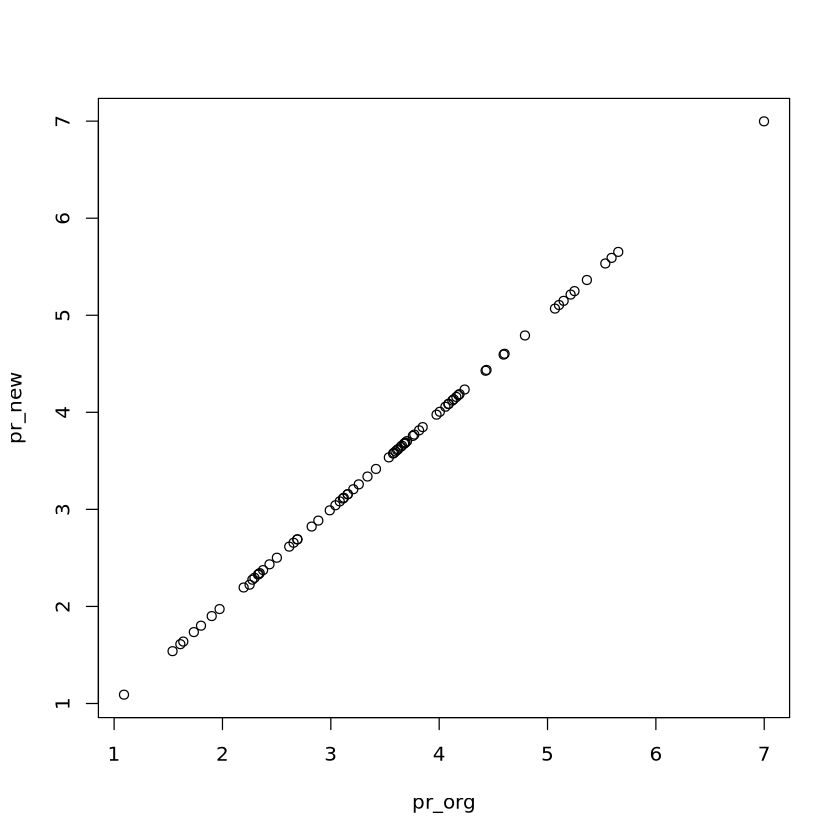

In [12]:
plot(df[,-1])